In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
%matplotlib inline
import matplotlib.pyplot as plt

import sys 
import inspect
import seaborn as sns
import os
import copy

import perturbseq as perturb

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis')
sc.logging.print_versions()

scanpy==1.5.1 anndata==0.7.1 umap==0.4.4 numpy==1.17.2 scipy==1.4.1 pandas==0.24.2 scikit-learn==0.22 statsmodels==0.11.0 python-igraph==0.7.1 louvain==0.6.1 leidenalg==0.8.1


In [3]:
PROTEIN='KRAS'
DATA='/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14'
SUBSAMPLED=DATA+'/'+PROTEIN+'/subsampled/A549.'+PROTEIN

counts=20000

FIGS=DATA+'/2021-03-22_Figures/'
os.system('mkdir -p '+FIGS)
print(FIGS)

sc.settings.figdir=FIGS

/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/2021-03-22_Figures/


In [4]:
ANNO=DATA+'/'+PROTEIN+'/anno'
anno=pd.read_csv(ANNO+'/'+PROTEIN+'.anno.complete3.csv',sep='\t',index_col=0)
anno=anno.loc[anno['Library_synthesis']=='in',:]

sorted_variants_df=pd.read_csv(DATA+'/'+PROTEIN+'/clustering/'+PROTEIN+'.corrL1.sorted_variants_2021-03-23.csv',header=None)
sorted_variants_df.index=sorted_variants_df[0]
sorted_variants=list(sorted_variants_df[0])
print(sorted_variants)

print(anno.columns)


['M111L', 'T127T', 'V112I', 'R149K', 'S17S', 'T74T', 'I163S', 'G75A', 'S136N', 'K179R', 'T158A', 'T20T', 'V8V', 'A66A', 'M170L', 'D173D', 'T158T', 'A130V', 'D30D', 'K176Q', 'T144T', 'C118S', 'Y166H', 'WT', 'K88K', 'A155G', 'T50T', 'K169K', 'F141L', 'R135T', 'R164Q', 'P110S', 'K178K', 'L159S', 'L79I', 'Q25H', 'K147N', 'G77A', 'K147T', 'E63K', 'V14I', 'T50I', 'E31K', 'Q99E', 'R41K', 'T50P', 'T20R', 'Q22H', 'C185Y', 'T20M', 'T144P', 'L52F', 'T74A', 'D57N', 'unassigned', 'N26Y', 'D33E', 'L19F', 'Q61K', 'P34L', 'K5E', 'P34R', 'G60D', 'Q61P', 'G60S', 'G60V', 'R68S', 'I36M', 'T58I', 'Q22K', 'K117R', 'A59T', 'AG59GV', 'D119G', 'G12Y', 'G12F', 'V14L', 'A59E', 'G12S', 'G12A', 'A59G', 'A146V', 'G13C', 'G12C', 'A146P', 'A146T', 'G12V', 'AG11TD', 'G12D', 'G12I', 'G12R', 'Q61A', 'Q61H', 'Q61R', 'Q61L', 'G13E', 'K117N', 'G13V', 'G13R']
Index(['Variant.1', 'Variant.1.1', 'Position', 'From', 'To', 'mutation_type',
       'Count_pancan', 'Count_ExAC', 'control_status', 'control_color',
       'Library_s

In [5]:
f='/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2019-06-07/KRAS/mutational_signatures/KRAS_mutationalSignatures_Andrew.txt'
mutsig=pd.read_csv(f,sep='\t')
mutsig.index=mutsig['Mutation']
print(mutsig.head())
print(mutsig.columns)

#modify the names for the synonymous ones
import re
new_vars=[]
for i in range(mutsig.shape[0]):
    v=mutsig.index[i]
    new_var_here=v
    if 'B' in v:
        new_var_here=re.sub('B',v[0],v)
    new_vars.append(new_var_here)
mutsig.index=new_vars


          Position WT AA Final AA Mutation  COSMIC  Day0 Reads  Z-Low-D7  \
Mutation                                                                   
G12D            12     G        D     G12D  Single      1756.3      7.30   
G12V            12     G        V     G12V  Single      1803.0      6.88   
G12C            12     G        C     G12C  Single      2495.7      5.55   
G13D            13     G        D     G13D  Single      3388.3      5.68   
G12A            12     G        A     G12A  Single       922.0      3.28   

          Z-Low-D14  Z-High-D7  Z-High-D14  ...  Signature_21  Signature_22  \
Mutation                                    ...                               
G12D           6.41       2.47        4.21  ...        0.0062      0.001525   
G12V           5.89       2.57        4.08  ...        0.0007      0.002451   
G12C           4.74       1.86        2.41  ...        0.0020      0.004550   
G13D           4.90       1.81        3.21  ...        0.0392      0.003

In [6]:
for c in ['Z-Low-D7','Z-Low-D14','COSMIC.1']:
    anno[c]=mutsig.loc[anno.index,c]

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


In [7]:
#check which of our variants are in the Giacomelli dataset
overlapping=set(mutsig.index).intersection(set(anno.index))
print('variants in',len(overlapping))
print(overlapping)
missed=set(anno.index).difference(set(mutsig.index))
print('variants not in',len(missed))
print(missed)

variants in 94
{'T20T', 'G60S', 'K178K', 'P34R', 'A130V', 'Q99E', 'G12F', 'E31K', 'K117N', 'Q61H', 'Q61K', 'N26Y', 'K88K', 'G13V', 'T50T', 'G12S', 'D173D', 'A146V', 'L159S', 'R41K', 'T144T', 'K169K', 'Q61L', 'D33E', 'G12V', 'V14I', 'T50I', 'L52F', 'I36M', 'G60D', 'G12D', 'T74T', 'Q61A', 'G12C', 'R164Q', 'Q25H', 'K176Q', 'K147N', 'G60V', 'V112I', 'K5E', 'R68S', 'P34L', 'A155G', 'I163S', 'C118S', 'V14L', 'Q22H', 'G12A', 'R135T', 'A59G', 'R149K', 'M111L', 'K147T', 'C185Y', 'T74A', 'Q61R', 'A146T', 'V8V', 'T158T', 'D30D', 'G13C', 'K179R', 'A66A', 'M170L', 'D57N', 'A59E', 'P110S', 'T144P', 'G12R', 'L19F', 'Q22K', 'T20M', 'T50P', 'T158A', 'T20R', 'Q61P', 'E63K', 'G12Y', 'L79I', 'T58I', 'D119G', 'K117R', 'G13R', 'A59T', 'S136N', 'S17S', 'G75A', 'F141L', 'G12I', 'A146P', 'G13E', 'T127T', 'G77A'}
variants not in 4
{'AG59GV', 'WT', 'AG11TD', 'Y166H'}


In [8]:
def fun_scatter(x,y,xname='x',yname='y',width=4,height=4,corrtype='spearman',
                xlim=None,ylim=None,
                **kwargs):
    from scipy.stats import spearmanr, pearsonr
    if corrtype=='spearman':
        corr=spearmanr(x,y,nan_policy='omit')
    if corrtype=='pearson':
        corr=pearsonr(x,y)
    c,p="%.2g" % corr[0],"%.3g" % corr[1]
    fig,plots=plt.subplots(1)
    fig.set_size_inches(width,height)
    plots.scatter(x,y,**kwargs)
    plots.set_xlabel(xname)
    plots.set_ylabel(yname)
    if xlim!=None:
        plots.set_xlim(xlim)
    if ylim!=None:
        plots.set_ylim(ylim)
    plots.set_title(corrtype+':'+str(c)+'\n'+'p:'+str(p))
    


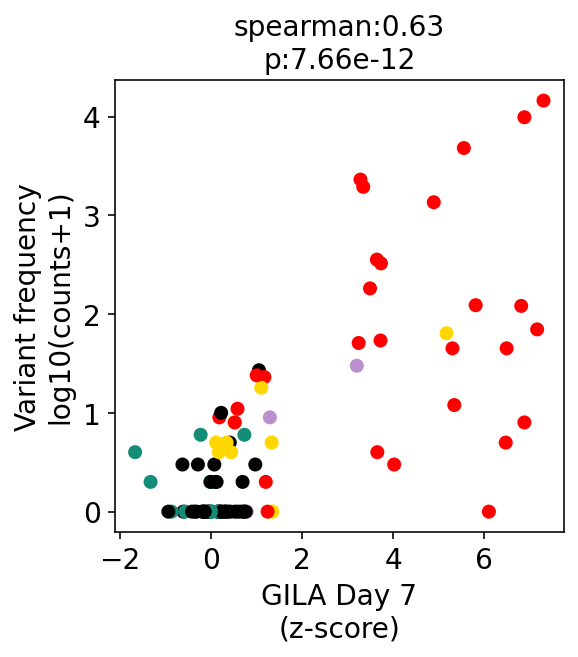

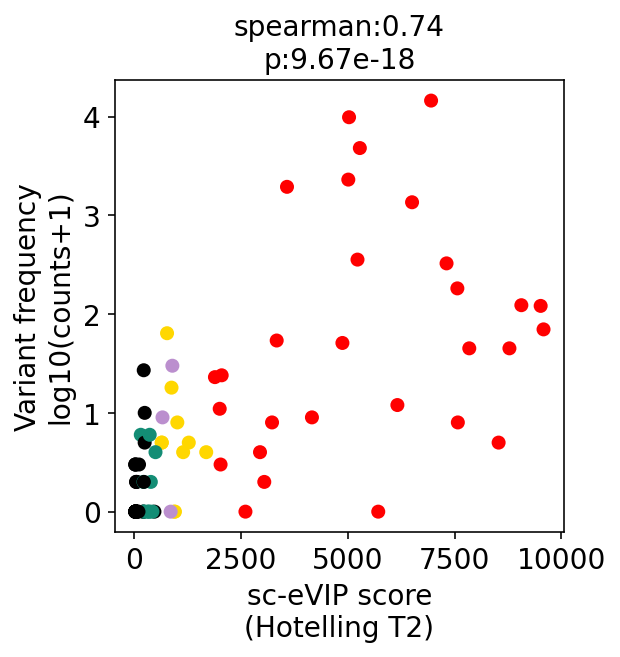

In [9]:
for f1 in ['Z-Low-D7','HotellingT2']:
    mutcount='COSMIC.1'
    fun_scatter(anno.loc[overlapping,f1],
                np.log10(anno.loc[overlapping,mutcount]+1),
               color=anno.loc[overlapping,'cluster_color'],
                xname=f1,yname='log counts',corrtype='spearman')
    plt.grid(False)
    
    plt.ylabel('Variant frequency\nlog10(counts+1)')
    if f1=='HotellingT2':
        plt.xlabel('sc-eVIP score\n(Hotelling T2)')
    if f1=='Z-Low-D7':
        plt.xlabel('GILA Day 7\n(z-score)')
    
    plt.savefig(FIGS+'/'+PROTEIN+'.'+f1+'_vs_mutfreq.pdf',bbox_inches = "tight") 
    plt.savefig(FIGS+'/'+PROTEIN+'.'+f1+'_vs_mutfreq.png',bbox_inches = "tight")
    plt.show()

In [10]:
#restrict to variants with features. excludes synonymous variants
f='/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2019-06-07/KRAS/mutational_signatures/KRAS_mutationalSignatures_Andrew.txt'
mutsig_init=pd.read_csv(f,sep='\t')
mutsig_init.index=mutsig_init['Mutation']
mutsig_restricted=mutsig_init.dropna(axis='index')####### remove items without mutational signatures

print(mutsig_restricted.head())
print(mutsig_restricted.shape)


          Position WT AA Final AA Mutation  COSMIC  Day0 Reads  Z-Low-D7  \
Mutation                                                                   
G12D            12     G        D     G12D  Single      1756.3      7.30   
G12V            12     G        V     G12V  Single      1803.0      6.88   
G12C            12     G        C     G12C  Single      2495.7      5.55   
G13D            13     G        D     G13D  Single      3388.3      5.68   
G12A            12     G        A     G12A  Single       922.0      3.28   

          Z-Low-D14  Z-High-D7  Z-High-D14  ...  Signature_21  Signature_22  \
Mutation                                    ...                               
G12D           6.41       2.47        4.21  ...        0.0062      0.001525   
G12V           5.89       2.57        4.08  ...        0.0007      0.002451   
G12C           4.74       1.86        2.41  ...        0.0020      0.004550   
G13D           4.90       1.81        3.21  ...        0.0392      0.003

       COSMIC.1  effect size cluster_color
M111L       0.0    26.248723         black
T127T       0.0    32.272526         black
V112I       0.0    35.479506         black
R149K       0.0    42.294631         black
S17S        0.0    45.923732         black


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


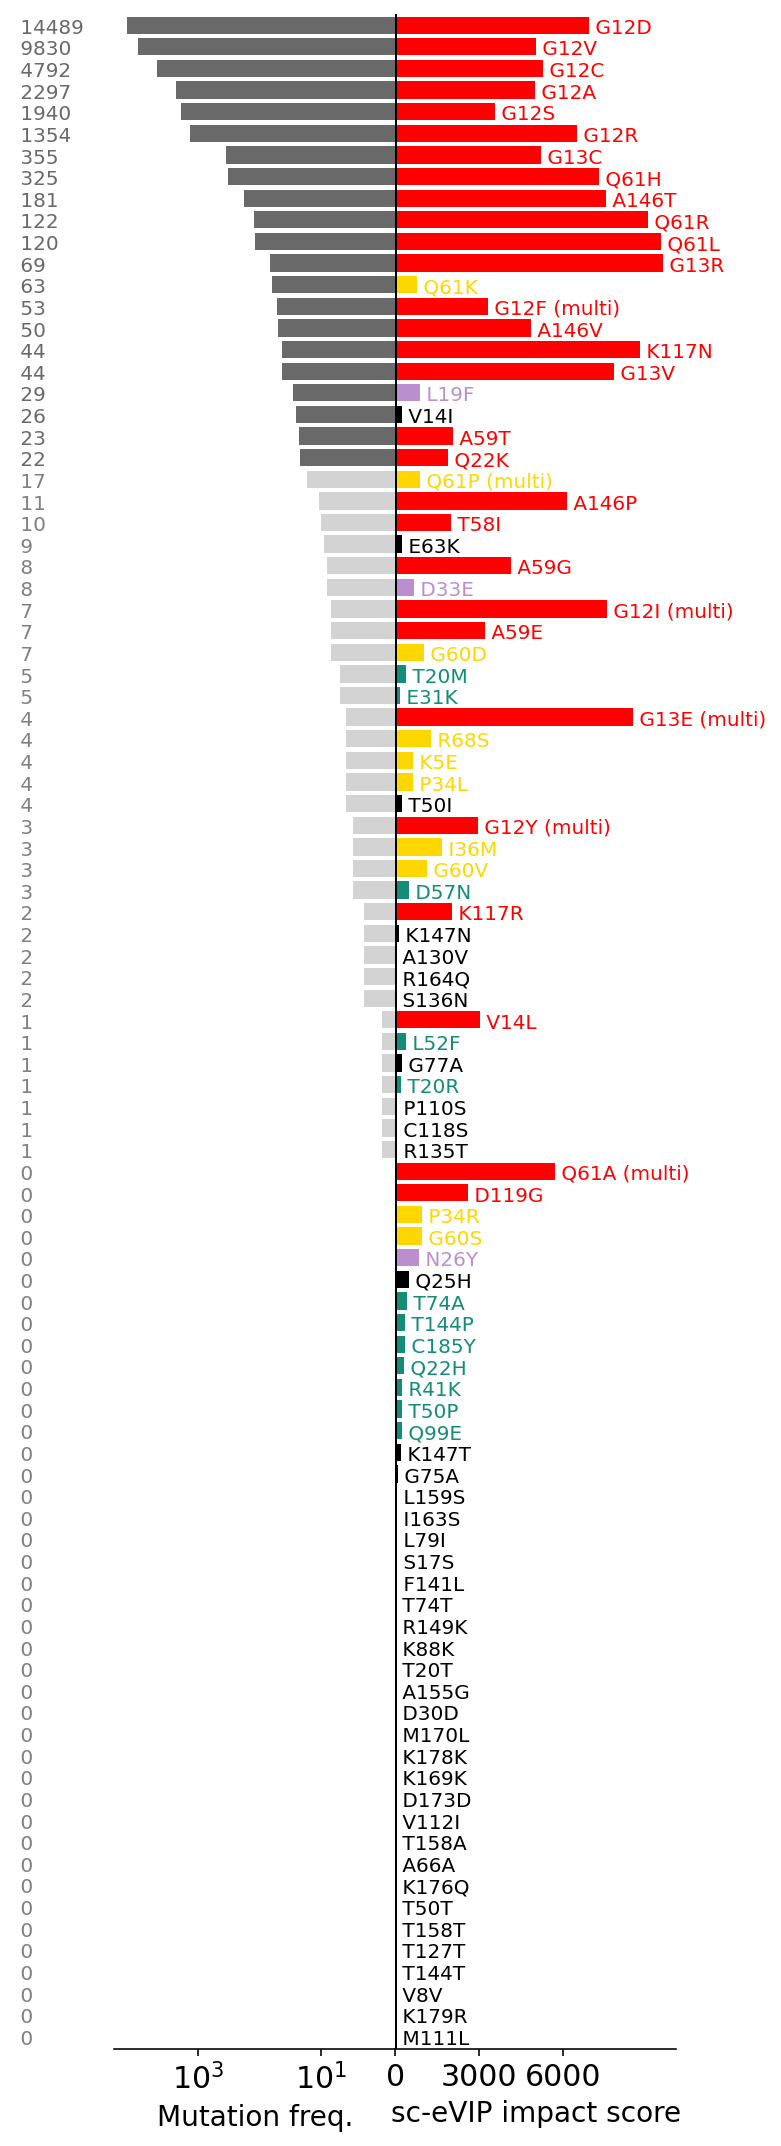

In [11]:
#effect size vs mut freq

#plot impact score vs mutation frequency

#- get the data
mutcount='COSMIC.1'
score='HotellingT2'
mutdata=pd.DataFrame({mutcount:anno.loc[sorted_variants,mutcount],
                     'effect size':anno.loc[sorted_variants,score],
                     'cluster_color':anno.loc[sorted_variants,'cluster_color']},
                    index=sorted_variants)
print(mutdata.head())
mutdata=mutdata.dropna(subset=[mutcount])
mutdata=mutdata.sort_values(by=[mutcount,'effect size'])
mutdata[mutcount]=pd.DataFrame(mutdata[mutcount],dtype=float)
mutdata['color_mutant_freq']='lightgray'
mutdata.loc[mutdata[mutcount]>=20,'color_mutant_freq']='dimgray'

#- make the plot
multiply_impact_score=1

fig,plots=plt.subplots(1,2)
fig.set_size_inches(5,18)
fig.subplots_adjust(wspace=0, hspace=0)

plots[1].barh(mutdata.index,
           mutdata['effect size']*multiply_impact_score,
           color=mutdata['cluster_color'])

plots[0].barh(mutdata.index,
           mutdata[mutcount],
          color=mutdata['color_mutant_freq'])
plots[0].set_xscale('log')
plots[0].invert_xaxis()

plots[1].axvline(x=0,color='black')
for i in range(2):
    plots[i].set_ylim(-0.6,mutdata.shape[0]-0.5)
    plots[i].spines['right'].set_visible(False)
    plots[i].spines['left'].set_visible(False)
    plots[i].spines['top'].set_visible(False)
    plots[i].set_yticks([])
    
#annotate the number of mutations and the variants
n=mutdata.shape[0]
for i in range(n):
    variant=list(mutdata.index)[i]
    effect_size=list(mutdata['effect size'])[i]
    effect_size_plot=multiply_impact_score*effect_size
    effect_size_color=list(mutdata['cluster_color'])[i]
    mutfreq=int(list(mutdata[mutcount])[i])
    mutfreq_plot=mutfreq
    mutfreq_color=list(mutdata['color_mutant_freq'])[i]
    if mutfreq_color=='lightgray':
        mutfreq_color='gray'
    
    plots[0].text(1000000,i-0.4,' '+str(int(mutfreq)),
                 color=mutfreq_color)
    
    variant_text=' '+variant
    if anno.loc[variant,'mutation_type']=='Multiple':
        variant_text=variant_text+' (multi)'
    plots[1].text(effect_size_plot,i-0.4,variant_text,
                 color=effect_size_color)
    
plots[1].set_xticks([0,3000,6000])
plots[1].set_xticklabels([0,int(3000.0/multiply_impact_score),
                          int(6000.0/multiply_impact_score)],fontsize=15)
plots[0].tick_params(axis='x', labelsize=15)
plots[0].set_xlabel('Mutation freq.')
plots[1].set_xlabel('sc-eVIP impact score')
plots[0].grid(False)
plots[1].grid(False)


plt.savefig(FIGS+'/'+PROTEIN+'.EffectSize_vs_mutfreq.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/'+PROTEIN+'.EffectSize_vs_mutfreq.png',bbox_inches = "tight")
plt.show()

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


       Count_pancan  effect size cluster_color
M111L           2.0    26.248723         black
T127T           NaN    32.272526         black
V112I           NaN    35.479506         black
R149K           2.0    42.294631         black
S17S            NaN    45.923732         black


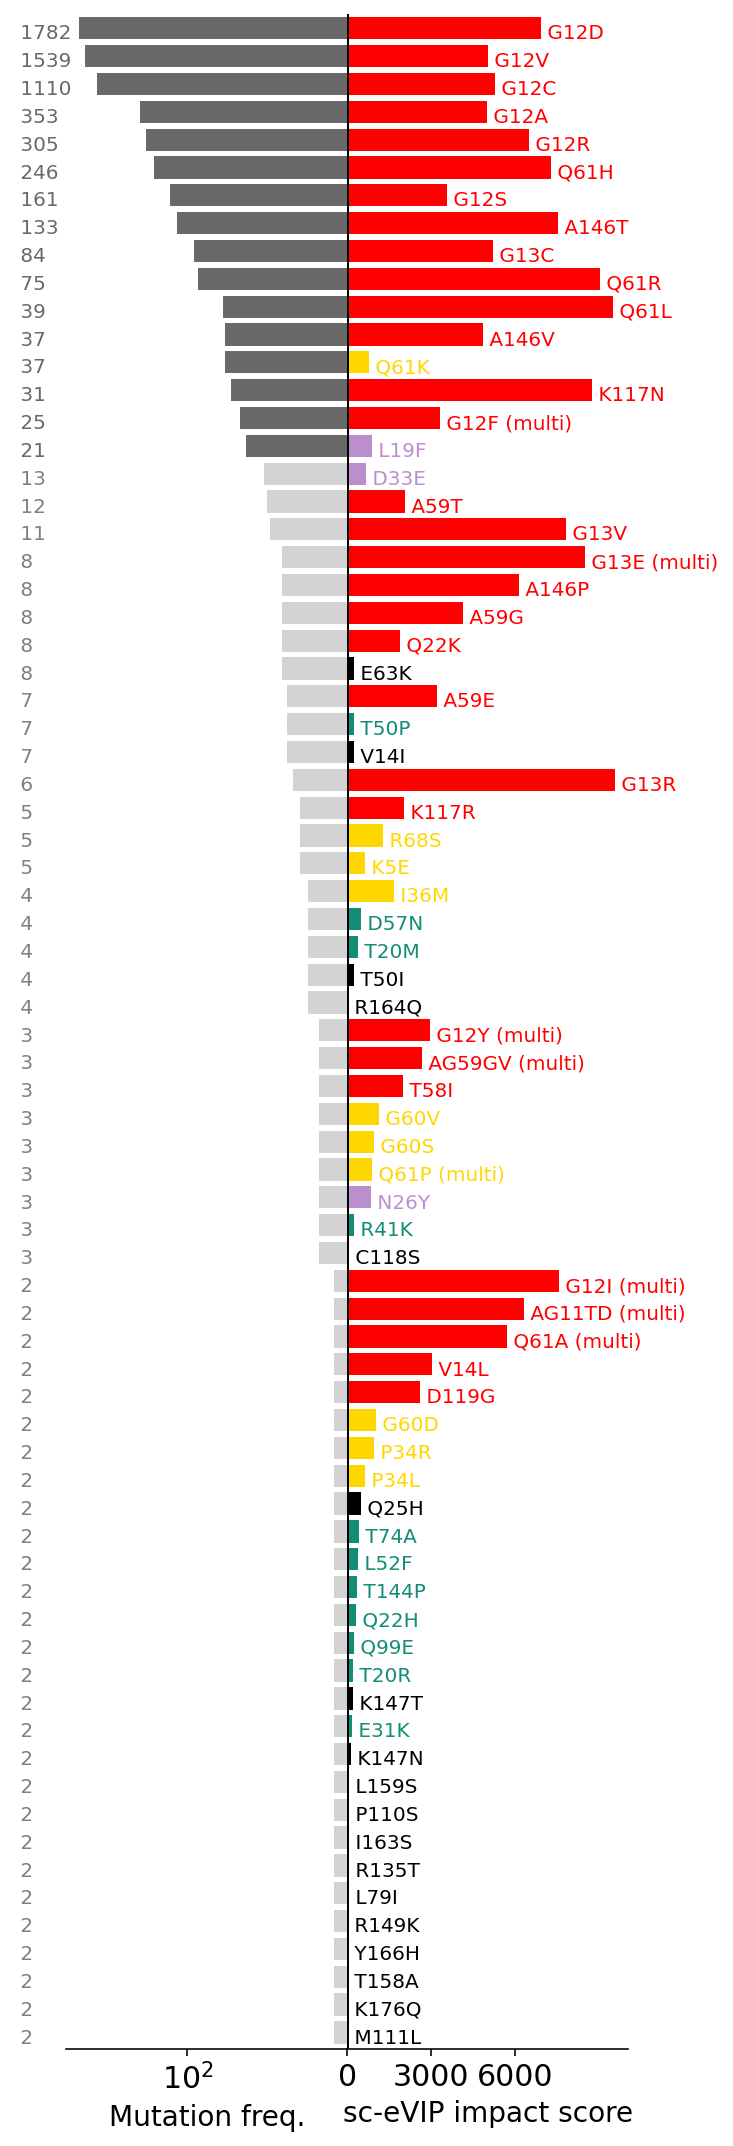

In [12]:
#effect size vs mut freq

#plot impact score vs mutation frequency

#- get the data
mutcount='Count_pancan'
score='HotellingT2'
mutdata=pd.DataFrame({mutcount:anno.loc[sorted_variants,mutcount],
                     'effect size':anno.loc[sorted_variants,score],
                     'cluster_color':anno.loc[sorted_variants,'cluster_color']},
                    index=sorted_variants)
print(mutdata.head())
mutdata=mutdata.dropna(subset=[mutcount])
mutdata=mutdata.sort_values(by=[mutcount,'effect size'])
mutdata[mutcount]=pd.DataFrame(mutdata[mutcount],dtype=float)
mutdata['color_mutant_freq']='lightgray'
mutdata.loc[mutdata[mutcount]>=20,'color_mutant_freq']='dimgray'

#- make the plot
multiply_impact_score=1

fig,plots=plt.subplots(1,2)
fig.set_size_inches(5,18)
fig.subplots_adjust(wspace=0, hspace=0)

plots[1].barh(mutdata.index,
           mutdata['effect size']*multiply_impact_score,
           color=mutdata['cluster_color'])

plots[0].barh(mutdata.index,
           mutdata[mutcount],
          color=mutdata['color_mutant_freq'])
plots[0].set_xscale('log')
plots[0].invert_xaxis()

plots[1].axvline(x=0,color='black')
for i in range(2):
    plots[i].set_ylim(-0.6,mutdata.shape[0]-0.5)
    plots[i].spines['right'].set_visible(False)
    plots[i].spines['left'].set_visible(False)
    plots[i].spines['top'].set_visible(False)
    plots[i].set_yticks([])
    
#annotate the number of mutations and the variants
n=mutdata.shape[0]
for i in range(n):
    variant=list(mutdata.index)[i]
    effect_size=list(mutdata['effect size'])[i]
    effect_size_plot=multiply_impact_score*effect_size
    effect_size_color=list(mutdata['cluster_color'])[i]
    mutfreq=int(list(mutdata[mutcount])[i])
    mutfreq_plot=mutfreq
    mutfreq_color=list(mutdata['color_mutant_freq'])[i]
    if mutfreq_color=='lightgray':
        mutfreq_color='gray'
    
    plots[0].text(10000,i-0.4,' '+str(int(mutfreq)),
                 color=mutfreq_color)
    
    variant_text=' '+variant
    if anno.loc[variant,'mutation_type']=='Multiple':
        variant_text=variant_text+' (multi)'
    plots[1].text(effect_size_plot,i-0.4,variant_text,
                 color=effect_size_color)
    
plots[1].set_xticks([0,3000,6000])
plots[1].set_xticklabels([0,int(3000.0/multiply_impact_score),
                          int(6000.0/multiply_impact_score)],fontsize=15)
plots[0].tick_params(axis='x', labelsize=15)
plots[0].set_xlabel('Mutation freq.')
plots[1].set_xlabel('sc-eVIP impact score')
plots[0].grid(False)
plots[1].grid(False)


plt.savefig(FIGS+'/'+PROTEIN+'.EffectSize_vs_mutfreq.pancan.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/'+PROTEIN+'.EffectSize_vs_mutfreq.pancan.png',bbox_inches = "tight")
plt.show()

In [13]:
mutsig.columns

Index(['Position', 'WT AA', 'Final AA', 'Mutation', 'COSMIC', 'Day0 Reads',
       'Z-Low-D7', 'Z-Low-D14', 'Z-High-D7', 'Z-High-D14', 'Theta-D7',
       'chisq-pval-D7', 'Theta-D14', 'chisq-pval-D14', 'COSMIC.1', 'GENIE',
       'TCGA', 'EXaC', 'Signature_1', 'Signature_2', 'Signature_3',
       'Signature_4', 'Signature_5', 'Signature_6', 'Signature_7',
       'Signature_8', 'Signature_9', 'Signature_10', 'Signature_11',
       'Signature_12', 'Signature_13', 'Signature_14', 'Signature_15',
       'Signature_16', 'Signature_17', 'Signature_18', 'Signature_19',
       'Signature_20', 'Signature_21', 'Signature_22', 'Signature_23',
       'Signature_24', 'Signature_25', 'Signature_26', 'Signature_27',
       'Signature_28', 'Signature_29', 'Signature_30'],
      dtype='object')

Data for the model
===

Keep only variants with mutational signatures annotated. That removed the synonymous variants.

In [14]:
#define data
data=pd.DataFrame(mutsig_restricted)
# need to add HotellingT2
data['HotellingT2']=anno.loc[data.index,'HotellingT2']

#check which of our variants are in the Giacomelli dataset
overlapping=set(mutsig_restricted.index).intersection(set(anno.index))
print('variants in',len(overlapping))
print(overlapping)
missed=set(anno.index).difference(set(mutsig_restricted.index))
print('variants not in',len(missed))
print(missed)

data['has_effsize']=False
data.loc[list(overlapping),'has_effsize']=True

print('Data',data.columns)
print(data.shape)

#keep only thozs with non-zero counts
data=data.loc[data['COSMIC.1']>0,:]
print(data.shape)

variants in 89
{'T20T', 'G60S', 'K178K', 'P34R', 'A130V', 'Q99E', 'E31K', 'K117N', 'Q61H', 'Q61K', 'N26Y', 'K88K', 'G13V', 'T50T', 'G12S', 'D173D', 'A146V', 'L159S', 'R41K', 'T144T', 'K169K', 'Q61L', 'D33E', 'G12V', 'V14I', 'T50I', 'L52F', 'I36M', 'G60D', 'G12D', 'T74T', 'G12C', 'R164Q', 'Q25H', 'K176Q', 'K147N', 'G60V', 'V112I', 'K5E', 'R68S', 'P34L', 'A155G', 'I163S', 'C118S', 'V14L', 'Q22H', 'G12A', 'R135T', 'A59G', 'R149K', 'M111L', 'K147T', 'C185Y', 'T74A', 'Q61R', 'A146T', 'V8V', 'T158T', 'D30D', 'G13C', 'K179R', 'A66A', 'M170L', 'D57N', 'A59E', 'P110S', 'T144P', 'G12R', 'L19F', 'Q22K', 'T20M', 'T50P', 'T158A', 'T20R', 'Q61P', 'E63K', 'L79I', 'T58I', 'D119G', 'K117R', 'G13R', 'A59T', 'S136N', 'S17S', 'G75A', 'F141L', 'A146P', 'T127T', 'G77A'}
variants not in 9
{'Y166H', 'G12F', 'WT', 'G12I', 'G13E', 'AG59GV', 'AG11TD', 'G12Y', 'Q61A'}
Data Index(['Position', 'WT AA', 'Final AA', 'Mutation', 'COSMIC', 'Day0 Reads',
       'Z-Low-D7', 'Z-Low-D14', 'Z-High-D7', 'Z-High-D14', 'Theta-

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


In [15]:
#make data with 0-ed func data
#predict => from mutational 

def predict_from_mutational(data,features,func_data,mymodel):
    mut_data=data.loc[:,features]
    for c in func_data:
        mut_data[c]=0
    #now, predict
    print(mut_data.loc['T144P',:])
    mut_preds=mymodel.predict(mut_data.loc[:,model.params.index])
    return(mut_preds)

pheno=['A549_p53NULL_Etoposide_Z-score',
      'A549_p53NULL_Nutlin-3_Z-score',
      'A549_p53WT_Nutlin-3_Z-score']
signature_cols=['Signature_1', 'Signature_2', 'Signature_3',
       'Signature_4', 'Signature_5', 'Signature_6', 'Signature_7',
       'Signature_8', 'Signature_9', 'Signature_10', 'Signature_11',
       'Signature_12', 'Signature_13', 'Signature_14', 'Signature_15',
       'Signature_16', 'Signature_17', 'Signature_18', 'Signature_19',
       'Signature_20', 'Signature_21', 'Signature_22', 'Signature_23',
       'Signature_24', 'Signature_25', 'Signature_26', 'Signature_27',
       'Signature_28', 'Signature_29', 'Signature_30']

mut_prediction_data=pd.DataFrame(index=sorted_variants)

for i in range(10):
    from statsmodels.regression.linear_model import OLSResults
    model = OLSResults.load('TP53model.iter'+str(i))
    print(model.params)
                
    mut_preds=predict_from_mutational(mutsig,list(set(signature_cols).union(set(pheno))),pheno,
                       model)
    mut_prediction_data['iter'+str(i)]=mut_preds.loc[sorted_variants]


Signature_30                       2.414225
A549_p53NULL_Etoposide_Z-score    -0.782812
Signature_12                      -4.857280
Signature_24                      -7.168720
Signature_8                      -22.757827
Signature_10                       4.414422
Signature_1                       13.042607
Signature_23                      11.930191
Signature_27                      -0.492341
A549_p53NULL_Nutlin-3_Z-score      0.396548
Signature_15                     -15.888666
Signature_3                       -0.620593
Signature_16                      54.715726
Signature_20                      -3.959925
Signature_21                      11.689773
Signature_7                        4.040534
Signature_9                      -23.980634
Signature_28                      -1.104265
Signature_18                       3.478119
Signature_19                     -11.438035
Signature_14                      -3.214773
Signature_2                        0.779030
Signature_22                    

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


Signature_30                      -1.919377
A549_p53NULL_Etoposide_Z-score    -0.865900
Signature_12                      23.172254
Signature_24                      -0.587183
Signature_8                      -18.524564
Signature_10                       2.046404
Signature_1                       17.746152
Signature_23                       1.127107
Signature_27                      -0.135481
A549_p53NULL_Nutlin-3_Z-score      0.474441
Signature_15                      -0.288832
Signature_3                        6.639972
Signature_16                      34.610529
Signature_20                       2.186921
Signature_21                      15.639705
Signature_7                       -0.499330
Signature_9                      -36.586337
Signature_28                       0.221066
Signature_18                       3.240911
Signature_19                      -7.921130
Signature_14                      -5.899390
Signature_2                        1.533297
Signature_22                    

Signature_30                       5.385453
A549_p53NULL_Etoposide_Z-score    -0.189781
Signature_12                      13.377136
Signature_24                       2.764781
Signature_8                      -29.397191
Signature_10                       2.244593
Signature_1                       16.001047
Signature_23                      -3.960030
Signature_27                      -0.145631
A549_p53NULL_Nutlin-3_Z-score      0.981698
Signature_15                      -0.504391
Signature_3                        6.285357
Signature_16                      29.084007
Signature_20                     -10.301386
Signature_21                      -7.163798
Signature_7                       -2.390824
Signature_9                      -13.332133
Signature_28                      -2.936963
Signature_18                      -1.395050
Signature_19                       5.272514
Signature_14                       1.896700
Signature_2                        0.767738
Signature_22                    

Signature_30                      -1.075360
A549_p53NULL_Etoposide_Z-score    -0.635207
Signature_12                      16.883149
Signature_24                      -2.907391
Signature_8                      -12.661353
Signature_10                       7.588604
Signature_1                        9.058883
Signature_23                       0.796681
Signature_27                       0.382385
A549_p53NULL_Nutlin-3_Z-score      0.608406
Signature_15                      -7.257930
Signature_3                       15.654248
Signature_16                      17.734278
Signature_20                      -6.172368
Signature_21                       5.695133
Signature_7                       -2.689607
Signature_9                      -56.479482
Signature_28                       3.391354
Signature_18                       0.865889
Signature_19                      -5.649587
Signature_14                      -8.691096
Signature_2                       -0.015186
Signature_22                    

In [16]:
means=np.mean(mut_prediction_data,axis=1)
sds=np.std(mut_prediction_data,axis=1)
mut_prediction_data2=pd.DataFrame({'mean':means,'sd':sds},index=mut_prediction_data.index)
print(mut_prediction_data2)

             mean         sd
M111L    0.301105   0.123857
T127T    1.633848   0.423895
V112I    4.057954   1.339632
R149K    5.125338   0.962801
S17S     2.383965   0.762232
T74T     4.772756   2.414577
I163S    0.667124   0.224699
G75A     0.950989   0.111977
S136N    1.706041   0.662144
K179R    2.134550   0.386291
T158A    4.046497   1.154081
T20T    47.048667  21.116642
V8V      0.643690   0.364499
A66A     1.633848   0.423895
M170L    1.111986   0.348370
D173D    3.566118   0.653020
T158T    4.654879   1.251567
A130V    2.817056   0.711556
D30D    66.259937  15.751649
K176Q    0.308300   0.221345
T144T    4.654879   1.251567
C118S    1.486559   0.431870
Y166H         NaN        NaN
WT            NaN        NaN
K88K     2.213851   1.500453
A155G    1.090556   0.080456
T50T     9.139798   3.526265
K169K    5.125338   0.962801
F141L    0.163294   0.162498
R135T    2.975193   0.919741
...           ...        ...
Q22K     6.296256   1.675343
K117R    0.783428   0.229099
A59T     2.817

Index(['M111L', 'K179R', 'V8V', 'T144T', 'T127T', 'T158T', 'T50T', 'K176Q',
       'A66A', 'T158A', 'V112I', 'D173D', 'K169K', 'K178K', 'M170L', 'D30D',
       'A155G', 'T20T', 'K88K', 'R149K', 'T74T', 'F141L', 'S17S', 'L79I',
       'I163S', 'L159S', 'G75A', 'K147T', 'Q99E', 'T50P', 'R41K', 'Q22H',
       'C185Y', 'T144P', 'T74A', 'Q25H', 'N26Y', 'G60S', 'P34R', 'D119G',
       'Q61A', 'R135T', 'C118S', 'P110S', 'T20R', 'G77A', 'L52F', 'V14L',
       'S136N', 'R164Q', 'A130V', 'K147N', 'K117R', 'D57N', 'G60V', 'I36M',
       'G12Y', 'T50I', 'P34L', 'K5E', 'R68S', 'G13E', 'E31K', 'T20M', 'G60D',
       'A59E', 'G12I', 'D33E', 'A59G', 'E63K', 'T58I', 'A146P', 'Q61P', 'Q22K',
       'A59T', 'V14I', 'L19F', 'G13V', 'K117N', 'A146V', 'G12F', 'Q61K',
       'G13R', 'Q61L', 'Q61R', 'A146T', 'Q61H', 'G13C', 'G12R', 'G12S', 'G12A',
       'G12C', 'G12V', 'G12D'],
      dtype='object')


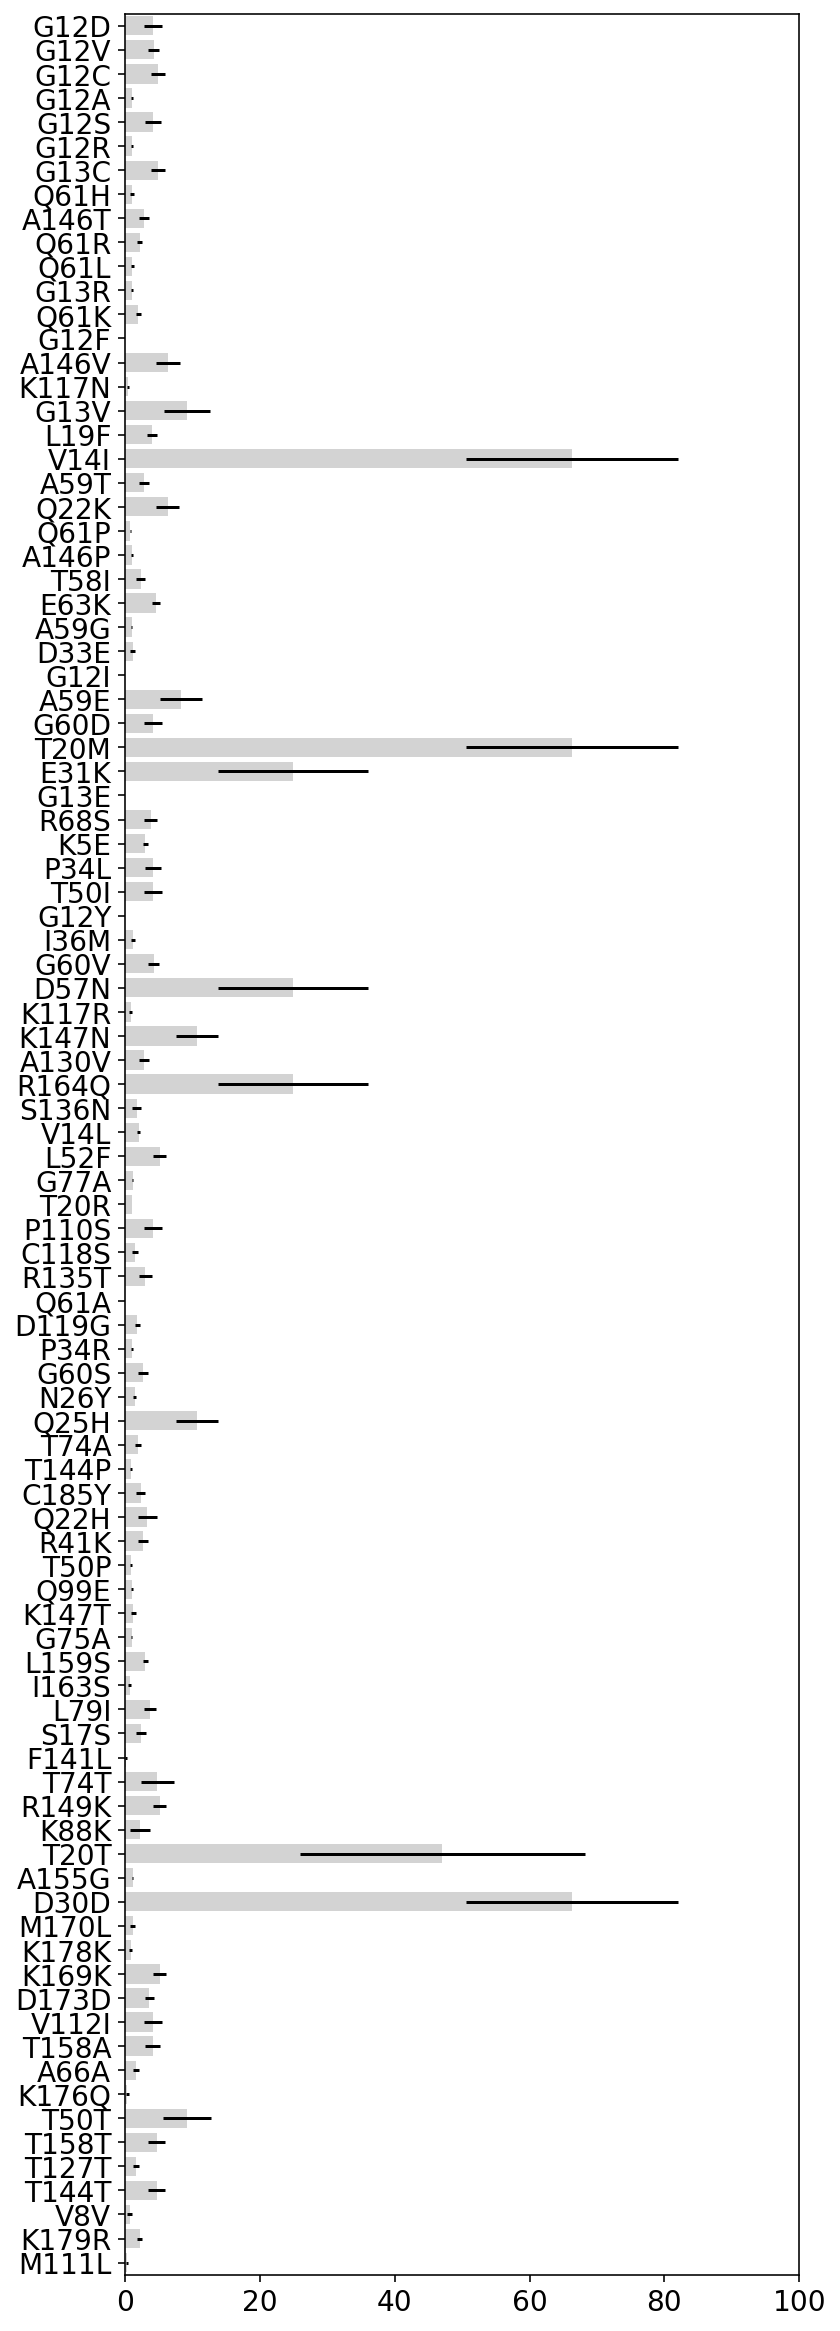

In [17]:
#effect size vs mut freq

#plot impact score vs mutation frequency

mutcount='mut.pred'

#- get the data
score='HotellingT2'
mutdata=pd.DataFrame({#mutcount:mutsig.loc[sorted_variants,mutcount],
                     'effect size':anno.loc[sorted_variants,score],
                     'cluster_color':anno.loc[sorted_variants,'cluster_color'],
                     'COSMIC.1':mutsig.loc[sorted_variants,'COSMIC.1']},
                    index=sorted_variants)
mutdata=mutdata.dropna(subset=['COSMIC.1'])
mutdata=mutdata.fillna(0)
mutdata=mutdata.sort_values(by=['COSMIC.1','effect size'])
print(mutdata.index)
mut_prediction_data2=mut_prediction_data2.loc[mutdata.index,:]
mut_prediction_data2=mut_prediction_data2.fillna(0)

fig,plots=plt.subplots(1)
fig.set_size_inches(6,20)
plots.barh(mut_prediction_data2.index,mut_prediction_data2['mean'],
           color='lightgray'
          )
plots.errorbar(mut_prediction_data2['mean'], mut_prediction_data2.index,
             xerr=mut_prediction_data2['sd'],
             linestyle='None',#marker='o',
               color='black')
plots.set_ylim(-0.5,mut_prediction_data2.shape[0]-0.5)
plots.set_xlim(0,100)
plt.grid(False)

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  from ipykernel import kernelapp as app


(0.8102371969537908, 100)

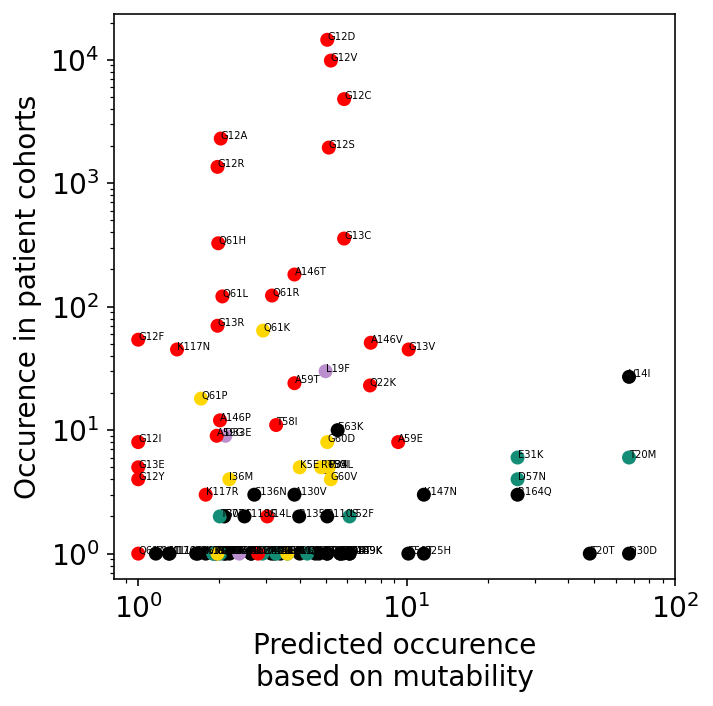

In [18]:
anno.loc['unassigned','cluster_color']='slateblue'
fig,plots=plt.subplots()
fig.set_size_inches(5,5)
plots.scatter(mut_prediction_data2.loc[sorted_variants,'mean']+1,
           mutsig.loc[sorted_variants,'COSMIC.1']+1,
           c=anno.loc[sorted_variants,'cluster_color'])
plots.set_xlabel('Predicted occurence\nbased on mutability')
plots.set_ylabel('Occurence in patient cohorts')
plots.grid(False)
for i, txt in enumerate(sorted_variants):
        plots.annotate(txt, (mut_prediction_data2.loc[sorted_variants,'mean'][i]+1, 
                             mutsig.loc[sorted_variants,'COSMIC.1'][i]+1),fontsize=5)
plots.set_yscale('log')
plots.set_xscale('log')
plots.set_xlim(0,100)

In [19]:
sum(mutsig.loc[anno.loc[anno['cluster_color']=='red',:].index,'COSMIC.1'].sort_values()>20)

18

In [20]:
len(anno.loc[anno['cluster_color']=='red',:].index)

31

In [ ]:
anno.loc['unassigned','cluster_color']='slateblue'
fig,plots=plt.subplots()
fig.set_size_inches(5,5)
plots.scatter(anno.loc[sorted_variants,'HotellingT2'],
           mutsig.loc[sorted_variants,'COSMIC.1']+1,
           s=mut_prediction_data2.loc[sorted_variants,'mean'],
              c=anno.loc[sorted_variants,'cluster_color'],
              vmax=20,cmap='viridis')

plots.grid(False)
plots.set_yscale('log')
plots.set_xscale('log')
#plots.set_xlim(0,100)
plots.set_xlabel('sc-eVIP score')
plots.set_ylabel('Occurence in patient cohorts')
plots.grid(False)
for i, txt in enumerate(sorted_variants):
        plots.annotate(txt, (anno.loc[sorted_variants,'HotellingT2'][i], 
                             mutsig.loc[sorted_variants,'COSMIC.1'][i]+1),fontsize=5,color='lightgray')
plots.set_yscale('log')
#plots.set_xscale('log')
plt.savefig(FIGS+'/'+PROTEIN+'.EffectSize_vs_mutfreq.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/'+PROTEIN+'.EffectSize_vs_mutfreq.png',bbox_inches = "tight")


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


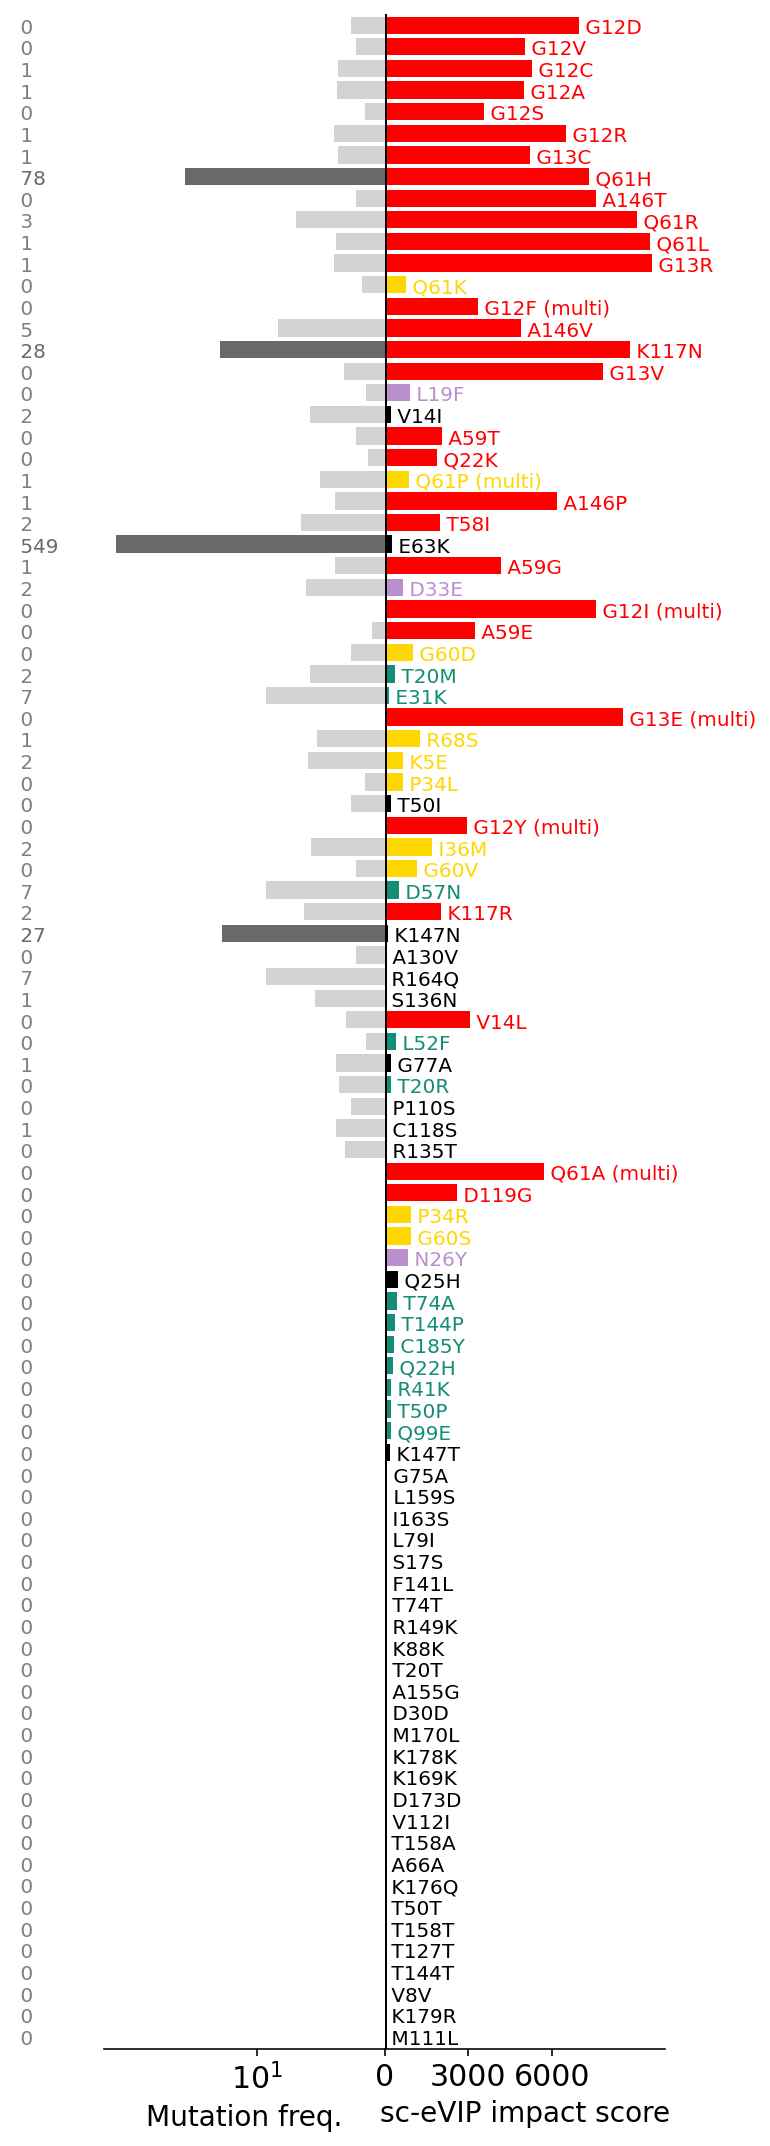

In [70]:
#effect size vs mut freq

#plot impact score vs mutation frequency

#- get the data
mutcount='mut.pred'
score='HotellingT2'
mutdata=pd.DataFrame({mutcount:mutsig.loc[sorted_variants,mutcount],
                     'effect size':anno.loc[sorted_variants,score],
                     'cluster_color':anno.loc[sorted_variants,'cluster_color'],
                     'COSMIC.1':mutsig.loc[sorted_variants,'COSMIC.1']},
                    index=sorted_variants)
mutdata=mutdata.dropna(subset=['COSMIC.1'])
mutdata=mutdata.fillna(0)
mutdata=mutdata.sort_values(by=['COSMIC.1','effect size'])
mutdata[mutcount]=pd.DataFrame(mutdata[mutcount],dtype=float)
mutdata['color_mutant_freq']='lightgray'
mutdata.loc[mutdata[mutcount]>=20,'color_mutant_freq']='dimgray'

#- make the plot
multiply_impact_score=1

fig,plots=plt.subplots(1,2)
fig.set_size_inches(5,18)
fig.subplots_adjust(wspace=0, hspace=0)

plots[1].barh(mutdata.index,
           mutdata['effect size']*multiply_impact_score,
           color=mutdata['cluster_color'])

plots[0].barh(mutdata.index,
           mutdata[mutcount],
          color=mutdata['color_mutant_freq'])
plots[0].set_xscale('log')
plots[0].invert_xaxis()

plots[1].axvline(x=0,color='black')
for i in range(2):
    plots[i].set_ylim(-0.6,mutdata.shape[0]-0.5)
    plots[i].spines['right'].set_visible(False)
    plots[i].spines['left'].set_visible(False)
    plots[i].spines['top'].set_visible(False)
    plots[i].set_yticks([])
    
#annotate the number of mutations and the variants
n=mutdata.shape[0]
for i in range(n):
    variant=list(mutdata.index)[i]
    effect_size=list(mutdata['effect size'])[i]
    effect_size_plot=multiply_impact_score*effect_size
    effect_size_color=list(mutdata['cluster_color'])[i]
    mutfreq=int(list(mutdata[mutcount])[i])
    mutfreq_plot=mutfreq
    mutfreq_color=list(mutdata['color_mutant_freq'])[i]
    if mutfreq_color=='lightgray':
        mutfreq_color='gray'
    
    plots[0].text(10000,i-0.4,' '+str(int(mutfreq)),
                 color=mutfreq_color)
    
    variant_text=' '+variant
    if anno.loc[variant,'mutation_type']=='Multiple':
        variant_text=variant_text+' (multi)'
    plots[1].text(effect_size_plot,i-0.4,variant_text,
                 color=effect_size_color)
    
plots[1].set_xticks([0,3000,6000])
plots[1].set_xticklabels([0,int(3000.0/multiply_impact_score),
                          int(6000.0/multiply_impact_score)],fontsize=15)
plots[0].tick_params(axis='x', labelsize=15)
plots[0].set_xlabel('Mutation freq.')
plots[1].set_xlabel('sc-eVIP impact score')
plots[0].grid(False)
plots[1].grid(False)


plt.show()

9.9045e-05


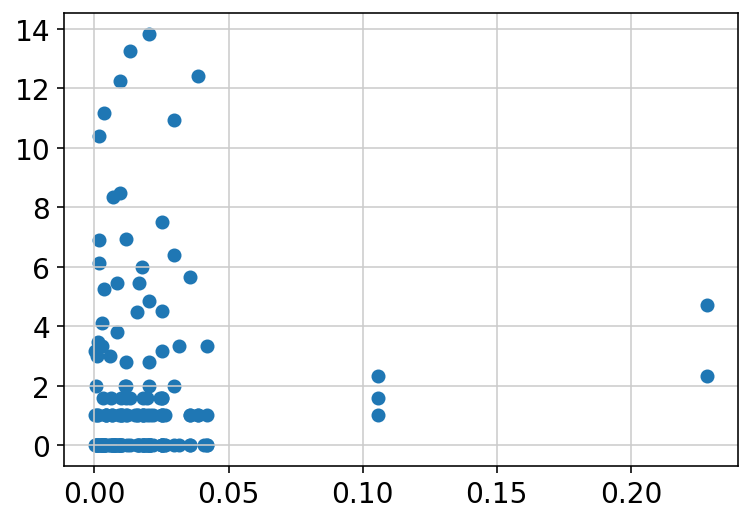

1.32377e-07


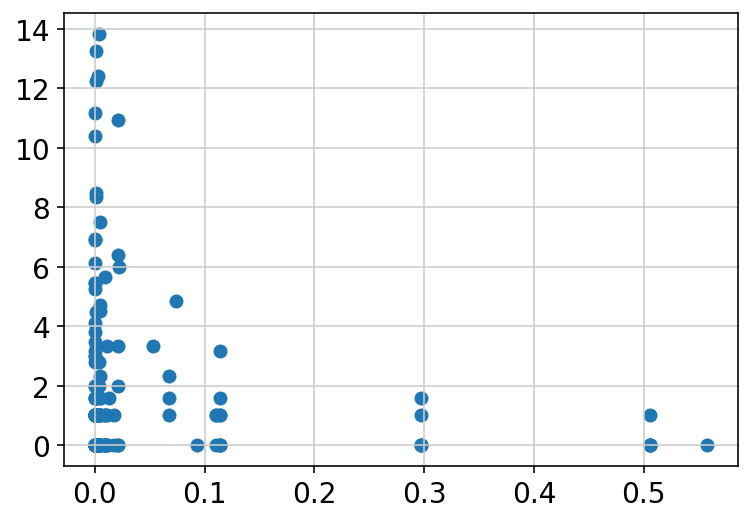

0.0013572389999999999


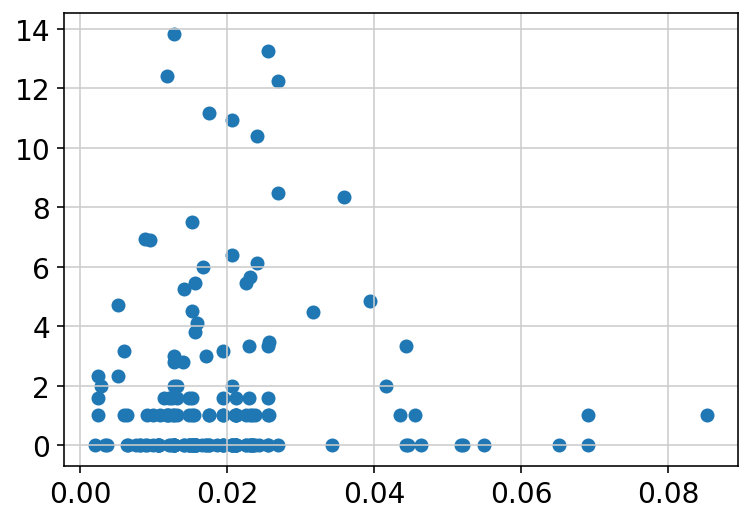

0.0


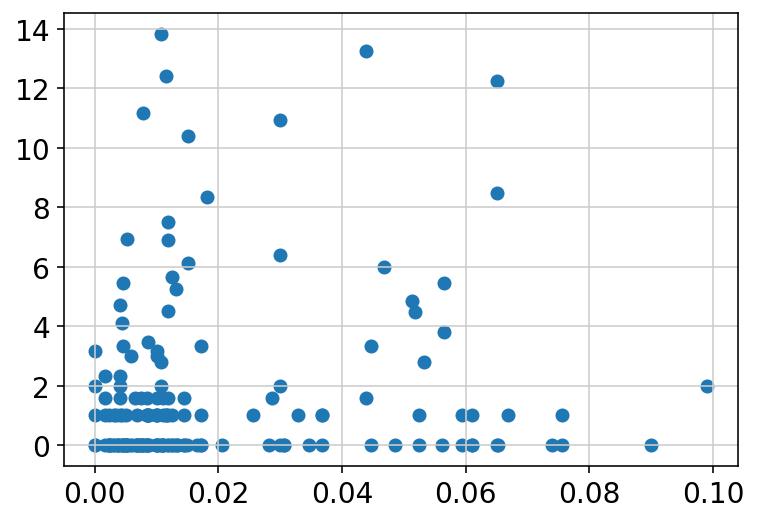

0.000327735


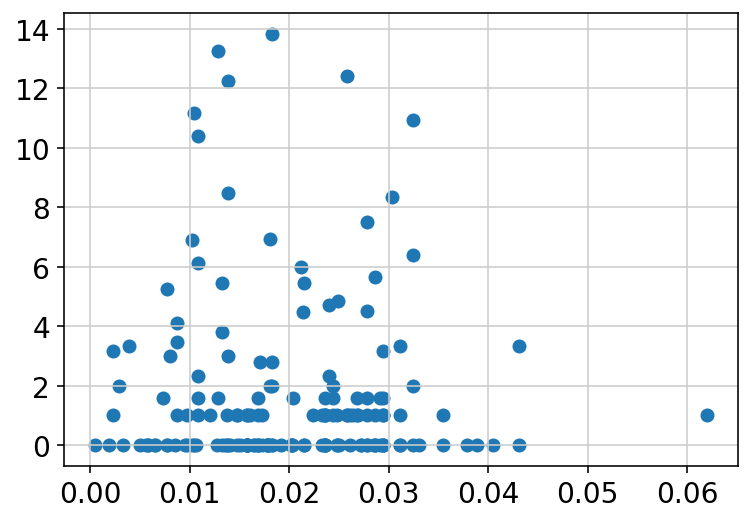

0.0


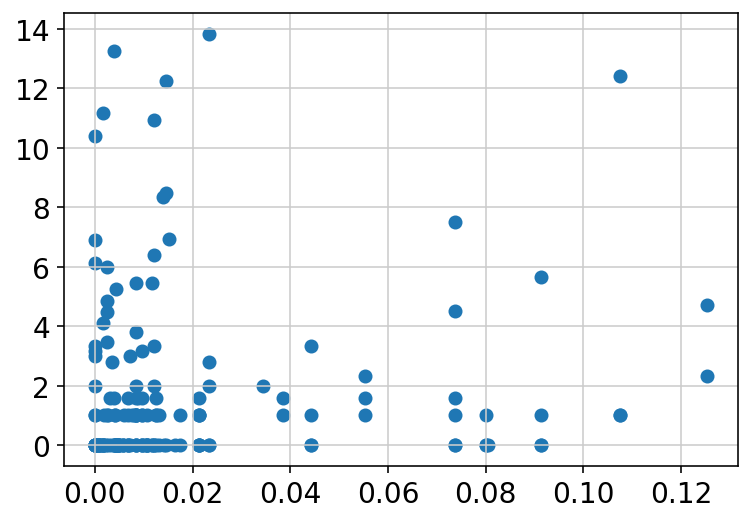

0.0


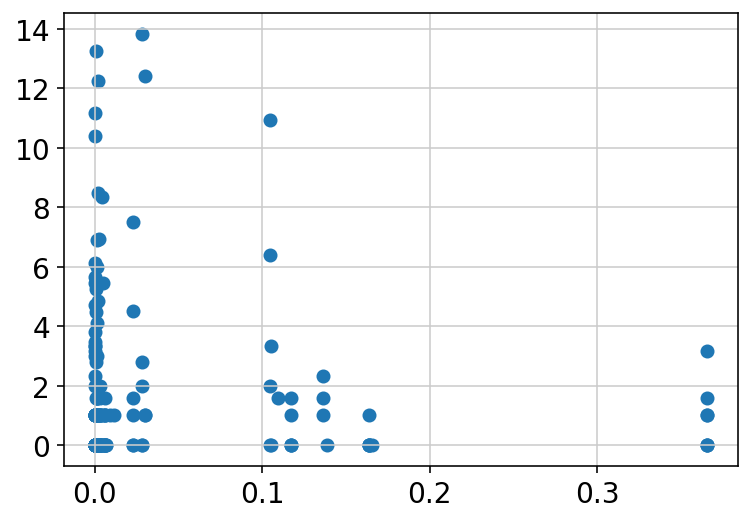

2.5653000000000003e-05


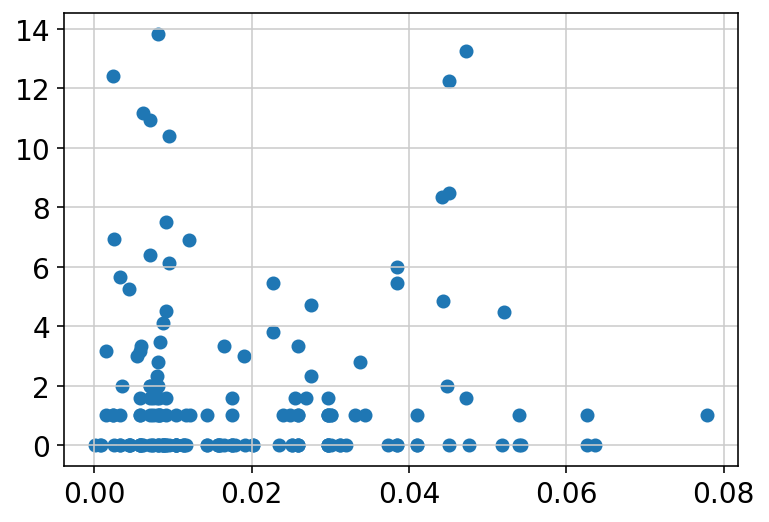

0.0


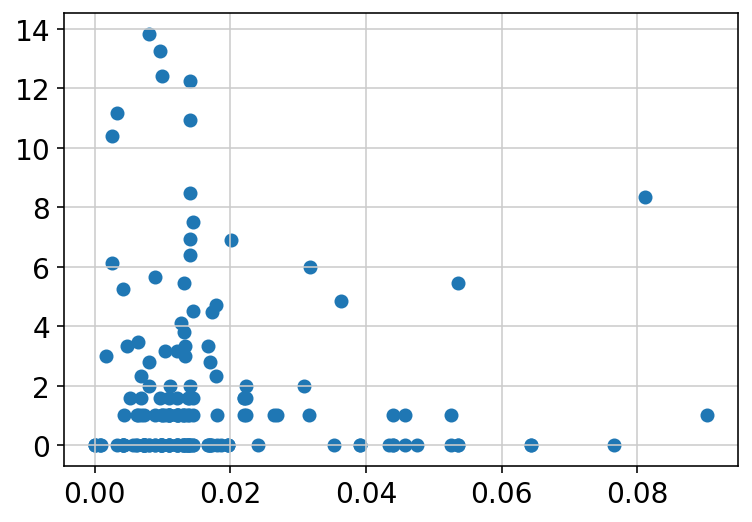

0.0


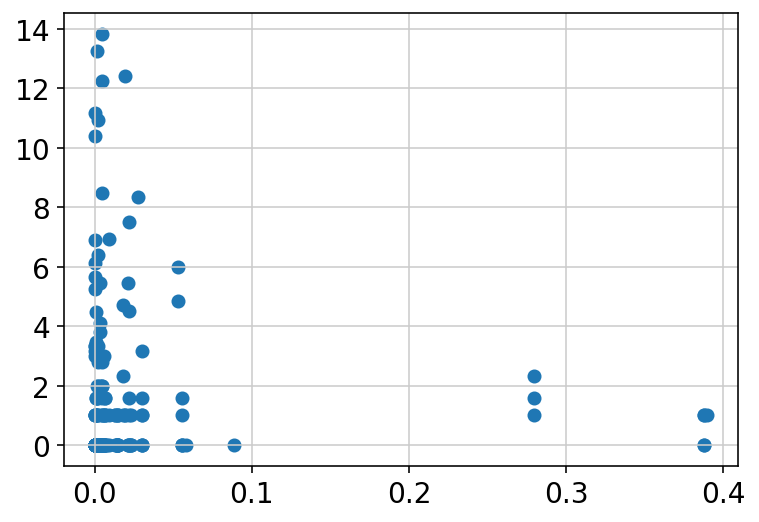

0.0


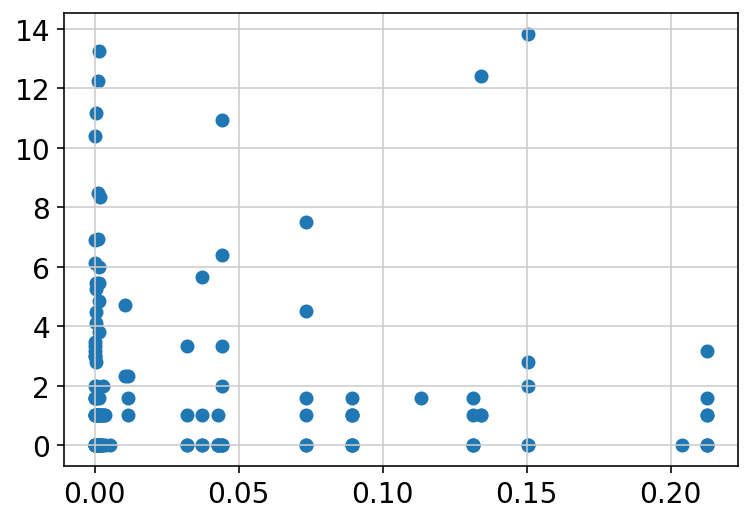

0.0


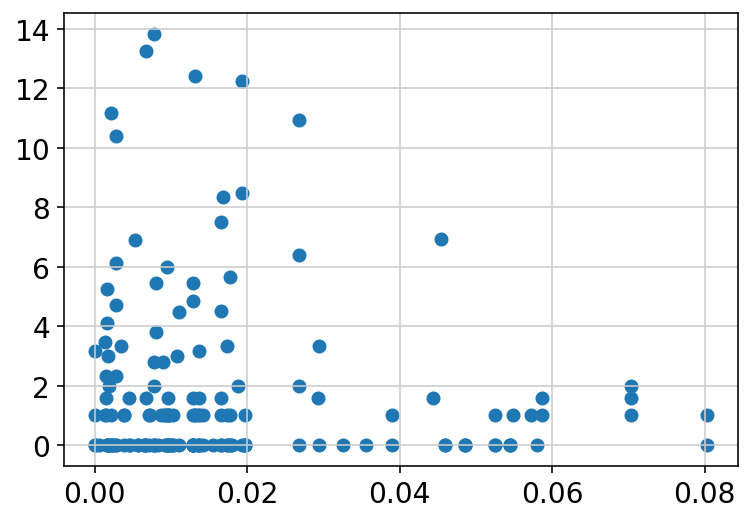

0.0


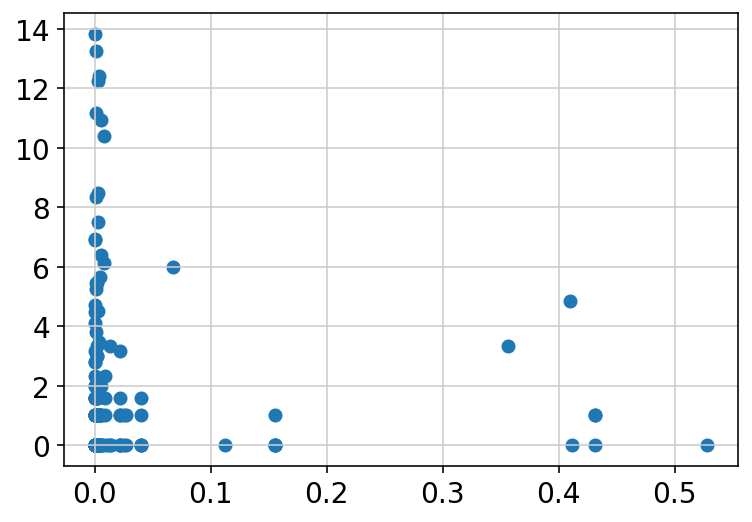

0.0


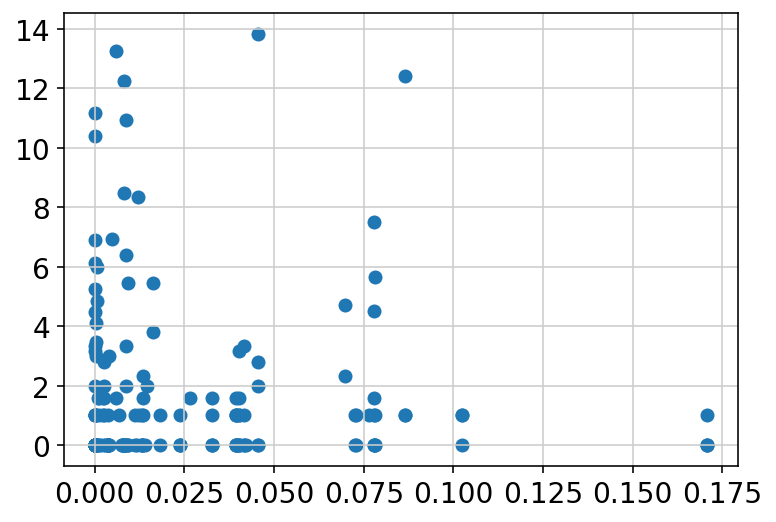

0.0


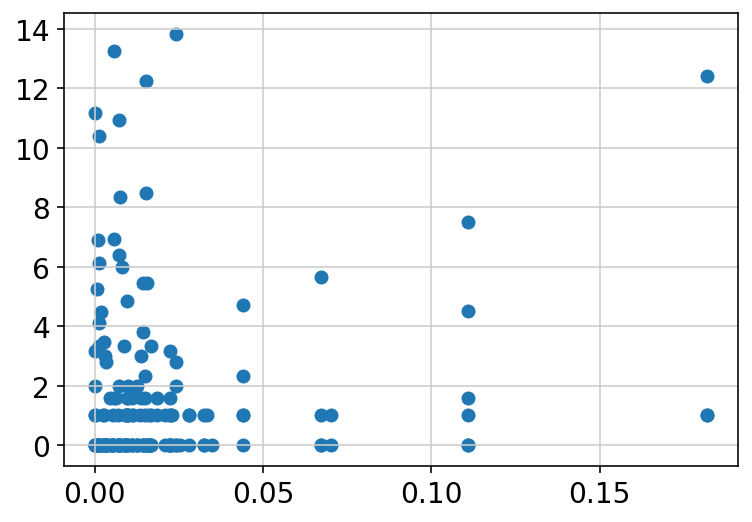

0.0


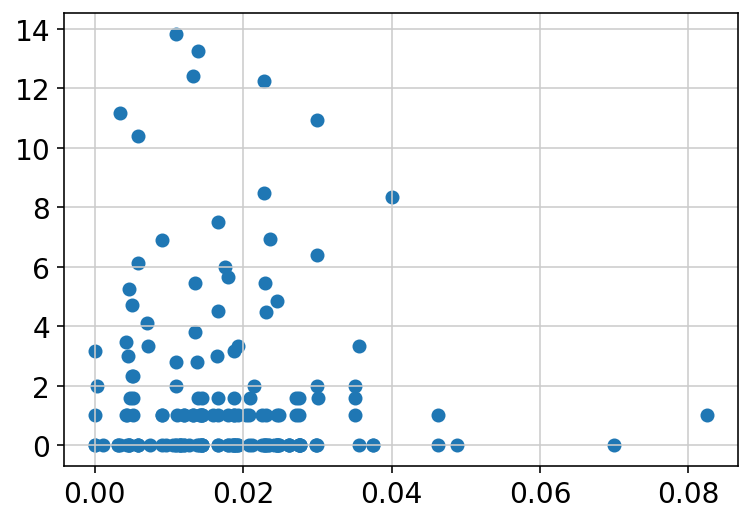

8.54569e-06


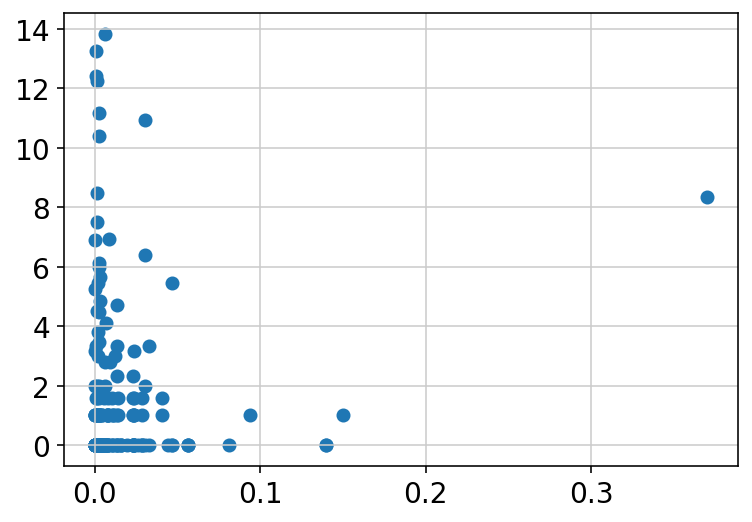

9.204309999999999e-07


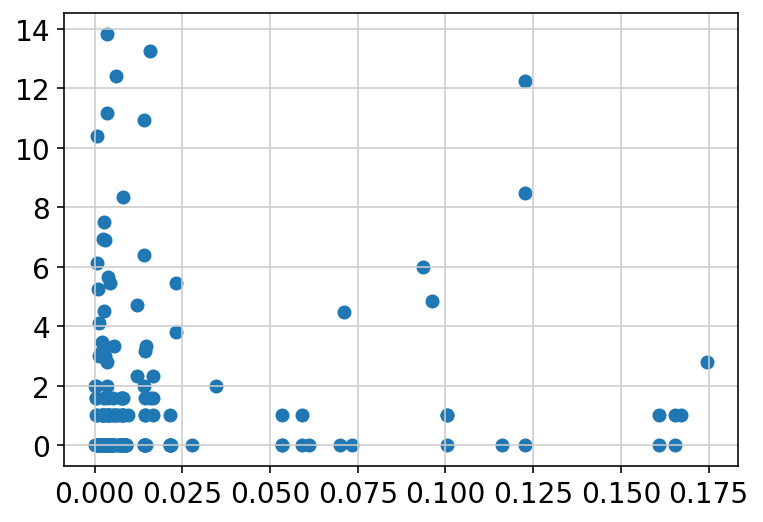

0.0


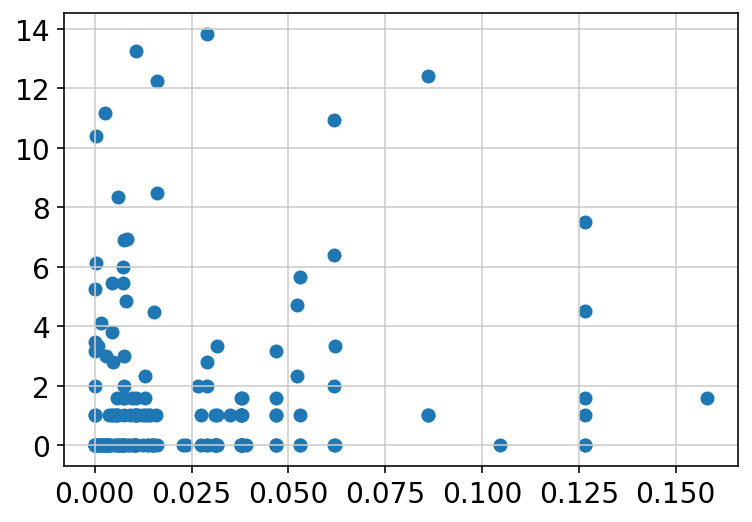

0.0


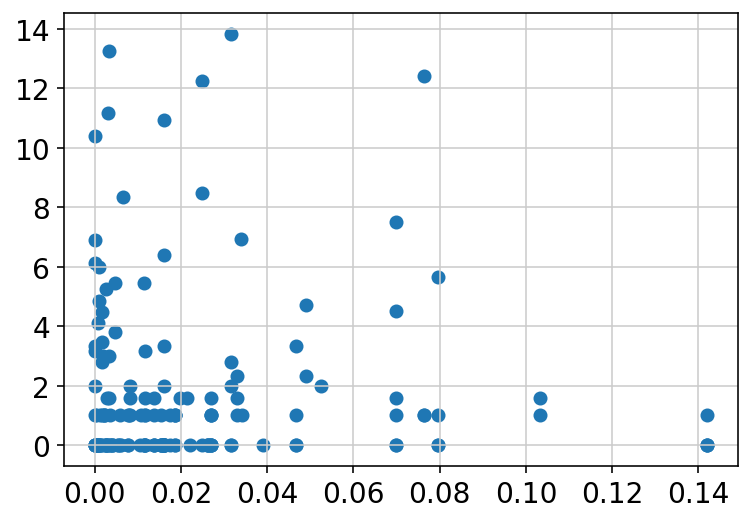

0.0


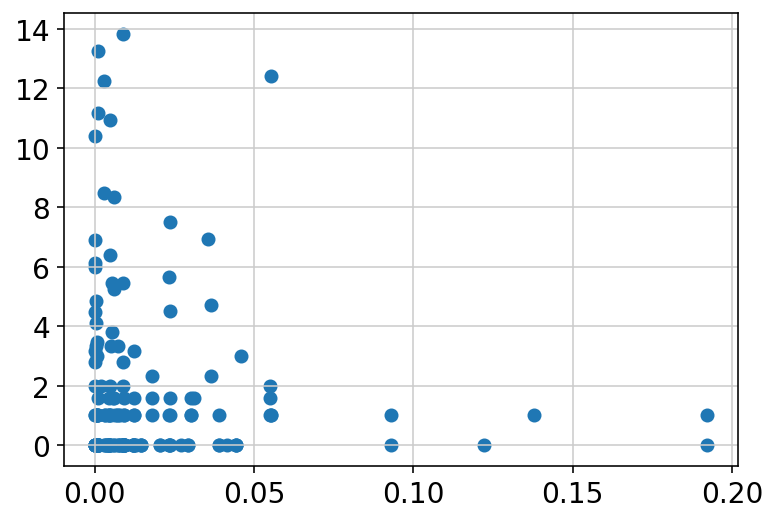

0.0


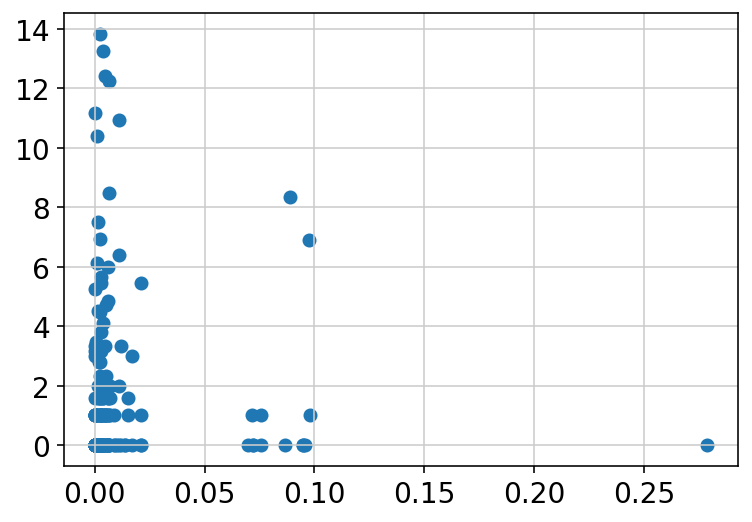

0.0


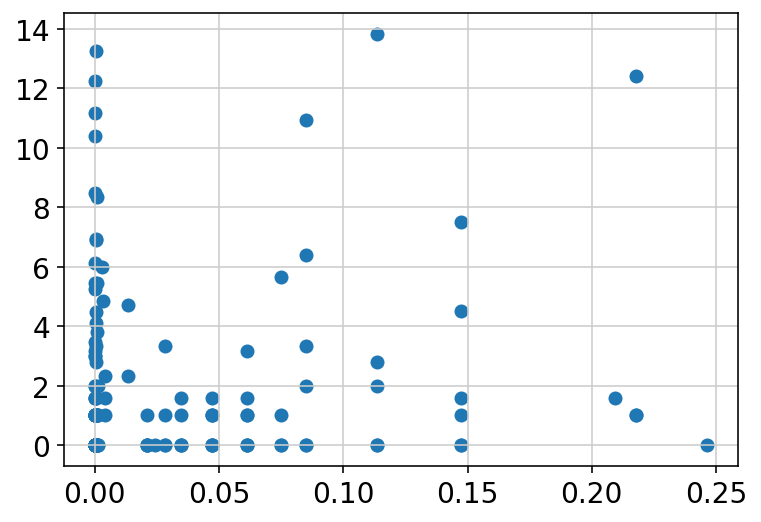

0.0


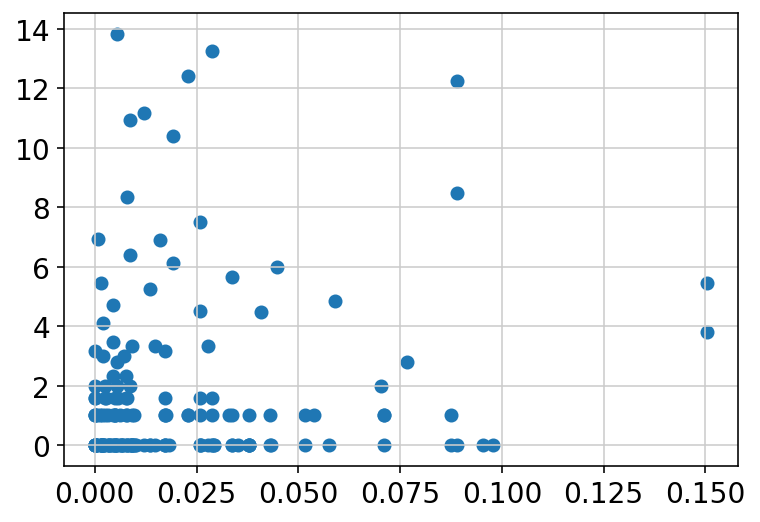

0.0


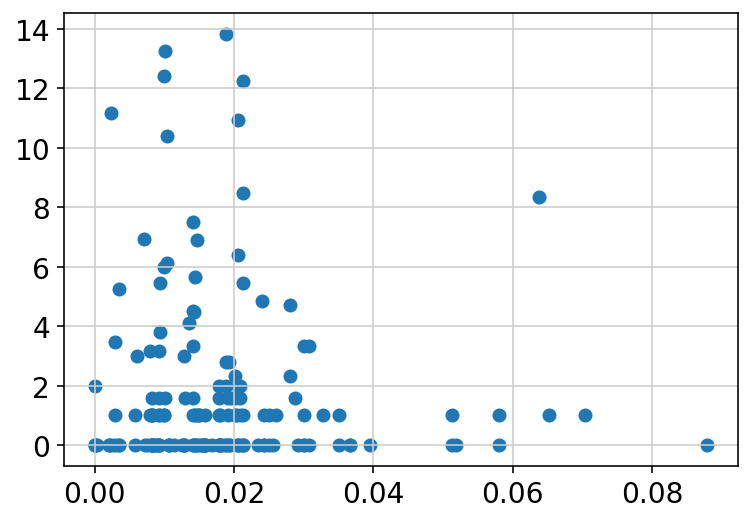

6.197e-09


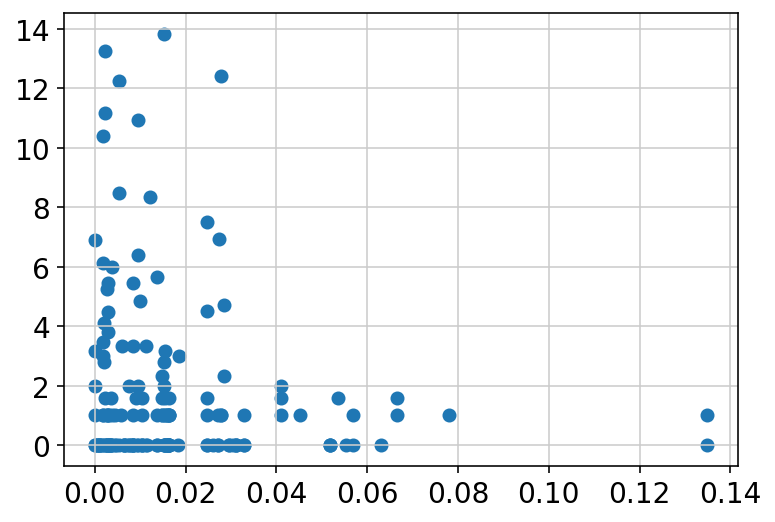

0.0


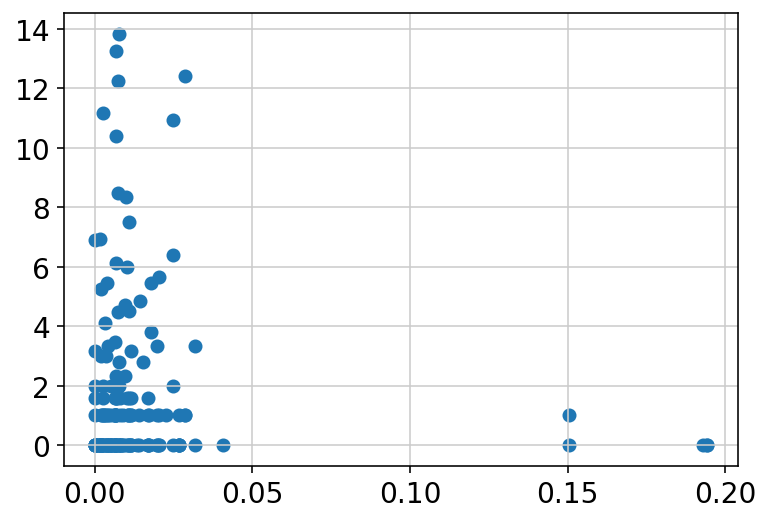

0.0


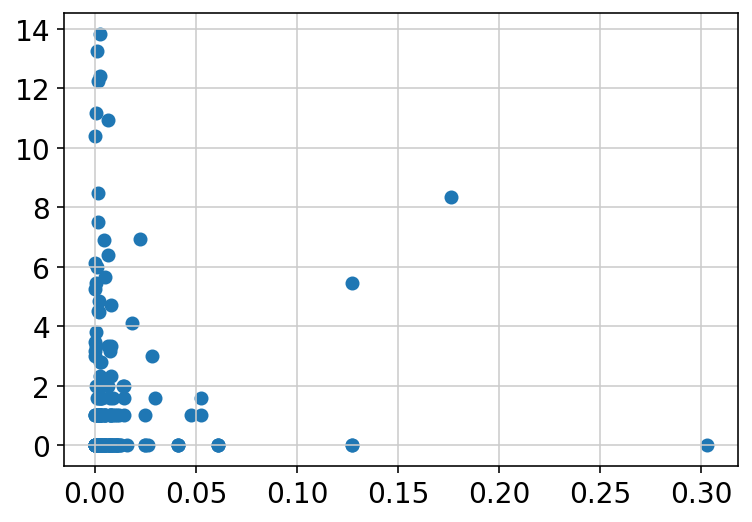

0.0


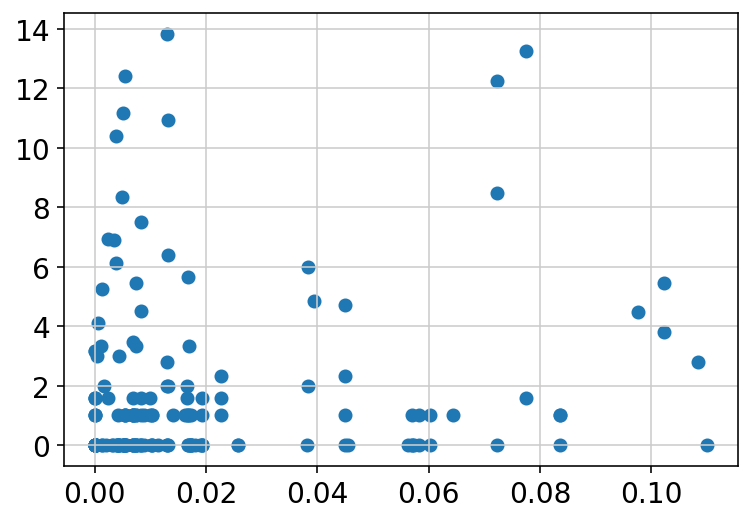

0.0


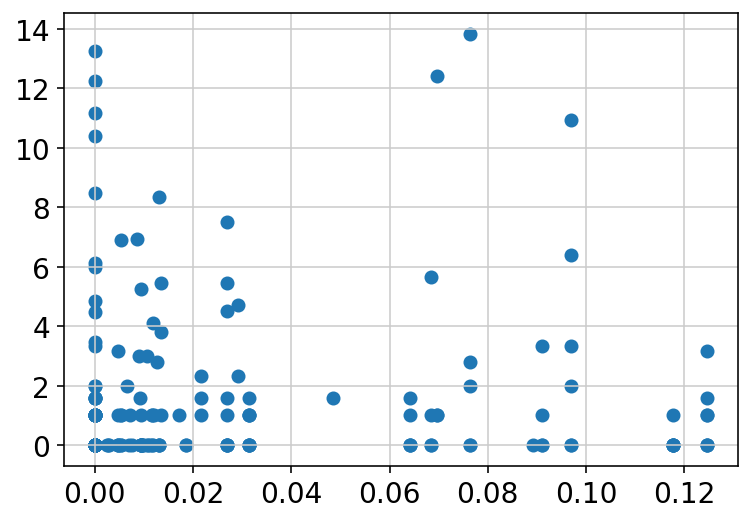

In [53]:
for signature in ['Signature_1', 'Signature_2', 'Signature_3',
       'Signature_4', 'Signature_5', 'Signature_6', 'Signature_7',
       'Signature_8', 'Signature_9', 'Signature_10', 'Signature_11',
       'Signature_12', 'Signature_13', 'Signature_14', 'Signature_15',
       'Signature_16', 'Signature_17', 'Signature_18', 'Signature_19',
       'Signature_20', 'Signature_21', 'Signature_22', 'Signature_23',
       'Signature_24', 'Signature_25', 'Signature_26', 'Signature_27',
       'Signature_28', 'Signature_29', 'Signature_30']:
    print(np.min(data[signature]))
    plt.scatter(np.log2(data[signature]+1),np.log2(data['COSMIC.1']))
    plt.show()

In [45]:
#===================================================================================

signature_cols=['Signature_1', 'Signature_2', 'Signature_3',
       'Signature_4', 'Signature_5', 'Signature_6', 'Signature_7',
       'Signature_8', 'Signature_9', 'Signature_10', 'Signature_11',
       'Signature_12', 'Signature_13', 'Signature_14', 'Signature_15',
       'Signature_16', 'Signature_17', 'Signature_18', 'Signature_19',
       'Signature_20', 'Signature_21', 'Signature_22', 'Signature_23',
       'Signature_24', 'Signature_25', 'Signature_26', 'Signature_27',
       'Signature_28', 'Signature_29', 'Signature_30']
signature_cols=['Signature_1']
#signature_cols=[]
impact_cols=['HotellingT2']
pheno_cols=['Z-Low-D7']
yname='COSMIC.1'


#record model performances here
performances=pd.DataFrame(columns=['condition','pearson','spearman','r2','fold'])

In [46]:
def get_positions_train_valid(data_pos,rng):
    
    positions=list(set(data_pos))
    train_positions=rng.choice(positions,size=int(len(positions)/2),replace=False)
    
    train_col=[]
    for j in range(len(data_pos)):
        curr_pos=data_pos[j]
        if curr_pos in train_positions:
            train_col.append(True)
        else:
            train_col.append(False)
    return(train_col)

def get_train_valid_datasets(data_here,
                            features,
                            training_pos_col,valid_pos_col,
                         training_y_name,valid_y_name,
                            offset_col=None):
    
    #subset data
    d={}
    d['x_train']=data_here.loc[data_here[training_pos_col]==True,features]
    d['y_train']=data_here.loc[data_here[training_pos_col]==True,training_y_name]
    d['x_valid']=data_here.loc[data_here[valid_pos_col]==True,features]
    d['y_valid']=data_here.loc[data_here[valid_pos_col]==True,valid_y_name]
    if offset_col is not None:
        d['offset_train']=data_here.loc[data_here[training_pos_col]==True,offset_col]
        d['offset_valid']=data_here.loc[data_here[valid_pos_col]==True,offset_col]
    return(d)


def get_model(d):
    import statsmodels.api as sm
    
    #train the model
    if 'offset_train' in d.keys():
        glm_binom=sm.GLM(d['y_train'], d['x_train'],family=sm.families.Poisson(),
                        offset=d['offset_train'])
    else:
        glm_binom = sm.GLM(d['y_train'], d['x_train'],family=sm.families.Poisson())
    res=glm_binom.fit_regularized()
    print('model',res.params)
    #res=glm_binom.fit()
    return(res)

def get_pred_by_position(y_here,data_with_position):
    df=pd.DataFrame(y_here,index=y_here.index)
    df['posi']=data_with_position.loc[df.index,'Position']
    #collapse to average
    pos_scores=df.groupby('posi').mean()
    pos_scores['pos']=pos_scores.index
    pos_scores=pos_scores.sort_values(by='pos')
    return(pos_scores)

def model_performance_by_position(y_true_train,y_true_valid,y_train_pred,y_valid_pred,data_with_position,ax1,ax2):
    y_true_train_pos=get_pred_by_position(y_true_train,data_with_position)
    ax1.plot(y_true_train_pos['pos'],y_true_train_pos.iloc[:,0],color='gray')
    
    y_true_valid_pos=get_pred_by_position(y_true_valid,data_with_position)
    ax2.plot(y_true_valid_pos['pos'],y_true_valid_pos.iloc[:,0],color='black')
    
    y_train_pos=get_pred_by_position(y_train_pred,data_with_position)
    ax1.plot(y_train_pos['pos'],-y_train_pos.iloc[:,0],color='deepskyblue')
    
    y_valid_pos=get_pred_by_position(y_valid_pred,data_with_position)
    ax2.plot(y_valid_pos['pos'],-y_valid_pos.iloc[:,0],color='blue')
    
    ax1.grid(False)
    ax2.grid(False)
    
def model_performance(x,y,model_res,toprint,ax,mycolor,log_it=True):
    #should return the predictions
    y_pred=model_res.predict(x)
    y2=y
    y2_pred=y_pred
    
    pred_df=pd.DataFrame({'obs':y,
                         'pred':y_pred})
    if log_it:
        y2=np.log10(y+1)
        y2_pred=np.log10(y_pred+1)
    
    from scipy.stats import spearmanr,pearsonr
    from sklearn.metrics import r2_score
    print('y2',y2,'y2pred',y2_pred)
    p=pearsonr(y2,y2_pred)[0]
    p=str(int(100*p)/100)
    r2=r2_score(y2,y2_pred)
    r2=str(int(100*r2)/100)
    sp=spearmanr(y2,y2_pred)[0]
    sp=str(int(100*sp)/100)
    
    return(y_pred,p,sp,r2,pred_df)

def model_full(data_here,
               features,
                training_pos_col,valid_pos_col,
                training_y_name,valid_y_name,
                offset_col=None,
              toprint=''):
    
    import copy
    
    fig,plots=plt.subplots(1,5)
    fig.set_size_inches(25,3)
    
    
    d_here={}
    
    #setup dataset, training, test
    d_here['data']=get_train_valid_datasets(data_here,
                features,
                training_pos_col,valid_pos_col,
                training_y_name,valid_y_name,
                offset_col)
    
    #train the model
    d_here['model']=get_model(d_here['data'])
    
    #get the model performance, for the training and validation sets
    d_here['pred_train'],p_train,sp_train,r2_train,y_train_pred=model_performance(d_here['data']['x_train'],
                                     d_here['data']['y_train'],
                                     d_here['model'],
                                   'training',
                                    plots[0],'lightblue')
    
    d_here['pred_valid'],p_valid,sp_valid,r2_valid,y_valid_pred=model_performance(d_here['data']['x_valid'],
                                     d_here['data']['y_valid'],
                                     d_here['model'],
                                   toprint+'\ntrain: '+str(d_here['data']['x_train'].shape[0])+
                                            ', test: '+str(d_here['data']['x_valid'].shape[0])+'\nvalidation',
                                    plots[1],'blue')
    
    #make a prediction with the model on the entire dataset
    data_here_cp=copy.deepcopy(data_here)
    data_here_cp['all']=True
    totals={}
    totals['data']=get_train_valid_datasets(data_here_cp,
                features,
                'all','all',
                training_y_name,valid_y_name,
                offset_col)
    
    #######
    '''
    data_here_cp[toprint],p_total,sp_total,r2_total,y_total_pred=model_performance(totals['data']['x_valid'],
                                     totals['data']['y_valid'],
                                     d_here['model'],
                                   'all data',
                                    plots[2],'purple')
    '''
    
    model_performance_by_position(d_here['data']['y_train'],
                                  d_here['data']['y_valid'],
                                  y_train_pred,
                                  y_valid_pred,
                                  data_here,
                                  plots[3],plots[4])
    
    performance_here=pd.DataFrame({'condition':toprint,
                                  'pearson':p_valid,
                                  'spearman':sp_valid,
                                  'r2':r2_valid},index=[0])
    plt.show()
    
    to_return={}
    #to_return['dataset']=data_here_cp
    to_return['model']=d_here['model']
    to_return['obs_train']=d_here['data']['y_train']
    to_return['obs_valid']=d_here['data']['y_valid']
    to_return['pred_train']=d_here['pred_train']
    to_return['pred_valid']=d_here['pred_valid']
    to_return['obs_all']=totals['data']['y_valid']
    #to_return['pred_all']=data_here_cp[toprint]
    return(to_return,p_valid,sp_valid,r2_valid,performance_here)

def plot_performance(preds,titlename='',mini=-0.5,maxi=5):
    fig,ax=plt.subplots(1)
    fig.set_size_inches(2,2)
    
    for item in ['train','valid']:
        if item=='train':
            c='lightgray'
        if item=='valid':
            c='black'
        ax.scatter(np.log10(preds['pred_'+item]+1),
            np.log10(preds['obs_'+item].loc[preds['pred_'+item].index]+1),s=5,color=c,
                          alpha=0.5)

        ###ax.set_xlim(mini,maxi)
        ###ax.set_ylim(mini,maxi)        
        ###ax.set_xticks([])
        
        ax.set_yticks([0,maxi/2,maxi])
        ax.set_ylabel('observed counts\n(log10(counts+1))')
        ax.set_ylabel('')
        ax.grid(False)
        
    ax.set_xticks([0,maxi/2,maxi])
    ax.set_xlabel('predicted counts\n(log10(counts+1))')
    ax.set_title(titlename)
    ax.set_ylabel('observed counts\nlog10(counts+1)')
    return(ax)

Comparing models
====

=============== iteration 0
model Signature_1    16.779343
Z-Low-D7        0.812988
dtype: float64
y2 Mutation
A146T    2.260071
Q61H     2.513218
Q61L     2.082785
Q61R     2.089905
Q61K     1.806180
L19F     1.477121
K117N    1.653213
A146V    1.707570
D33E     0.954243
A146P    1.079181
E63K     1.000000
K5E      0.698970
I36M     0.602060
R135T    0.301030
Q61E     1.041393
D92Y     0.477121
I21R     0.301030
T20R     0.301030
E62K     0.301030
Q61P     1.255273
A18D     1.176091
G10R     1.041393
G60D     0.903090
T20M     0.778151
E31K     0.778151
G60V     0.602060
E49K     0.602060
K117E    0.602060
G10E     0.602060
V9D      0.602060
           ...   
V7M      0.301030
T74P     0.301030
K16R     0.301030
M72I     0.301030
A134T    0.301030
N26S     0.301030
G77S     0.301030
S145L    0.301030
P121H    0.301030
E31Q     0.301030
D69G     0.301030
D126V    0.301030
V109L    0.301030
F28S     0.301030
E3G      0.301030
I93F     0.301030
G60R     0.301030
V114I    0.301030
L6H    

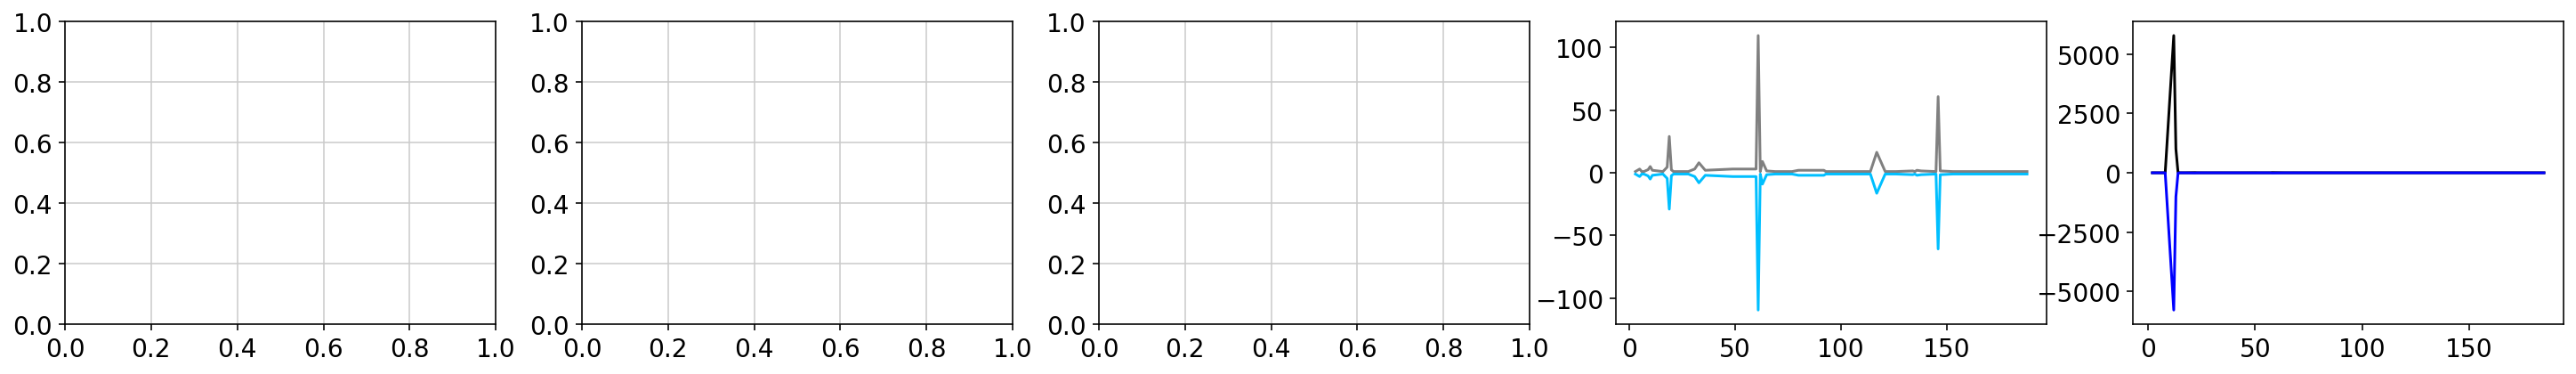

model name Cell. + 
 Mut. + 
 sc-eVIP - 
Train L 
 Test L
mut pred === Mutation
G12D     1.271664
G12V     1.165931
G12C     1.117031
G13D     1.577359
G12A     1.044257
G12R     1.021795
A146T    1.345579
Q61H     1.086384
G12S     1.419960
G13C     1.117031
Q61L     1.018459
Q61R     1.149924
Q61K     1.228198
L19F     1.267450
K117N    1.213233
A146V    1.519742
Q22K     1.204690
G13V     1.101437
D33E     1.072210
A59G     1.010154
R164Q    3.579658
A59T     1.345579
A146P    1.015047
E63K     1.345374
R68S     1.144516
K5E      1.145075
I36M     1.072596
P110S    1.271664
C118S    1.080459
R135T    1.054305
           ...   
N86K     1.098689
T2I      1.235923
F28S     1.110700
E91G     1.084917
E3G      1.084917
R73S     1.248552
I93F     1.069807
G60R     1.023452
D30E     1.035563
V114I    1.235923
L6H      1.037245
S65I     1.110267
G77A     1.040976
E62G     1.092136
C185R    1.087108
H27L     1.048295
A18G     1.040976
M188L    1.098689
R149G    1.119244
P34Q     1.117031
H2

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:115: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


model Z-Low-D7    0.829618
dtype: float64
y2 Mutation
A146T    2.260071
Q61H     2.513218
Q61L     2.082785
Q61R     2.089905
Q61K     1.806180
L19F     1.477121
K117N    1.653213
A146V    1.707570
D33E     0.954243
A146P    1.079181
E63K     1.000000
K5E      0.698970
I36M     0.602060
R135T    0.301030
Q61E     1.041393
D92Y     0.477121
I21R     0.301030
T20R     0.301030
E62K     0.301030
Q61P     1.255273
A18D     1.176091
G10R     1.041393
G60D     0.903090
T20M     0.778151
E31K     0.778151
G60V     0.602060
E49K     0.602060
K117E    0.602060
G10E     0.602060
V9D      0.602060
           ...   
V7M      0.301030
T74P     0.301030
K16R     0.301030
M72I     0.301030
A134T    0.301030
N26S     0.301030
G77S     0.301030
S145L    0.301030
P121H    0.301030
E31Q     0.301030
D69G     0.301030
D126V    0.301030
V109L    0.301030
F28S     0.301030
E3G      0.301030
I93F     0.301030
G60R     0.301030
V114I    0.301030
L6H      0.301030
S65I     0.301030
G77A     0.301030
E62G     0

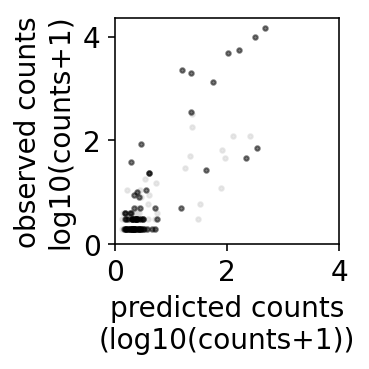

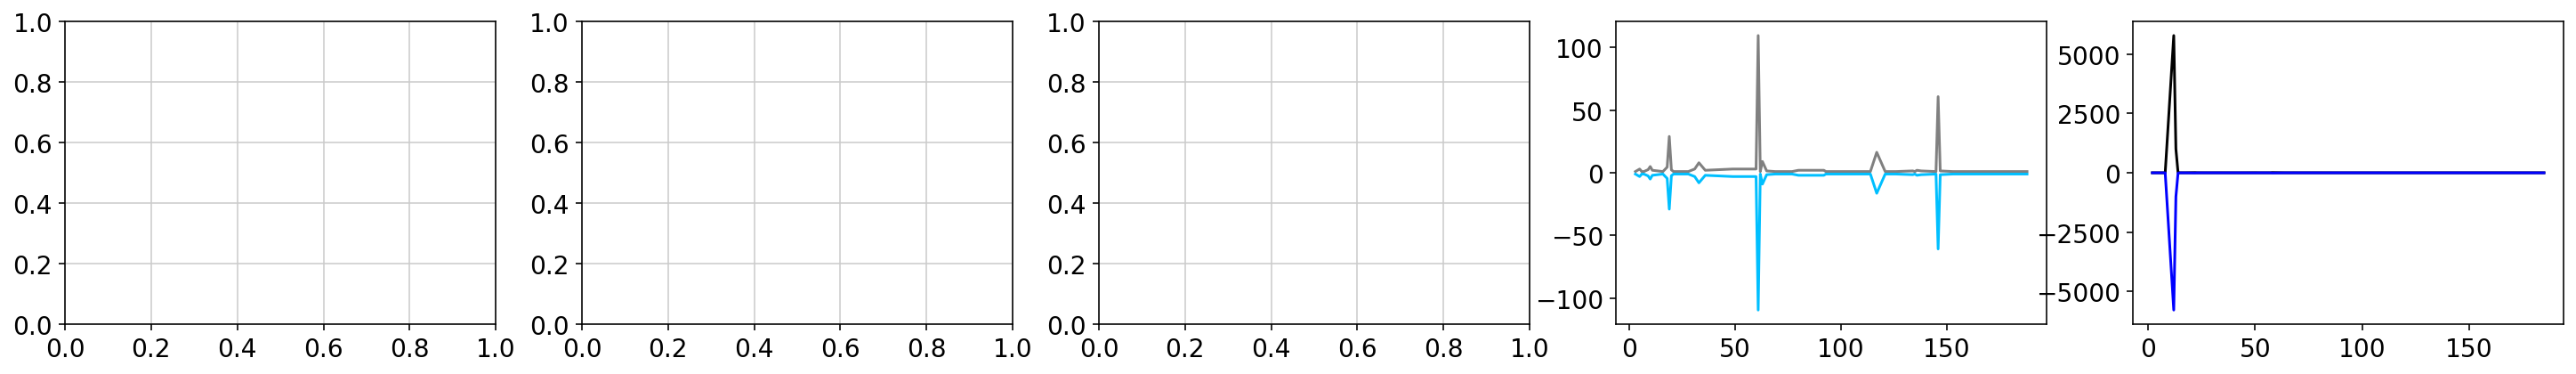

                                           condition pearson spearman    r2
0  Cell. + \n Mut. - \n sc-eVIP - \nTrain L \n Te...    0.83     0.45  0.55
model Signature_1    16.779343
Z-Low-D7        0.812988
dtype: float64
y2 Mutation
A146T    2.260071
Q61H     2.513218
Q61L     2.082785
Q61R     2.089905
Q61K     1.806180
L19F     1.477121
K117N    1.653213
A146V    1.707570
D33E     0.954243
A146P    1.079181
E63K     1.000000
K5E      0.698970
I36M     0.602060
R135T    0.301030
Q61E     1.041393
D92Y     0.477121
I21R     0.301030
T20R     0.301030
E62K     0.301030
Q61P     1.255273
A18D     1.176091
G10R     1.041393
G60D     0.903090
T20M     0.778151
E31K     0.778151
G60V     0.602060
E49K     0.602060
K117E    0.602060
G10E     0.602060
V9D      0.602060
           ...   
V7M      0.301030
T74P     0.301030
K16R     0.301030
M72I     0.301030
A134T    0.301030
N26S     0.301030
G77S     0.301030
S145L    0.301030
P121H    0.301030
E31Q     0.301030
D69G     0.301030
D126V    

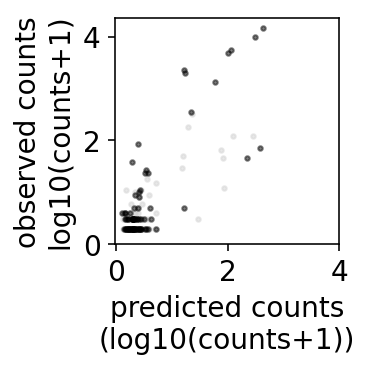

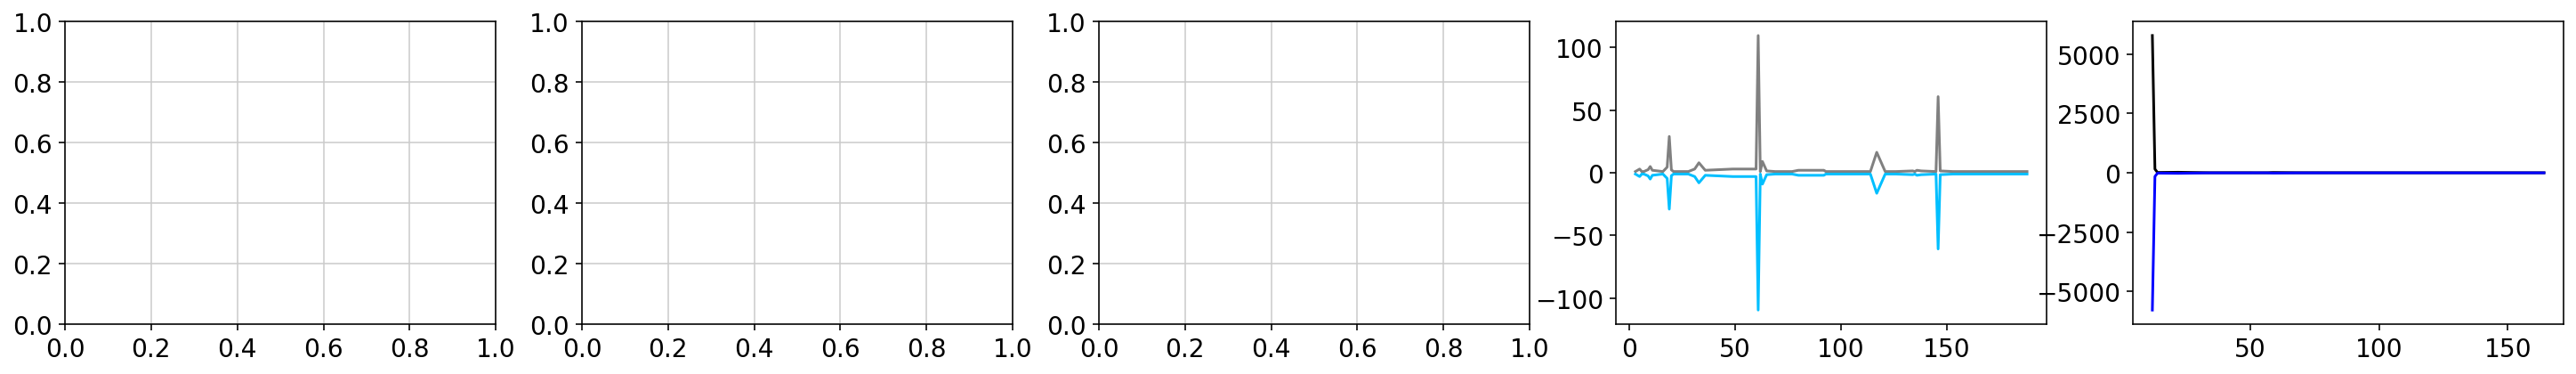

                                           condition pearson spearman    r2
0  Cell. + \n Mut. + \n sc-eVIP - \nTrain L \n Te...     0.8     0.81  0.43
model Z-Low-D7    0.829618
dtype: float64
y2 Mutation
A146T    2.260071
Q61H     2.513218
Q61L     2.082785
Q61R     2.089905
Q61K     1.806180
L19F     1.477121
K117N    1.653213
A146V    1.707570
D33E     0.954243
A146P    1.079181
E63K     1.000000
K5E      0.698970
I36M     0.602060
R135T    0.301030
Q61E     1.041393
D92Y     0.477121
I21R     0.301030
T20R     0.301030
E62K     0.301030
Q61P     1.255273
A18D     1.176091
G10R     1.041393
G60D     0.903090
T20M     0.778151
E31K     0.778151
G60V     0.602060
E49K     0.602060
K117E    0.602060
G10E     0.602060
V9D      0.602060
           ...   
V7M      0.301030
T74P     0.301030
K16R     0.301030
M72I     0.301030
A134T    0.301030
N26S     0.301030
G77S     0.301030
S145L    0.301030
P121H    0.301030
E31Q     0.301030
D69G     0.301030
D126V    0.301030
V109L    0.301030
F2

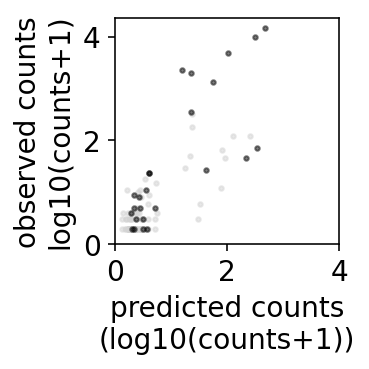

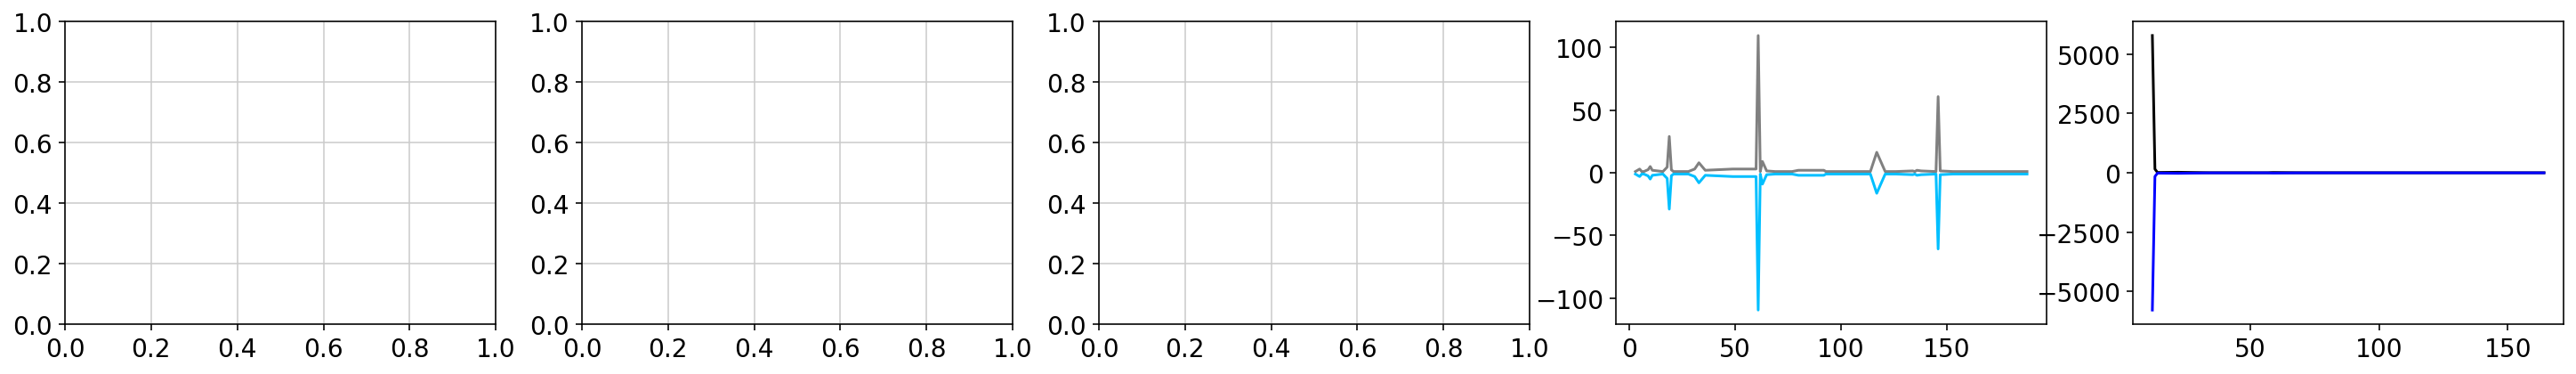

                                           condition pearson spearman    r2
0  Cell. + \n Mut. - \n sc-eVIP - \nTrain L \n Te...    0.81      0.8  0.38
model Signature_1    16.478869
Z-Low-D7        0.814136
dtype: float64
y2 Mutation
A146T    2.260071
Q61H     2.513218
Q61L     2.082785
Q61R     2.089905
Q61K     1.806180
L19F     1.477121
K117N    1.653213
A146V    1.707570
D33E     0.954243
A146P    1.079181
E63K     1.000000
K5E      0.698970
I36M     0.602060
R135T    0.301030
T20R     0.301030
Q61P     1.255273
G60D     0.903090
T20M     0.778151
E31K     0.778151
G60V     0.602060
K117R    0.477121
K147N    0.477121
S136N    0.477121
G77A     0.301030
Name: COSMIC.1, dtype: float64 y2pred Mutation
A146T    1.379108
Q61H     1.372973
Q61L     2.417309
Q61R     2.117180
Q61K     1.920893
L19F     1.257235
K117N    1.961162
A146V    1.344215
D33E     0.608622
A146P    1.899961
E63K     0.415098
K5E      0.399084
I36M     0.348357
R135T    0.334736
T20R     0.127742
Q61P     0.54802

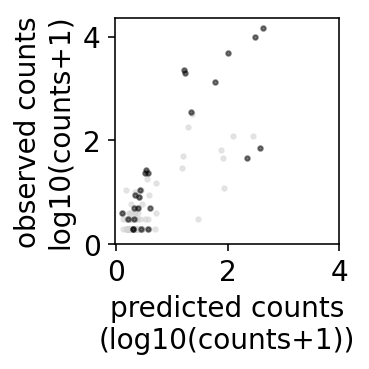

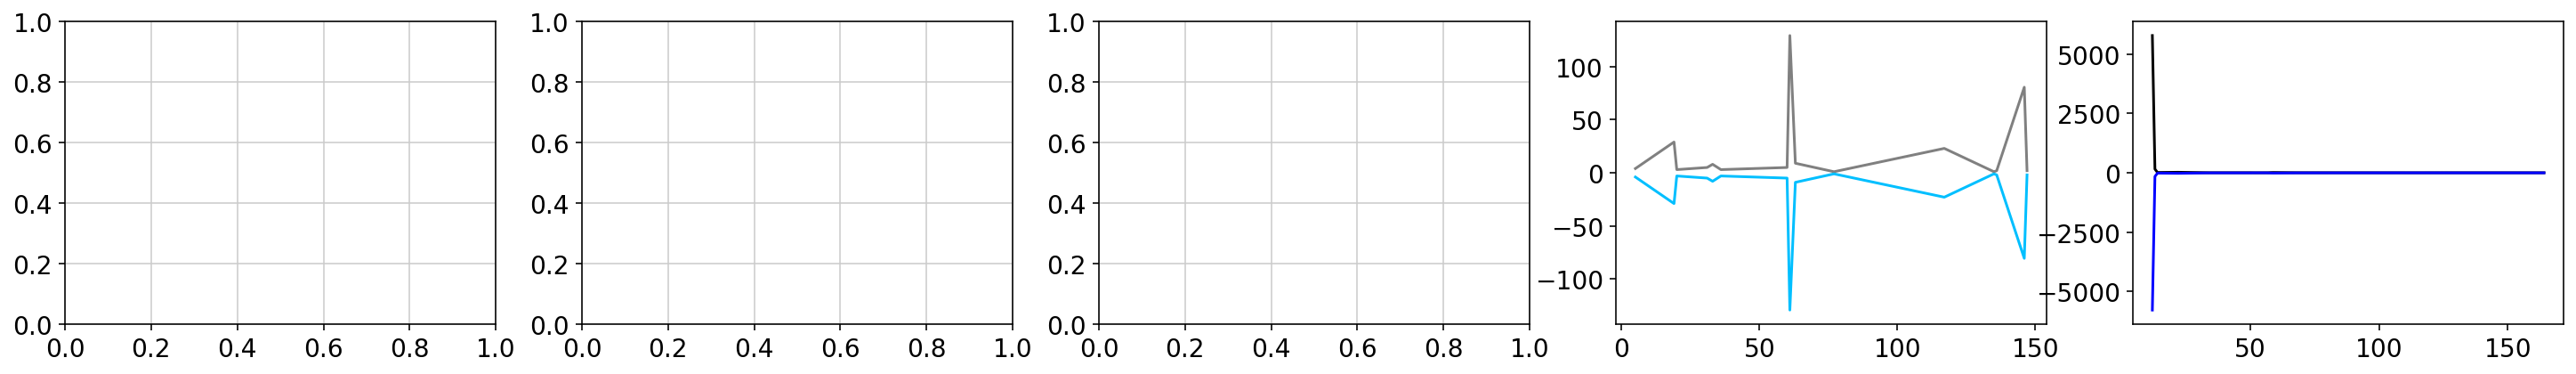

                                           condition pearson spearman    r2
0  Cell. + \n Mut. + \n sc-eVIP - \nTrain S \n Te...     0.8     0.81  0.44
model Z-Low-D7    0.830267
dtype: float64
y2 Mutation
A146T    2.260071
Q61H     2.513218
Q61L     2.082785
Q61R     2.089905
Q61K     1.806180
L19F     1.477121
K117N    1.653213
A146V    1.707570
D33E     0.954243
A146P    1.079181
E63K     1.000000
K5E      0.698970
I36M     0.602060
R135T    0.301030
T20R     0.301030
Q61P     1.255273
G60D     0.903090
T20M     0.778151
E31K     0.778151
G60V     0.602060
K117R    0.477121
K147N    0.477121
S136N    0.477121
G77A     0.301030
Name: COSMIC.1, dtype: float64 y2pred Mutation
A146T    1.281742
Q61H     1.364160
Q61L     2.457072
Q61R     2.098449
Q61K     1.870098
L19F     1.183310
K117N    1.916374
A146V    1.196802
D33E     0.593112
A146P    1.930625
E63K     0.342503
K5E      0.366640
I36M     0.332760
R135T    0.323203
T20R     0.124327
Q61P     0.543139
G60D     0.402640
T20M     

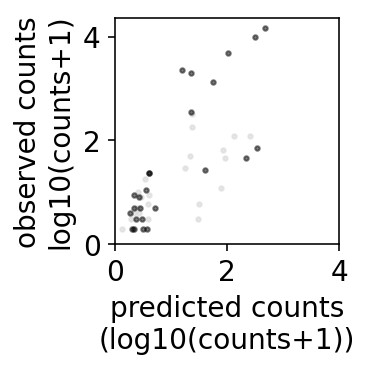

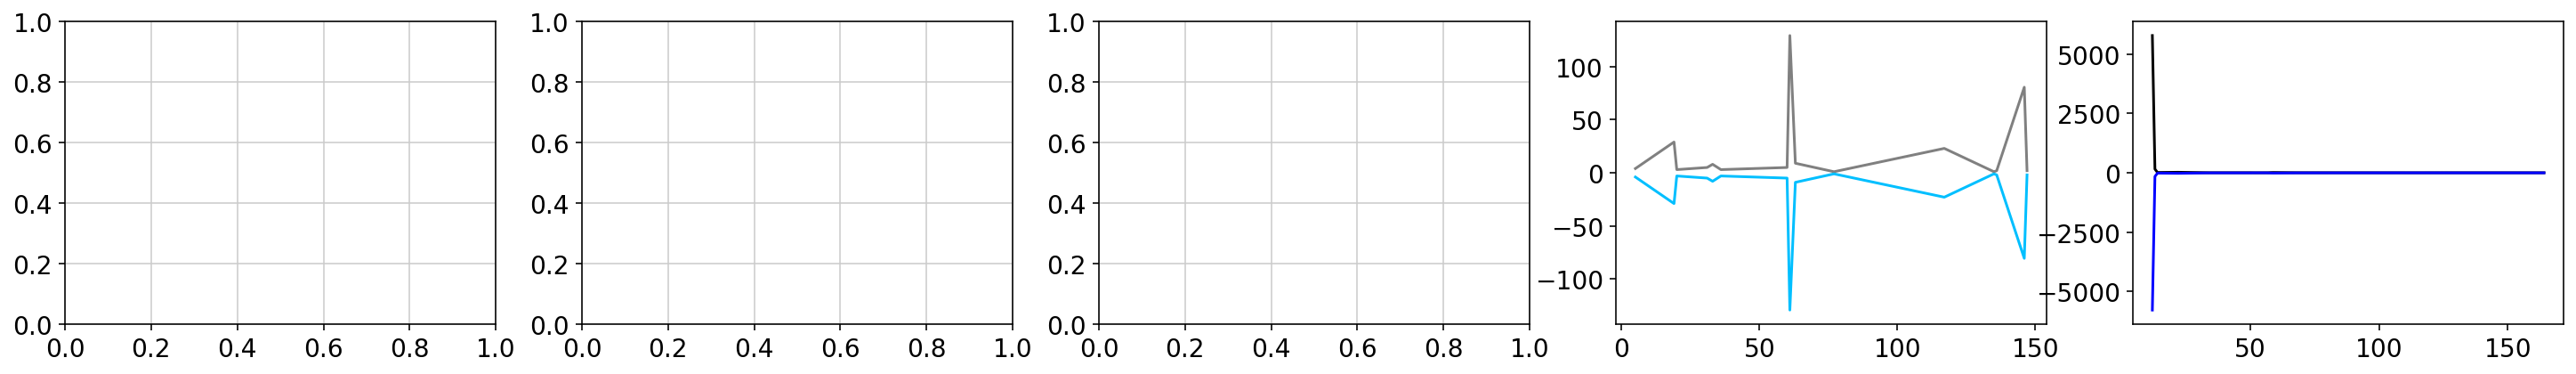

                                           condition pearson spearman    r2
0  Cell. + \n Mut. - \n sc-eVIP - \nTrain S \n Te...    0.81      0.8  0.38
model Signature_1   NaN
HotellingT2   NaN
dtype: float64
y2 Mutation
A146T    2.260071
Q61H     2.513218
Q61L     2.082785
Q61R     2.089905
Q61K     1.806180
L19F     1.477121
K117N    1.653213
A146V    1.707570
D33E     0.954243
A146P    1.079181
E63K     1.000000
K5E      0.698970
I36M     0.602060
R135T    0.301030
T20R     0.301030
Q61P     1.255273
G60D     0.903090
T20M     0.778151
E31K     0.778151
G60V     0.602060
K117R    0.477121
K147N    0.477121
S136N    0.477121
G77A     0.301030
Name: COSMIC.1, dtype: float64 y2pred Mutation
A146T   NaN
Q61H    NaN
Q61L    NaN
Q61R    NaN
Q61K    NaN
L19F    NaN
K117N   NaN
A146V   NaN
D33E    NaN
A146P   NaN
E63K    NaN
K5E     NaN
I36M    NaN
R135T   NaN
T20R    NaN
Q61P    NaN
G60D    NaN
T20M    NaN
E31K    NaN
G60V    NaN
K117R   NaN
K147N   NaN
S136N   NaN
G77A    NaN
dtype: float

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:460: RuntimeWarning: divide by zero encountered in log
  return var_weights / scale * (endog * np.log(mu) - mu -
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/statsmodels/genmod/families/links.py:517: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:460: RuntimeWarning: invalid value encountered in subtract
  return var_weights / scale * (endog * np.log(mu) - mu -
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/statsmodels/genmod/generalized_linear_model.py:485: RuntimeWarning: overflow encountered in true_divide
  score_factor = (self.endog - mu) / self.family.link.deriv(mu)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/statsmodels/genmod/generalized_linear_model.py:486:

ValueError: array must not contain infs or NaNs

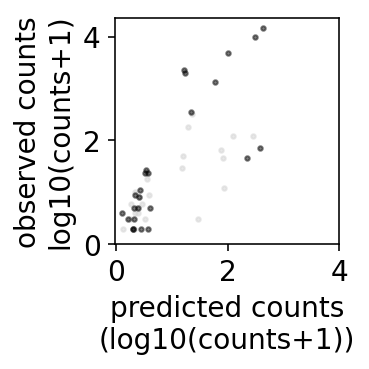

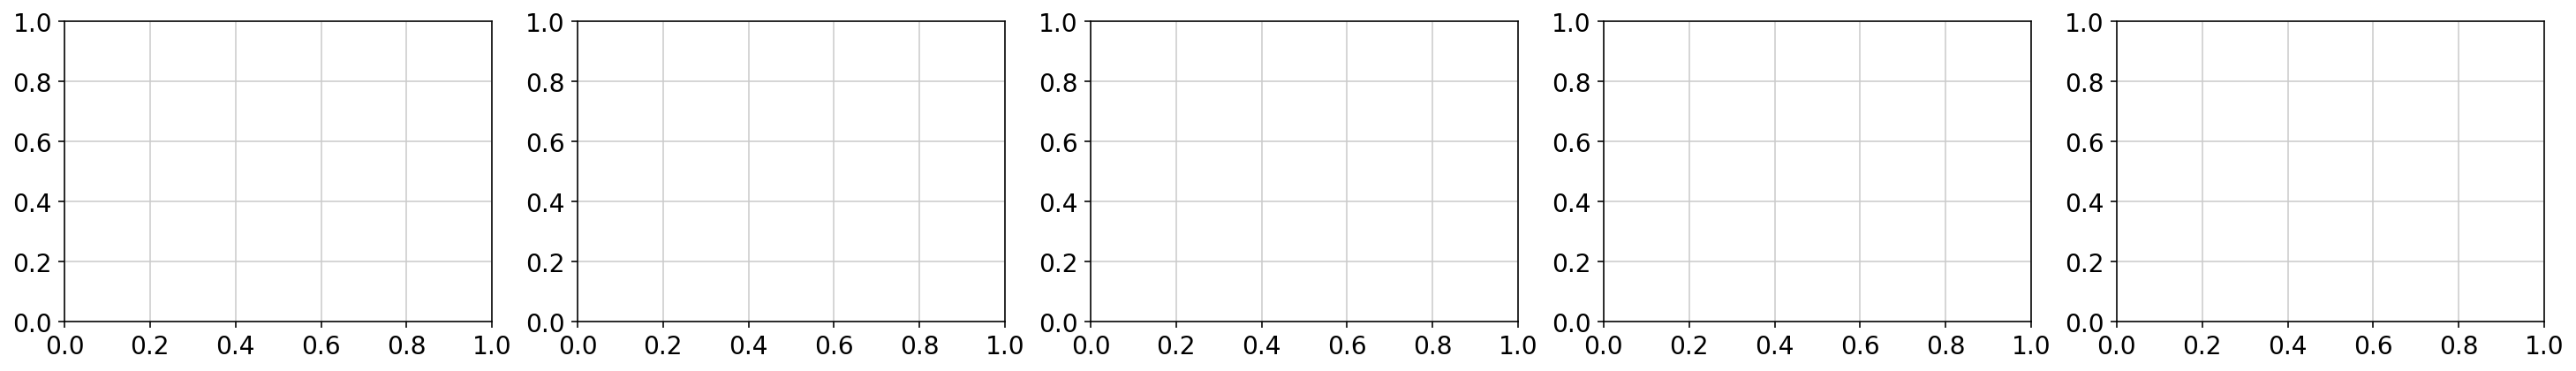

In [47]:
def predict_from_mutational(data,features,func_data,mymodel):
    mut_data=data.loc[:,features]
    for c in func_data:
        mut_data[c]=0
    #now, predict
    mut_preds=mymodel.predict(mut_data)
    return(mut_preds)

#record model performances here
performances=pd.DataFrame(columns=['condition','pearson','spearman','r2','fold'])
results={}

mut_prediction_data=pd.DataFrame(index=sorted_variants)



for i in range(3):
    print('=============== iteration',i)
    #define train, validation sets
    #==============================
    #randomize train/test - by position
    foldname='fold'+str(i)
    rng=np.random.RandomState(i)
    data[foldname]=get_positions_train_valid(copy.deepcopy(data['Position']),rng)
    
    data[foldname+'not']=(data[foldname]==False)
    
    data['train'+foldname]=np.multiply(data['has_effsize'],data[foldname])
    data['valid'+foldname]=np.multiply(data['has_effsize'],data[foldname+'not'])
    
    #train each model of interest
    #============================
    model2features={}
    model2features['Cell. + \n Mut. + \n sc-eVIP - \nTrain L \n Test L']=list(set(pheno_cols).union(set(signature_cols)))
    model2features['Cell. + \n Mut. - \n sc-eVIP - \nTrain L \n Test L']=pheno_cols
    
    model2features['Cell. + \n Mut. + \n sc-eVIP - \nTrain L \n Test S']=list(set(pheno_cols).union(set(signature_cols)))
    model2features['Cell. + \n Mut. - \n sc-eVIP - \nTrain L \n Test S']=list(set(pheno_cols).union(set([])))
    
    model2features['Cell. + \n Mut. + \n sc-eVIP - \nTrain S \n Test S']=list(set(pheno_cols).union(set(signature_cols)))
    model2features['Cell. + \n Mut. - \n sc-eVIP - \nTrain S \n Test S']=list(set(pheno_cols).union(set([])))
         
    model2features['Cell. - \n Mut. + \n sc-eVIP + \nTrain S \n Test S']=list(set(impact_cols).union(set(signature_cols)))
    model2features['Cell. - \n Mut. - \n sc-eVIP + \nTrain S \n Test S']=impact_cols
    
    
    
    model2train={}
    model2train['Cell. + \n Mut. + \n sc-eVIP - \nTrain L \n Test L']=foldname
    model2train['Cell. + \n Mut. - \n sc-eVIP - \nTrain L \n Test L']=foldname
    
    model2train['Cell. + \n Mut. + \n sc-eVIP - \nTrain L \n Test S']=foldname
    model2train['Cell. + \n Mut. - \n sc-eVIP - \nTrain L \n Test S']=foldname
    
    model2train['Cell. + \n Mut. + \n sc-eVIP - \nTrain S \n Test S']='train'+foldname
    model2train['Cell. + \n Mut. - \n sc-eVIP - \nTrain S \n Test S']='train'+foldname
     
    model2train['Cell. - \n Mut. + \n sc-eVIP + \nTrain S \n Test S']='train'+foldname
    model2train['Cell. - \n Mut. - \n sc-eVIP + \nTrain S \n Test S']='train'+foldname
    
       
    model2valid={}

    model2valid['Cell. + \n Mut. + \n sc-eVIP - \nTrain L \n Test L']=foldname+'not'
    model2valid['Cell. + \n Mut. - \n sc-eVIP - \nTrain L \n Test L']=foldname+'not'
    
    model2valid['Cell. + \n Mut. + \n sc-eVIP - \nTrain L \n Test S']='valid'+foldname
    model2valid['Cell. + \n Mut. - \n sc-eVIP - \nTrain L \n Test S']='valid'+foldname
    
    model2valid['Cell. + \n Mut. + \n sc-eVIP - \nTrain S \n Test S']='valid'+foldname
    model2valid['Cell. + \n Mut. - \n sc-eVIP - \nTrain S \n Test S']='valid'+foldname
     
    model2valid['Cell. - \n Mut. + \n sc-eVIP + \nTrain S \n Test S']='valid'+foldname
    model2valid['Cell. - \n Mut. - \n sc-eVIP + \nTrain S \n Test S']='valid'+foldname

       
    model2num={}
    model2num['Cell. + \n Mut. + \n sc-eVIP - \nTrain L \n Test L']=1
    model2num['Cell. + \n Mut. - \n sc-eVIP - \nTrain L \n Test L']=2
    
    model2num['Cell. + \n Mut. + \n sc-eVIP - \nTrain L \n Test S']=3
    model2num['Cell. + \n Mut. - \n sc-eVIP - \nTrain L \n Test S']=4
    
    model2num['Cell. + \n Mut. + \n sc-eVIP - \nTrain S \n Test S']=5
    model2num['Cell. + \n Mut. - \n sc-eVIP - \nTrain S \n Test S']=6
     
    model2num['Cell. - \n Mut. + \n sc-eVIP + \nTrain S \n Test S']=9
    model2num['Cell. - \n Mut. - \n sc-eVIP + \nTrain S \n Test S']=10
    
    
    results[i]={}
    
    model_names=list(model2features.keys())
    for idx in range(len(model_names)): #['impact_train100variants']:#
        model_name=model_names[idx]
        
        features=model2features[model_name]
        performance_current_full=model_full(data,
                    features,
                    training_pos_col=model2train[model_name],
                    valid_pos_col=model2valid[model_name],
                    training_y_name=yname,
                    valid_y_name=yname,
                                            
                  toprint=model_name)
        
        #predictions from mutational signatures coefficients, trained using mutsig and func data
        if model_name=='Cell. + \n Mut. + \n sc-eVIP - \nTrain L \n Test L':
            print('model name',model_name)
            model_here=performance_current_full[0]['model']
            mut_pred=predict_from_mutational(data,
                                             model2features[model_name],pheno_cols,
                                            model_here)
            print('mut pred ===',mut_pred)
            mut_prediction_data['iter'+str(i)]=mut_pred.loc[sorted_variants]
        #=================    
        
        print(performance_current_full[4])
        plot_performance(performance_current_full[0],'',-0.5,4)
        
        import copy
        results[i][model_name]=copy.deepcopy(performance_current_full)
        
        performance_current=performance_current_full[4]
        performance_current['fold']=foldname
        performances=pd.concat([performances,performance_current],axis=0)
        
        
        
    import copy
    import random
    model_name='Cell. + \n Mut. + \n sc-eVIP - \nTrain S \n Test S'
    features=model2features[model_name]
    out=model_full(data,
                    features,
                    training_pos_col=model2train[model_name],
                    valid_pos_col=model2valid[model_name],
                    training_y_name=yname,
                    valid_y_name=yname,
                  toprint=model_name)
    out=model_full(data,
                features,
                training_pos_col=model2train[model_name],
                valid_pos_col=model2valid[model_name],
                training_y_name=yname,
                valid_y_name=yname,
              toprint=model_name)


    
    for item in ['train','valid','all']:
        idx=list(out[0]['obs_'+item].index)
        stuff=copy.deepcopy(list(out[0]['obs_'+item]))
        #shuffle
        stuff=rng.choice(stuff,size=len(stuff),replace=False)
        out[0]['pred_'+item]=pd.DataFrame(stuff,index=idx)[0]
        print(out[0]['pred_'+item].head())
    results[i]['shuffled']=copy.deepcopy(out)
    y_pred=np.array(out[0]['pred_valid']).flatten()
    y=out[0]['obs_valid']
    
    plot_performance(out[0],'',-0.5,4)
    
    
    from scipy.stats import spearmanr,pearsonr
    from sklearn.metrics import r2_score
    p=pearsonr(y,y_pred)[0]
    p=str(int(100*p)/100)
    r2=r2_score(y,y_pred)
    r2=str(int(100*r2)/100)
    sp=spearmanr(y,y_pred)[0]
    sp=str(int(100*sp)/100)
    performances_shuffled=pd.DataFrame({'condition':['shuffled'],
                                       'pearson':p,
                                       'spearman':sp,
                                       'r2':r2,
                                       'fold':[foldname]})
    performances=pd.concat([performances,performances_shuffled],axis=0)

In [ ]:
means=np.mean(mut_prediction_data,axis=1)
sds=np.std(mut_prediction_data,axis=1)
mut_prediction_data2=pd.DataFrame({'mean':means,'sd':sds},index=mut_prediction_data.index)
print(mut_prediction_data2)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


Index(['M111L', 'K179R', 'V8V', 'T144T', 'T127T', 'T158T', 'T50T', 'K176Q',
       'A66A', 'T158A', 'V112I', 'D173D', 'K169K', 'K178K', 'M170L', 'D30D',
       'A155G', 'T20T', 'K88K', 'R149K', 'T74T', 'F141L', 'S17S', 'L79I',
       'I163S', 'L159S', 'G75A', 'K147T', 'Q99E', 'T50P', 'R41K', 'Q22H',
       'C185Y', 'T144P', 'T74A', 'Q25H', 'N26Y', 'G60S', 'P34R', 'D119G',
       'Q61A', 'R135T', 'C118S', 'P110S', 'T20R', 'G77A', 'L52F', 'V14L',
       'S136N', 'R164Q', 'A130V', 'K147N', 'K117R', 'D57N', 'G60V', 'I36M',
       'G12Y', 'T50I', 'P34L', 'K5E', 'R68S', 'G13E', 'E31K', 'T20M', 'G60D',
       'A59E', 'G12I', 'D33E', 'A59G', 'E63K', 'T58I', 'A146P', 'Q61P', 'Q22K',
       'A59T', 'V14I', 'L19F', 'G13V', 'K117N', 'A146V', 'G12F', 'Q61K',
       'G13R', 'Q61L', 'Q61R', 'A146T', 'Q61H', 'G13C', 'G12R', 'G12S', 'G12A',
       'G12C', 'G12V', 'G12D'],
      dtype='object')


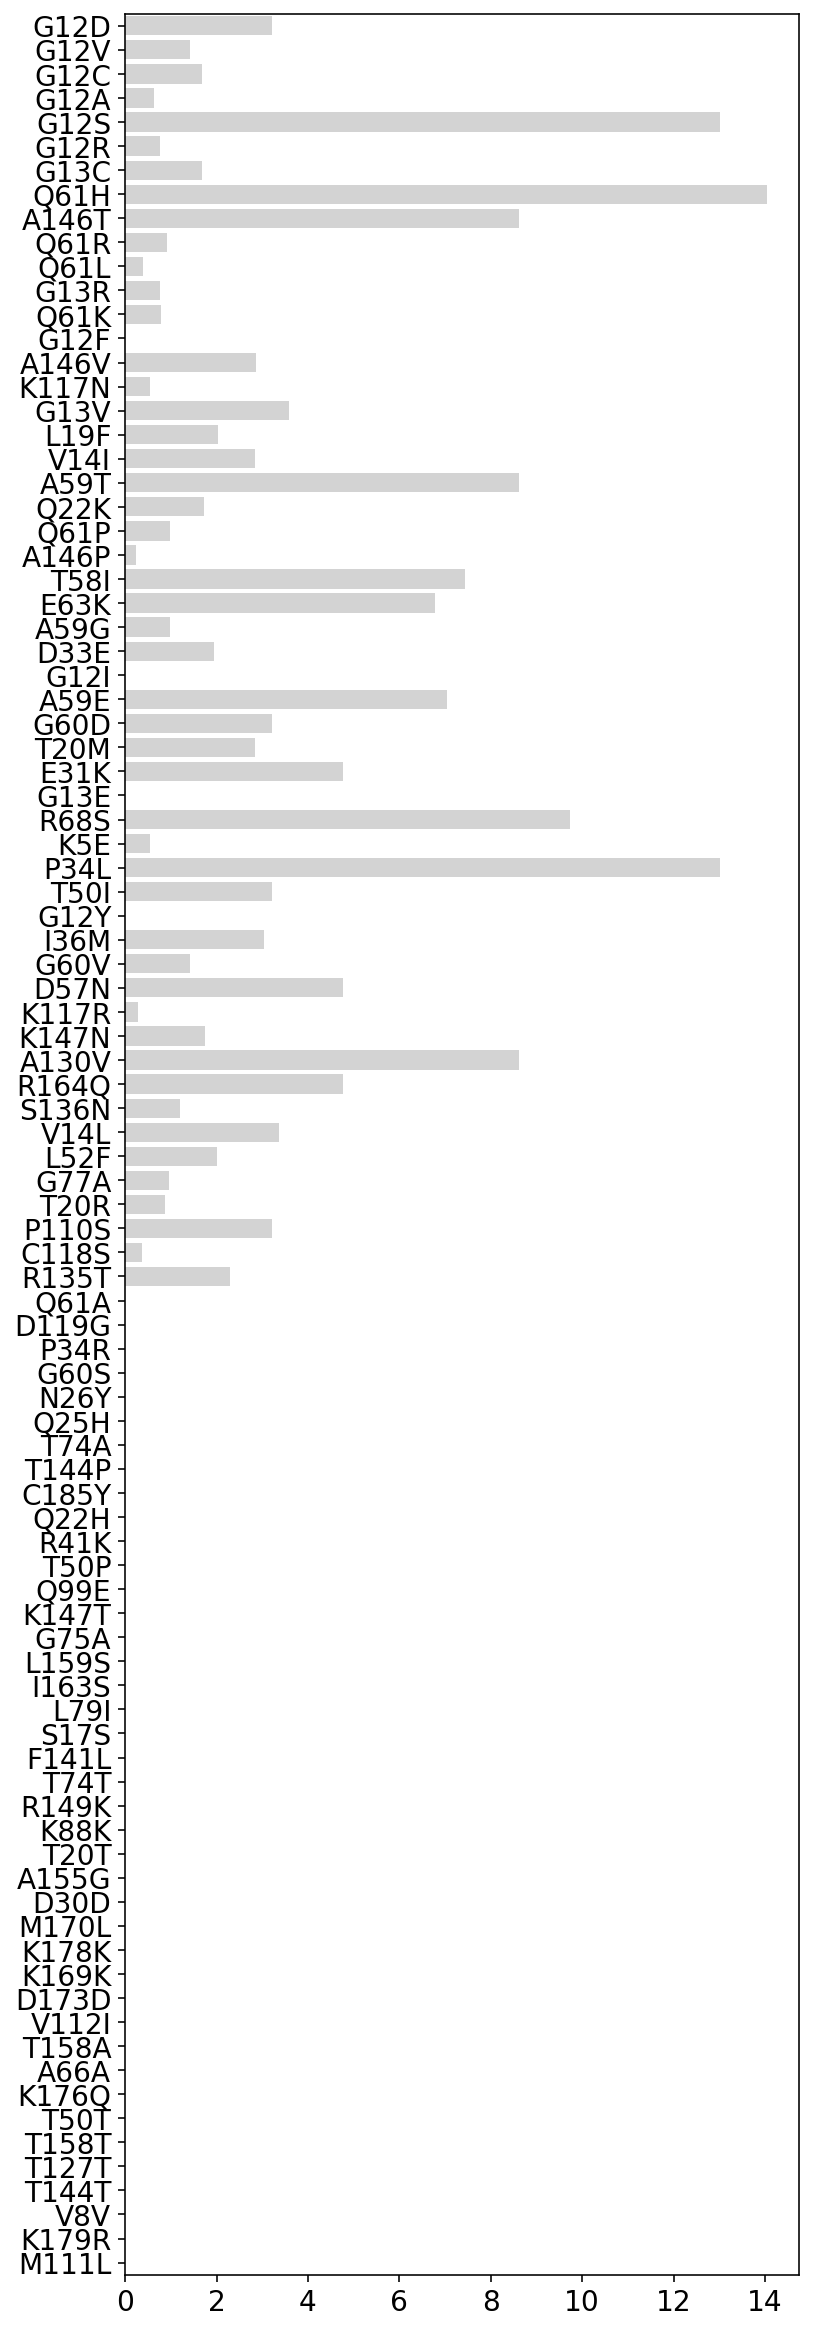

In [33]:
#effect size vs mut freq

#plot impact score vs mutation frequency

mutcount='COSMIC.1'

#- get the data
score='HotellingT2'
mutdata=pd.DataFrame({mutcount:mutsig.loc[sorted_variants,mutcount],
                     'effect size':anno.loc[sorted_variants,score],
                     'cluster_color':anno.loc[sorted_variants,'cluster_color'],
                     'COSMIC.1':mutsig.loc[sorted_variants,'COSMIC.1']},
                    index=sorted_variants)
mutdata=mutdata.dropna(subset=['COSMIC.1'])
mutdata=mutdata.fillna(0)
mutdata=mutdata.sort_values(by=['COSMIC.1','effect size'])
print(mutdata.index)
mut_prediction_data2=mut_prediction_data2.loc[mutdata.index,:]
mut_prediction_data2=mut_prediction_data2.fillna(0)

fig,plots=plt.subplots(1)
fig.set_size_inches(6,20)
plots.barh(mut_prediction_data2.index,mut_prediction_data2['mean'],
           color='lightgray'
          )
plots.errorbar(mut_prediction_data2['mean'], mut_prediction_data2.index,
             xerr=mut_prediction_data2['sd'],
             linestyle='None',#marker='o',
               color='black')
plots.set_ylim(-0.5,mut_prediction_data2.shape[0]-0.5)
plt.grid(False)

In [16]:
performances['spearman']=pd.DataFrame(performances['spearman'],dtype=float)
performances['pearson']=pd.DataFrame(performances['pearson'],dtype=float)
performances['r2']=pd.DataFrame(performances['r2'],dtype=float)
grouped_performances=performances.groupby('condition').median()
grouped_performances['condition']=list(grouped_performances.index)
grouped_performances.index=range(grouped_performances.shape[0])
pd.set_option('display.max_colwidth', 100)
print(grouped_performances)

   pearson  spearman     r2  \
0    0.840     0.460  0.625   
1    0.825     0.805  0.510   
2    0.825     0.805  0.360   
3    0.840     0.460  0.625   
4    0.825     0.805  0.510   
5    0.825     0.805  0.360   
6    0.720     0.835  0.075   
7    0.720     0.835  0.075   
8   -0.140    -0.030 -1.285   

                                            condition  
0  Cell. + \n Mut. + \n sc-eVIP - \nTrain L \n Test L  
1  Cell. + \n Mut. + \n sc-eVIP - \nTrain L \n Test S  
2  Cell. + \n Mut. + \n sc-eVIP - \nTrain S \n Test S  
3  Cell. + \n Mut. - \n sc-eVIP - \nTrain L \n Test L  
4  Cell. + \n Mut. - \n sc-eVIP - \nTrain L \n Test S  
5  Cell. + \n Mut. - \n sc-eVIP - \nTrain S \n Test S  
6  Cell. - \n Mut. + \n sc-eVIP + \nTrain S \n Test S  
7  Cell. - \n Mut. - \n sc-eVIP + \nTrain S \n Test S  
8                                            shuffled  


r2                                                     Cell. + \n Mut. + \n sc-eVIP - \nTrain S \n Test S  \
Cell. - \n Mut. - \n sc-eVIP + \nTrain S \n Test S                                            0.415128   
Cell. - \n Mut. + \n sc-eVIP + \nTrain S \n Test S                                            0.415128   
Cell. + \n Mut. - \n sc-eVIP - \nTrain S \n Test S                                            1.000000   
Cell. + \n Mut. + \n sc-eVIP - \nTrain S \n Test S                                            1.000000   
Cell. + \n Mut. - \n sc-eVIP - \nTrain L \n Test S                                            0.738996   
Cell. + \n Mut. + \n sc-eVIP - \nTrain L \n Test S                                            0.738996   
Cell. + \n Mut. - \n sc-eVIP - \nTrain L \n Test L                                            0.053201   
Cell. + \n Mut. + \n sc-eVIP - \nTrain L \n Test L                                            0.053201   
shuffled                                   

spearman                                                     Cell. + \n Mut. + \n sc-eVIP - \nTrain S \n Test S  \
Cell. - \n Mut. - \n sc-eVIP + \nTrain S \n Test S                                        1.000000e+00   
Cell. - \n Mut. + \n sc-eVIP + \nTrain S \n Test S                                        1.000000e+00   
Cell. + \n Mut. - \n sc-eVIP - \nTrain S \n Test S                                        1.000000e+00   
Cell. + \n Mut. + \n sc-eVIP - \nTrain S \n Test S                                        1.000000e+00   
Cell. + \n Mut. - \n sc-eVIP - \nTrain L \n Test S                                        1.000000e+00   
Cell. + \n Mut. + \n sc-eVIP - \nTrain L \n Test S                                        1.000000e+00   
Cell. + \n Mut. - \n sc-eVIP - \nTrain L \n Test L                                        8.751026e-08   
Cell. + \n Mut. + \n sc-eVIP - \nTrain L \n Test L                                        8.751026e-08   
shuffled                             

pearson                                                     Cell. + \n Mut. + \n sc-eVIP - \nTrain S \n Test S  \
Cell. - \n Mut. - \n sc-eVIP + \nTrain S \n Test S                                        1.242348e-01   
Cell. - \n Mut. + \n sc-eVIP + \nTrain S \n Test S                                        1.242348e-01   
Cell. + \n Mut. - \n sc-eVIP - \nTrain S \n Test S                                        1.000000e+00   
Cell. + \n Mut. + \n sc-eVIP - \nTrain S \n Test S                                        1.000000e+00   
Cell. + \n Mut. - \n sc-eVIP - \nTrain L \n Test S                                        1.000000e+00   
Cell. + \n Mut. + \n sc-eVIP - \nTrain L \n Test S                                        1.000000e+00   
Cell. + \n Mut. - \n sc-eVIP - \nTrain L \n Test L                                        5.678768e-01   
Cell. + \n Mut. + \n sc-eVIP - \nTrain L \n Test L                                        5.678768e-01   
shuffled                              

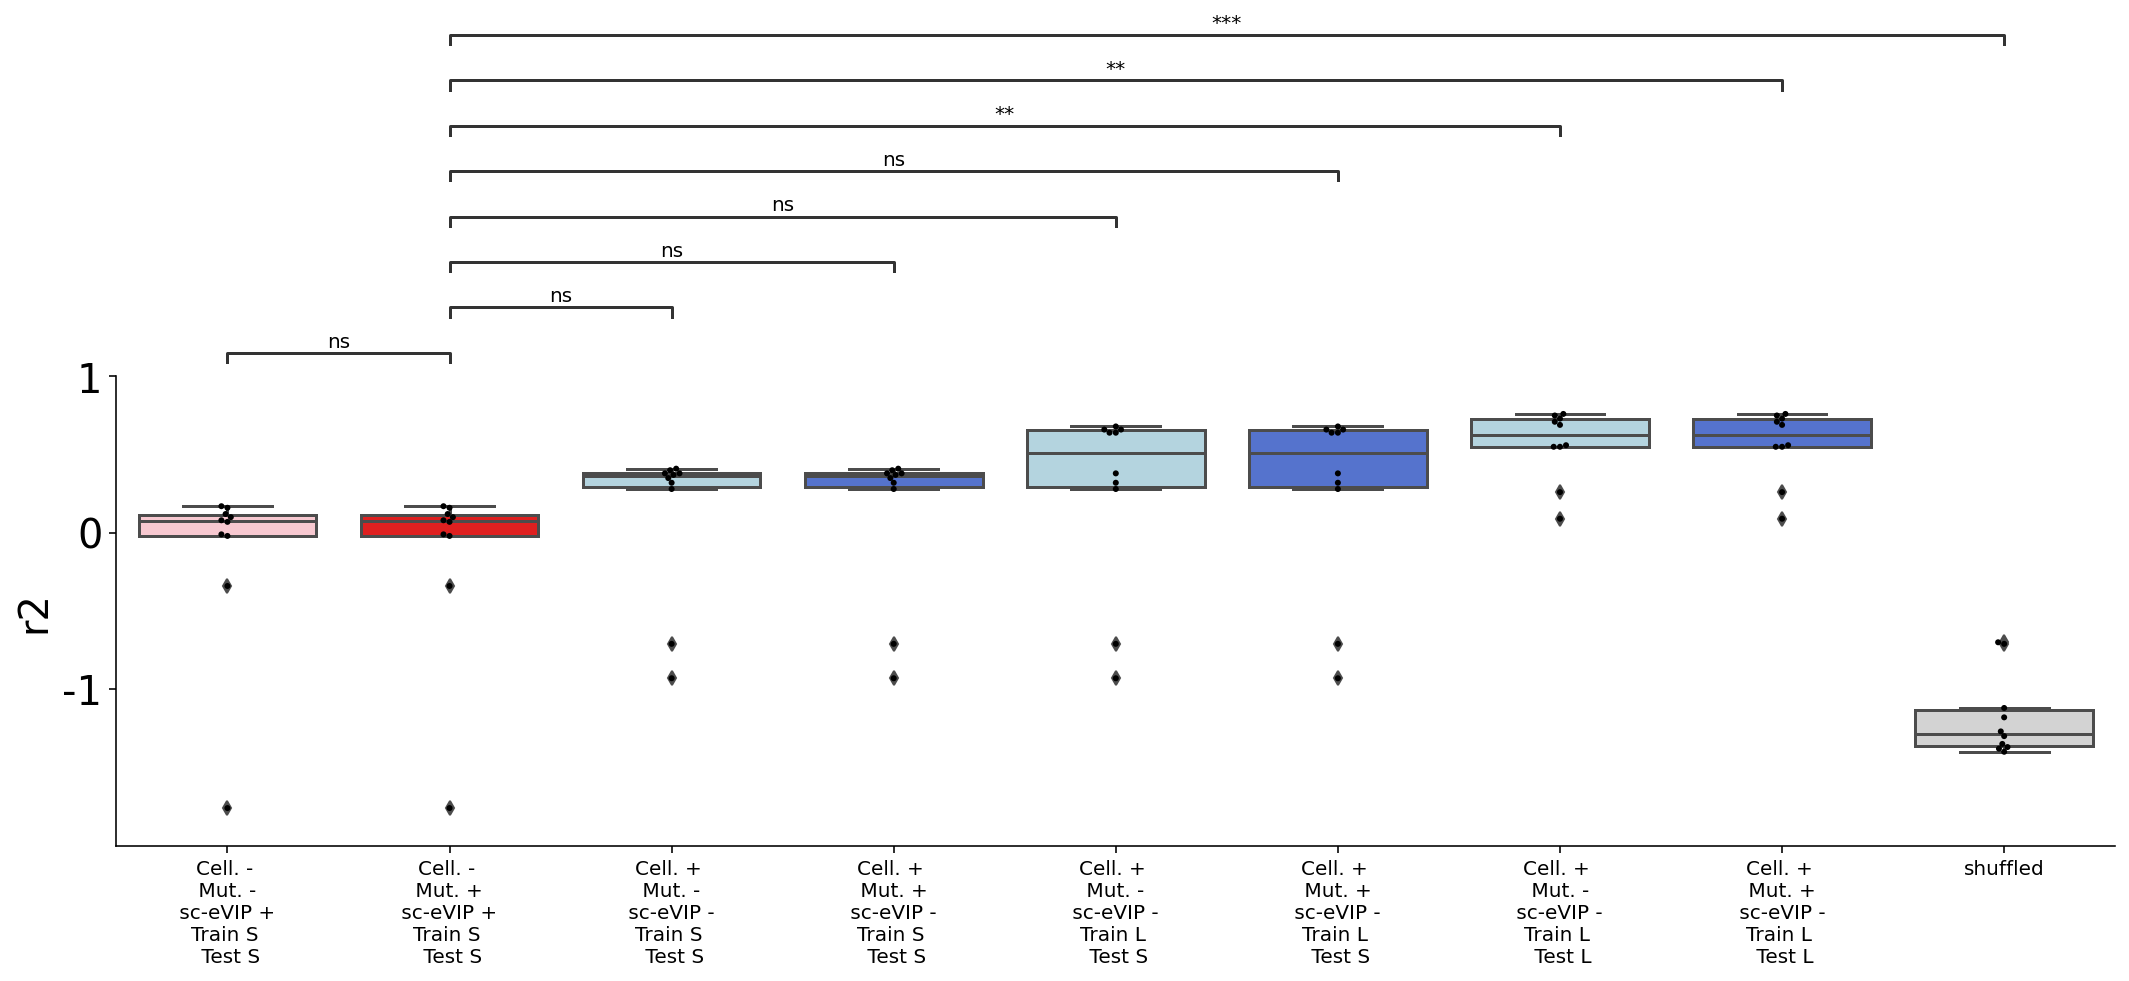

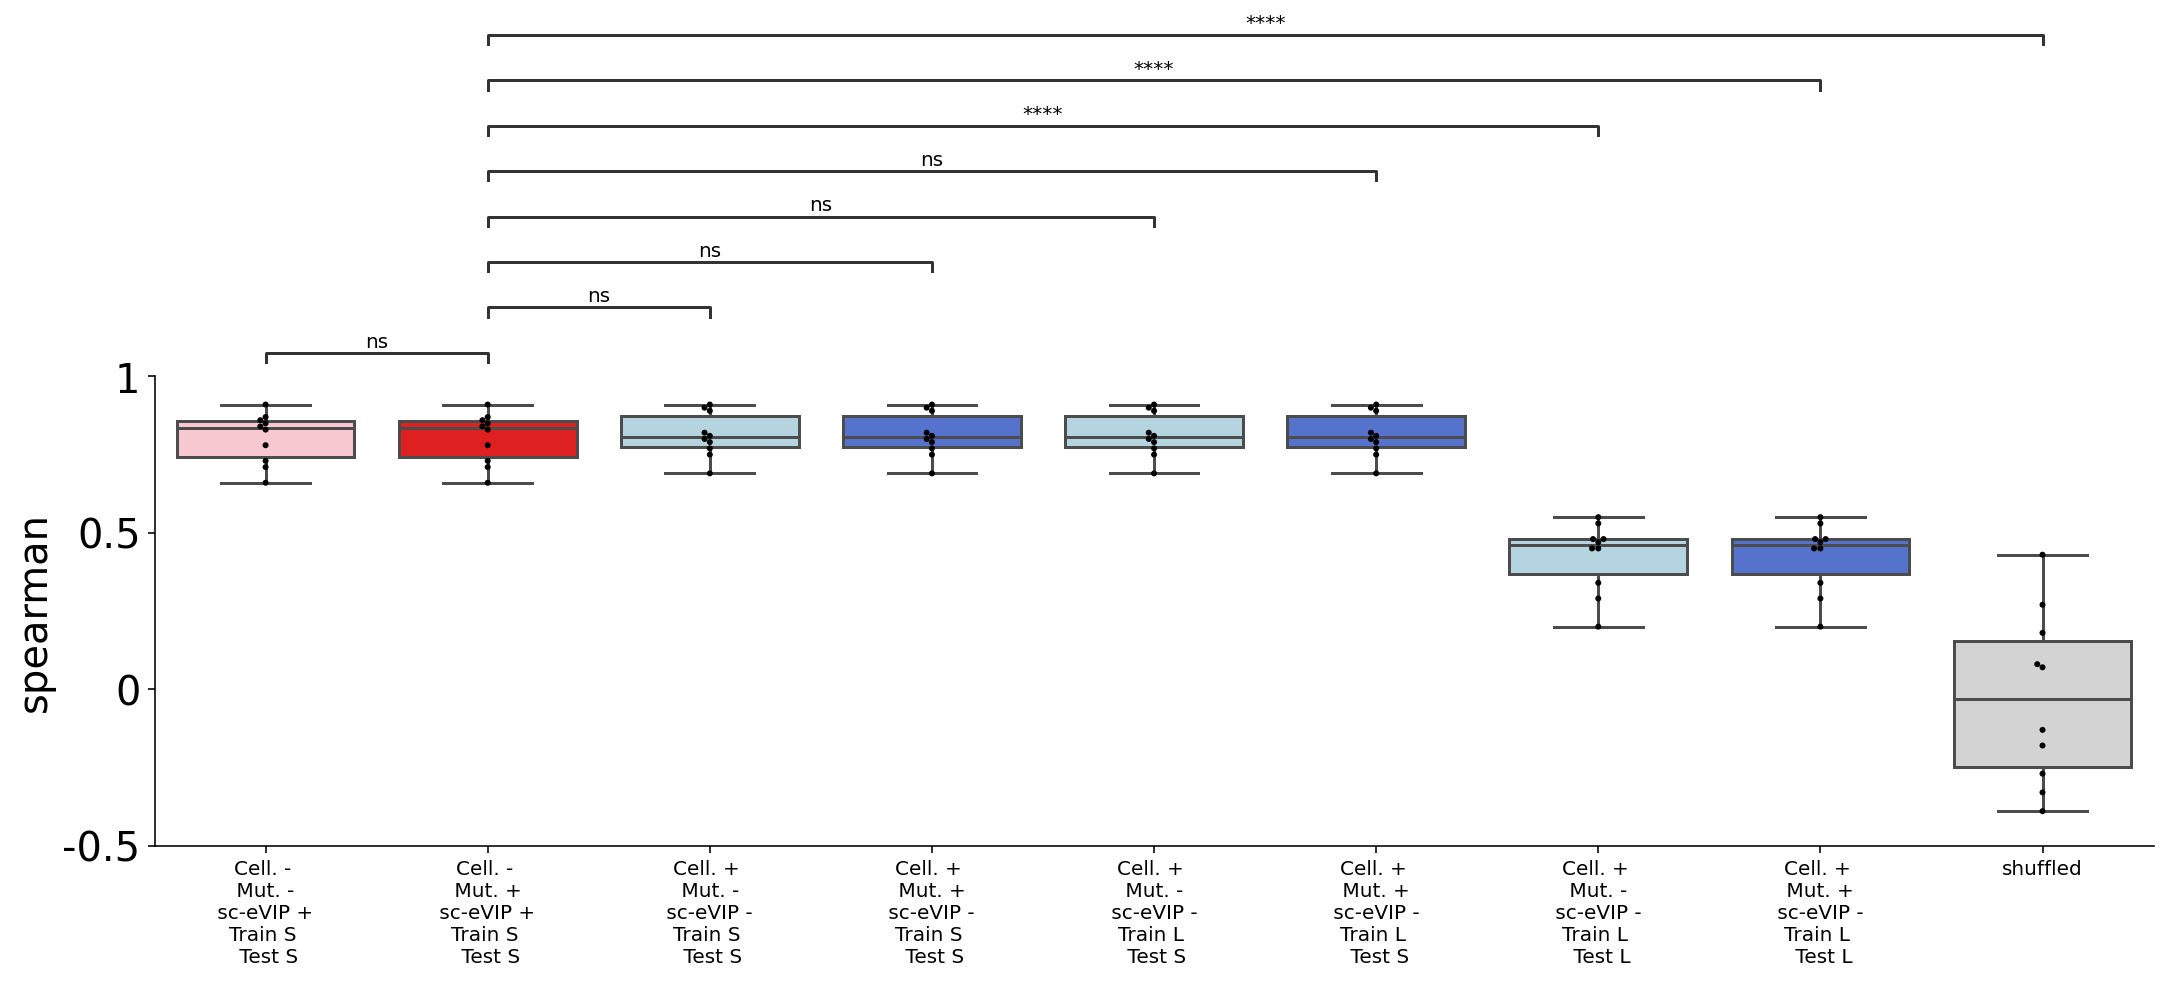

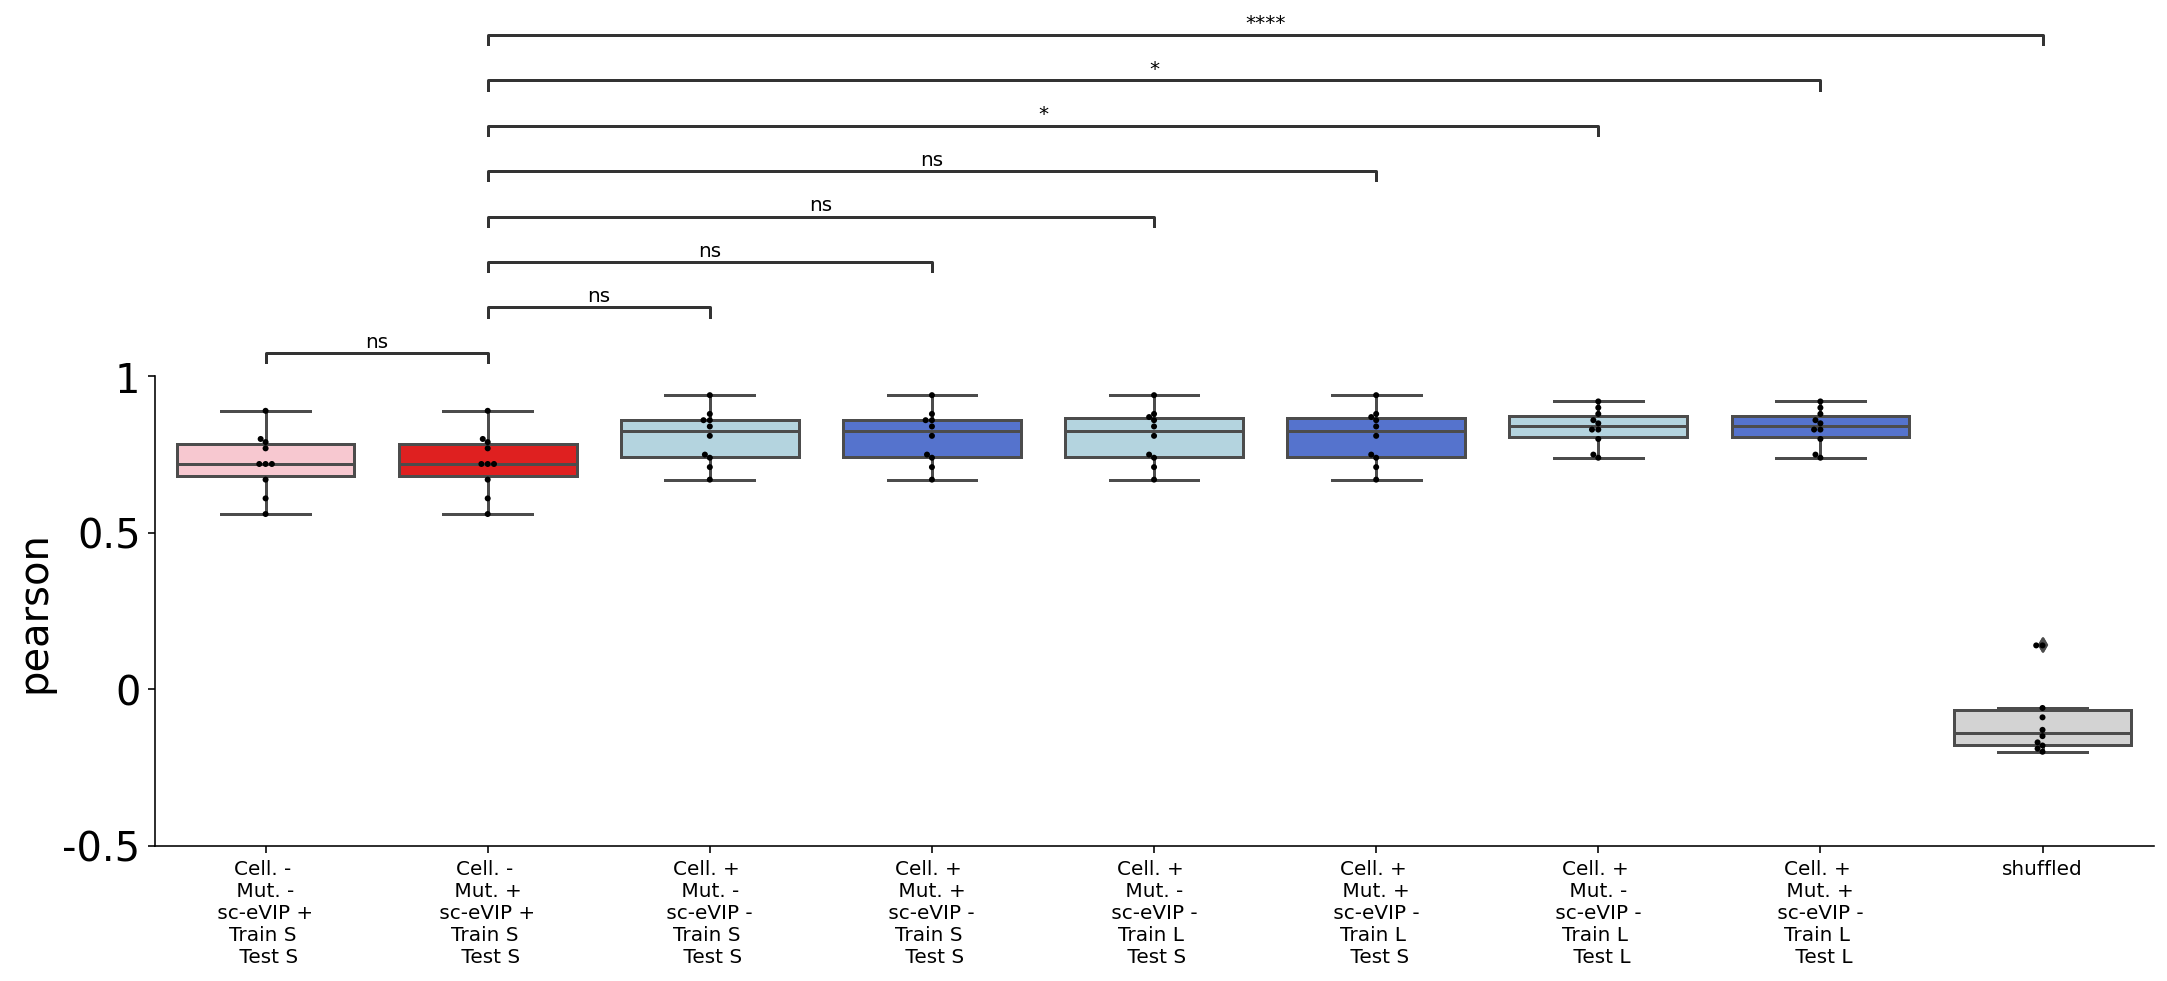

In [19]:
color_dict={}
for m in model_names:
    if 'Mut. +' in m:
        if 'sc-eVIP -' in m:
            co='royalblue'
        if 'sc-eVIP +' in m:
            co='red'
    elif 'Mut. -' in m:
        if 'sc-eVIP -' in m:
            co='lightblue'
        if 'sc-eVIP +' in m:
            co='pink'
    else:
        co='lightgray'
    color_dict[m]=co
    
color_dict['shuffled']='lightgray'

myorder=['shuffled',
         'Cell. + \n Mut. + \n sc-eVIP - \nTrain L \n Test L', 
         'Cell. + \n Mut. - \n sc-eVIP - \nTrain L \n Test L',
         
         'Cell. + \n Mut. + \n sc-eVIP - \nTrain L \n Test S',  
         'Cell. + \n Mut. - \n sc-eVIP - \nTrain L \n Test S', 
         
         'Cell. + \n Mut. + \n sc-eVIP - \nTrain S \n Test S',  
         'Cell. + \n Mut. - \n sc-eVIP - \nTrain S \n Test S',  
         
         'Cell. - \n Mut. + \n sc-eVIP + \nTrain S \n Test S',  
         'Cell. - \n Mut. - \n sc-eVIP + \nTrain S \n Test S']
myorder=myorder[::-1]

pairs=[]
comparison='Cell. - \n Mut. + \n sc-eVIP + \nTrain S \n Test S'
for x in myorder:
    if x==comparison:
        continue
    pairs.append((x,comparison))
    
    
def pairwise_ttests(df,condition,value):

    pval_m=pd.DataFrame(0.0,index=conditions,columns=conditions)

    for m1 in conditions:
        m1_values=df.loc[df[condition]==m1,value]
        for m2 in conditions:
            m2_values=df.loc[df[condition]==m2,value]

            from scipy.stats import ttest_ind
            res=ttest_ind(m1_values,m2_values,nan_policy='omit')

            pval_m.loc[m1,m2]=res[1]
            pval_m.loc[m2,m1]=pval_m.loc[m1,m2]
            
    #correct for multiple testing
    from statsmodels.stats.multitest import multipletests
    pvals=np.array(pval_m).flatten()
    new_pvals=multipletests(pvals,method='fdr_bh')[1]
    pval_m2=pd.DataFrame(new_pvals.reshape(pval_m.shape),index=pval_m.index,columns=pval_m.columns)
    return(pval_m2)

    
    
from statannot import add_stat_annotation
for item in ['r2','spearman','pearson']:
    
    df=pd.DataFrame({'condition':performances['condition'],
                'value':performances[item]})

    condition='condition'
    value='value'
    conditions=set(df[condition])
    pval_m=pairwise_ttests(df,'condition','value')
    print(item,pval_m.loc[myorder,:])
    pvals_anno=[]
    for pair_idx in range(len(pairs)):
        #pvals_anno.append('{:0.2e}'.format(pval_m.loc[pairs[pair_idx][0],pairs[pair_idx][1]]))
        pvals_anno.append(pval_m.loc[pairs[pair_idx][0],pairs[pair_idx][1]])
        
    
    g = sns.catplot(x="condition", y=item,kind='box',data=performances,palette=color_dict,
                   order=myorder,aspect=3)##aspect=1.3)#4)
                    #order=myorder)#,palette=color_dict)
    sns.swarmplot(x="condition", y=item, color="k", size=3, data=performances, ax=g.ax,order=myorder)
                  #order=myorder);
        
    ax1 = g.axes[0,0]
    ax1.grid(False)
    
    
    if item=='r2':
        g.ax.set_ylim(-2,1)
        g.ax.set_yticks([-1,0,1])
        g.ax.set_yticklabels([-1,0,1],fontsize=20)
        
    else:
        g.ax.set_ylim(-0.5,1)
        g.ax.set_yticks([-0.5,0,0.5,1])
        g.ax.set_yticklabels([-0.5,0,0.5,1],fontsize=20)
    #g.ax.set_xticks([])
    g.ax.set_xlabel('')
    g.ax.set_ylabel(item,fontsize=20)
    g.ax.set_xticklabels(myorder,fontsize=10)
    
    
    test_results = add_stat_annotation(ax1,
                                       x="condition", y=item,data=performances,order=myorder,
                                   box_pairs=pairs,
                                       pvalues=pvals_anno,
                                       perform_stat_test=False,
                                       #text_annot_custom=pvals_anno,
                                   text_format='star',
                                   loc='outside', verbose=2)
    
    plt.savefig(FIGS+'/'+PROTEIN+'.LinModels_full.'+item+'.pdf',bbox_inches = "tight") 
    plt.savefig(FIGS+'/'+PROTEIN+'.LinModels_full.'+item+'.png',bbox_inches = "tight")

r2                                                     Cell. + \n Mut. + \n sc-eVIP - \nTrain S \n Test S  \
Cell. - \n Mut. + \n sc-eVIP + \nTrain S \n Test S                                            0.415128   
Cell. + \n Mut. + \n sc-eVIP - \nTrain S \n Test S                                            1.000000   
Cell. + \n Mut. + \n sc-eVIP - \nTrain L \n Test S                                            0.738996   
Cell. + \n Mut. + \n sc-eVIP - \nTrain L \n Test L                                            0.053201   
shuffled                                                                                      0.000010   

                                                    Cell. + \n Mut. - \n sc-eVIP - \nTrain S \n Test S  \
Cell. - \n Mut. + \n sc-eVIP + \nTrain S \n Test S                                            0.415128   
Cell. + \n Mut. + \n sc-eVIP - \nTrain S \n Test S                                            1.000000   
Cell. + \n Mut. + \n sc-eVIP - \nTrain L \

pearson                                                     Cell. + \n Mut. + \n sc-eVIP - \nTrain S \n Test S  \
Cell. - \n Mut. + \n sc-eVIP + \nTrain S \n Test S                                        1.242348e-01   
Cell. + \n Mut. + \n sc-eVIP - \nTrain S \n Test S                                        1.000000e+00   
Cell. + \n Mut. + \n sc-eVIP - \nTrain L \n Test S                                        1.000000e+00   
Cell. + \n Mut. + \n sc-eVIP - \nTrain L \n Test L                                        5.678768e-01   
shuffled                                                                                  2.942200e-12   

                                                    Cell. + \n Mut. - \n sc-eVIP - \nTrain S \n Test S  \
Cell. - \n Mut. + \n sc-eVIP + \nTrain S \n Test S                                        1.242348e-01   
Cell. + \n Mut. + \n sc-eVIP - \nTrain S \n Test S                                        1.000000e+00   
Cell. + \n Mut. + \n sc-eVIP - \nTrai

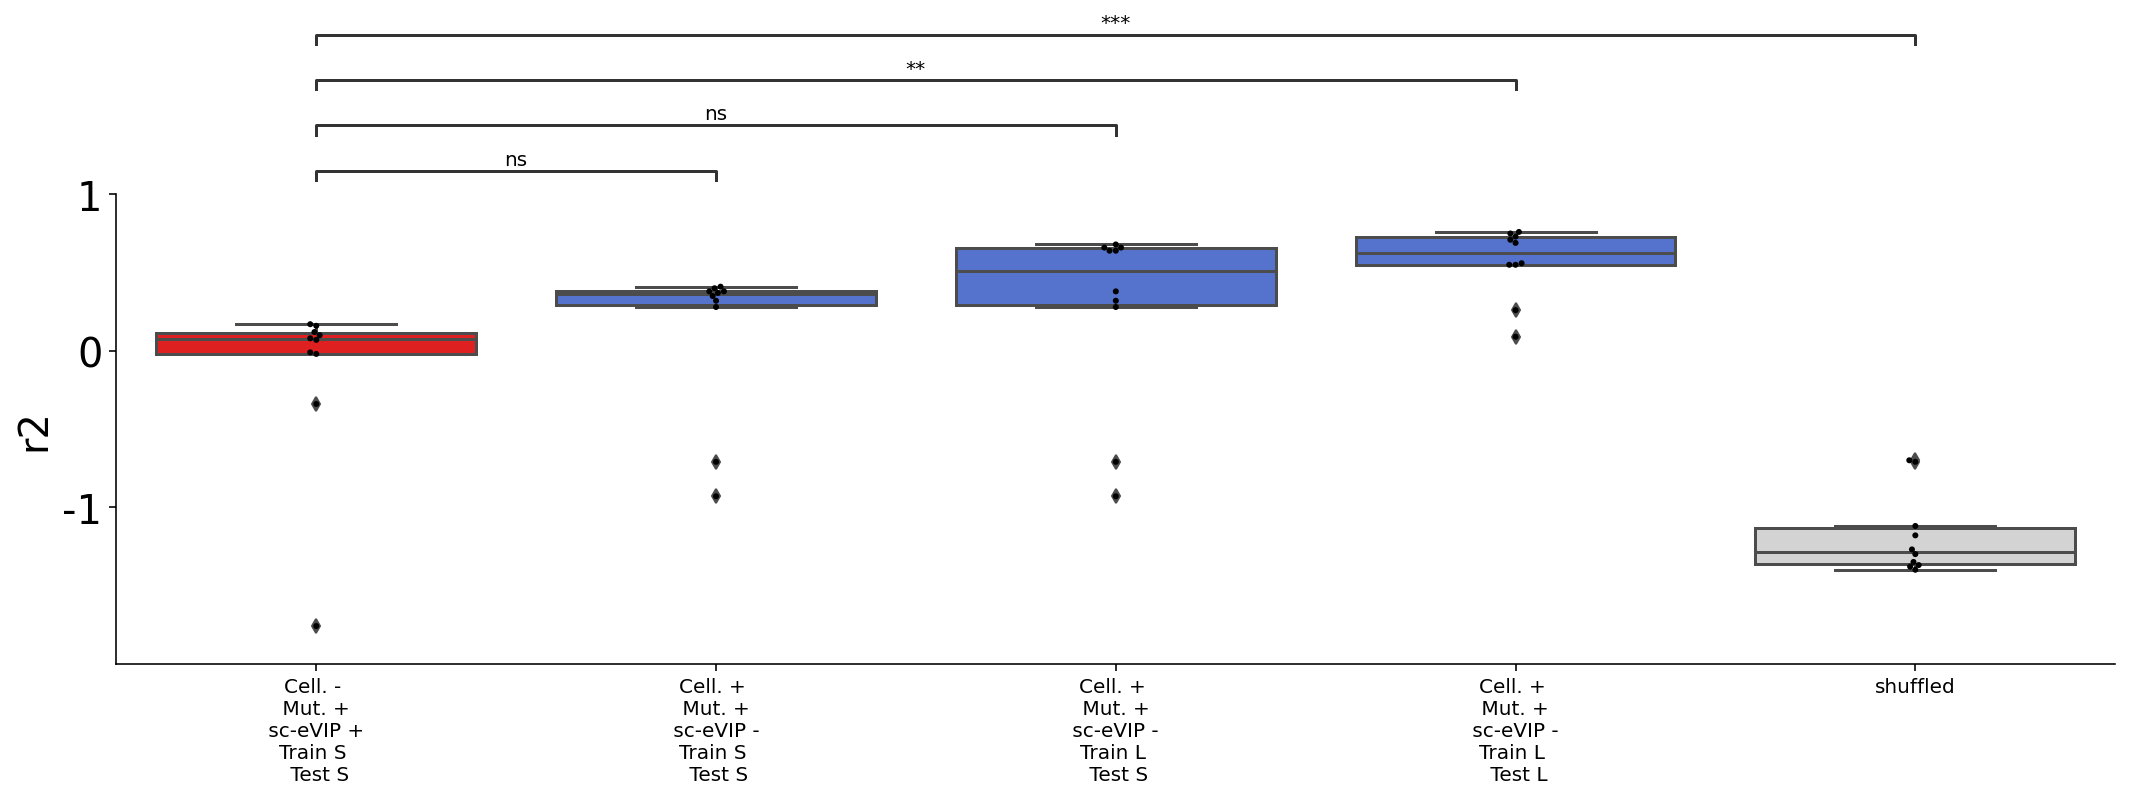

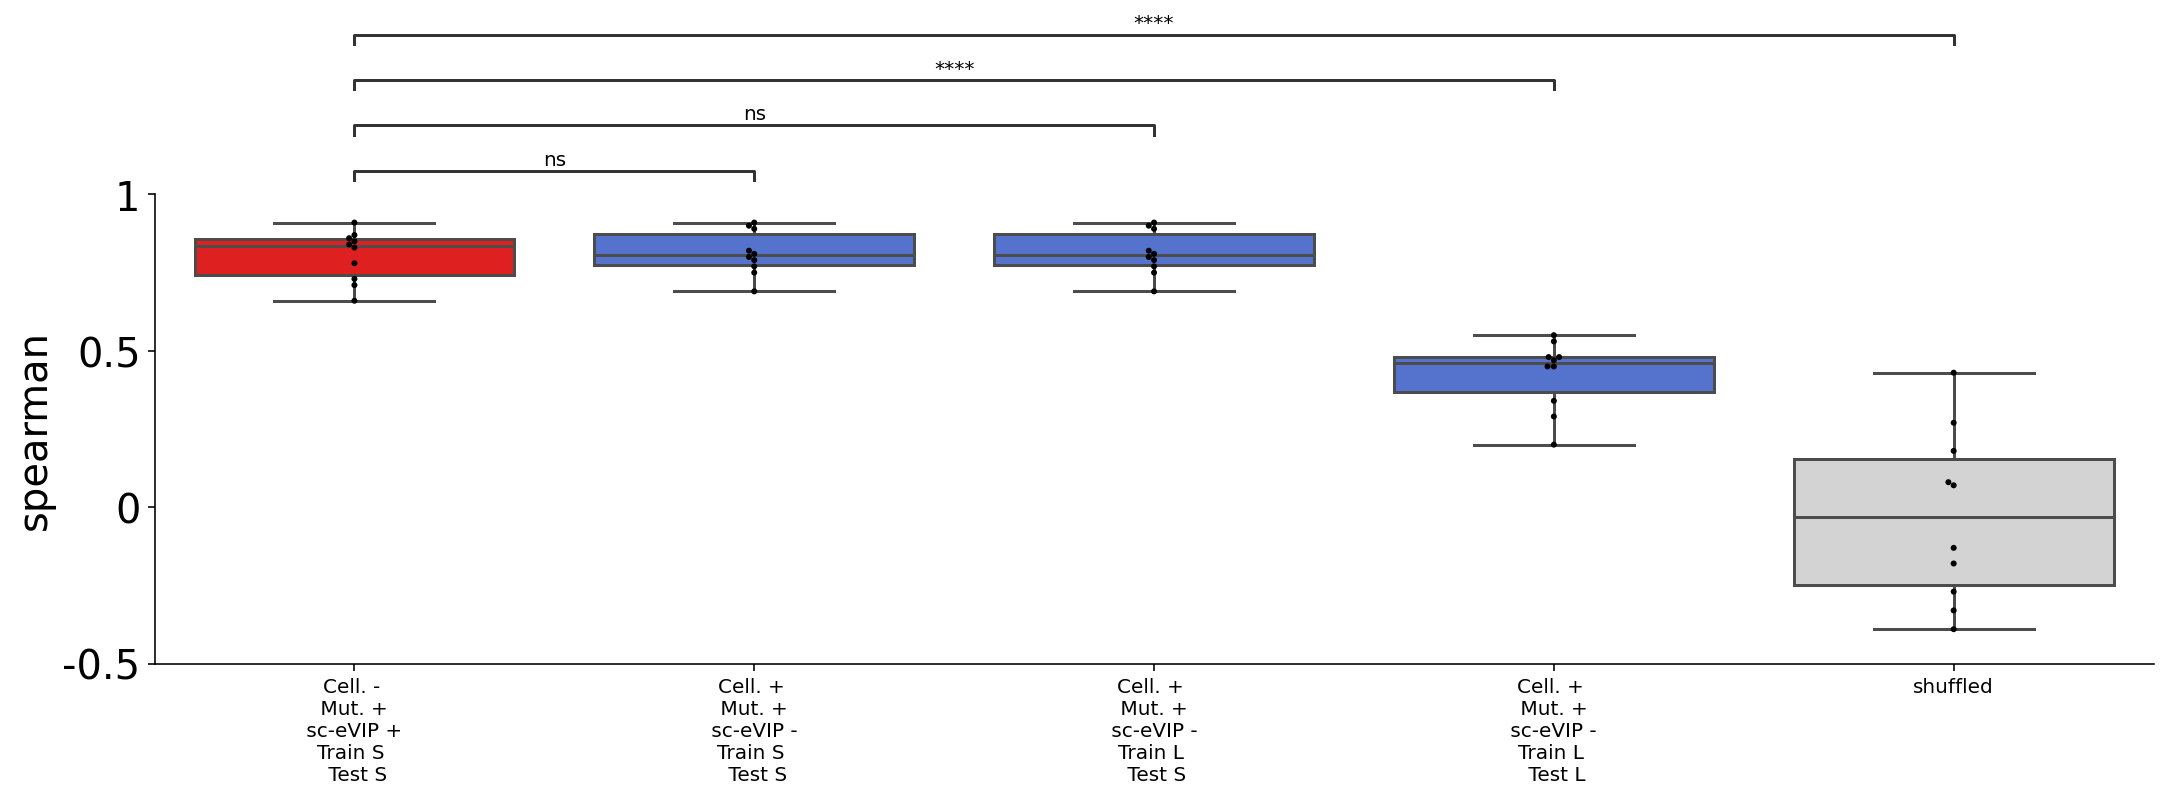

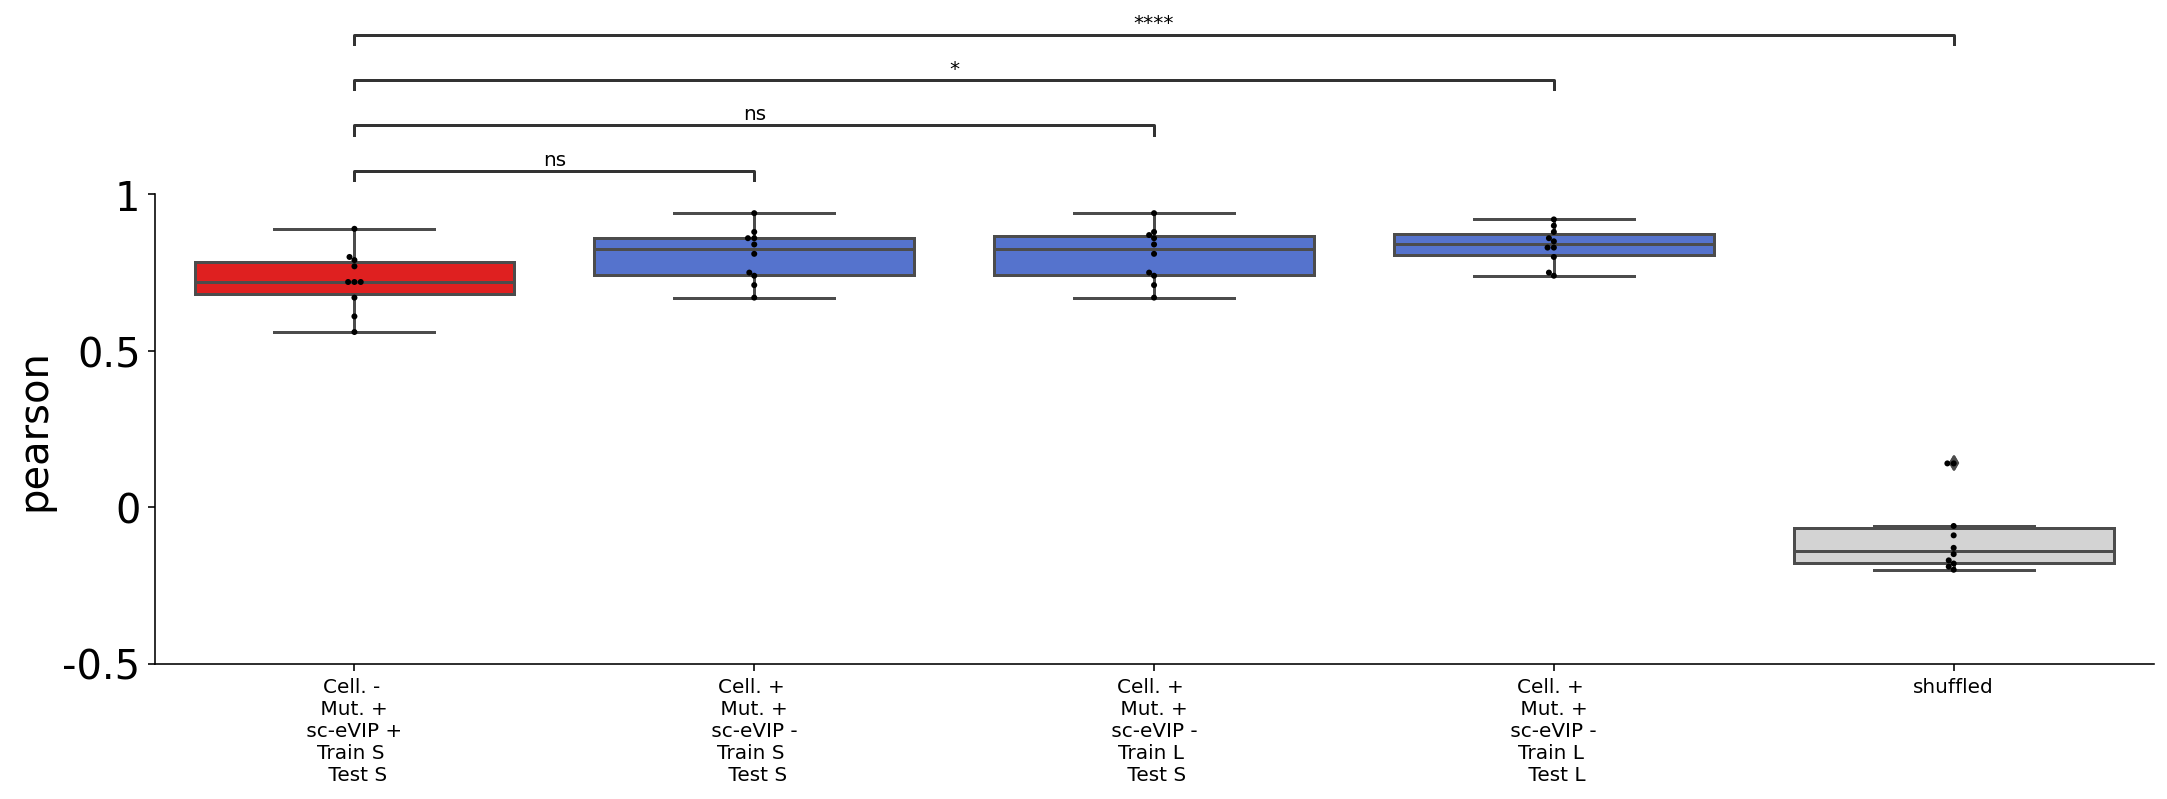

In [20]:
color_dict={}
for m in model_names:
    if 'Mut. +' in m:
        if 'sc-eVIP -' in m:
            co='royalblue'
        if 'sc-eVIP +' in m:
            co='red'
    elif 'Mut. -' in m:
        if 'sc-eVIP -' in m:
            co='lightblue'
        if 'sc-eVIP +' in m:
            co='pink'
    else:
        co='lightgray'
    color_dict[m]=co
    
color_dict['shuffled']='lightgray'

def pairwise_ttests(df,condition,value):

    pval_m=pd.DataFrame(0.0,index=conditions,columns=conditions)

    for m1 in conditions:
        m1_values=df.loc[df[condition]==m1,value]
        for m2 in conditions:
            m2_values=df.loc[df[condition]==m2,value]

            from scipy.stats import ttest_ind
            res=ttest_ind(m1_values,m2_values,nan_policy='omit')

            pval_m.loc[m1,m2]=res[1]
            pval_m.loc[m2,m1]=pval_m.loc[m1,m2]
            
    #correct for multiple testing
    from statsmodels.stats.multitest import multipletests
    pvals=np.array(pval_m).flatten()
    new_pvals=multipletests(pvals,method='fdr_bh')[1]
    pval_m2=pd.DataFrame(new_pvals.reshape(pval_m.shape),index=pval_m.index,columns=pval_m.columns)
    return(pval_m2)

myorder=['shuffled',
         'Cell. + \n Mut. + \n sc-eVIP - \nTrain L \n Test L', 
         
         'Cell. + \n Mut. + \n sc-eVIP - \nTrain L \n Test S',  
         
         'Cell. + \n Mut. + \n sc-eVIP - \nTrain S \n Test S',    
         
         'Cell. - \n Mut. + \n sc-eVIP + \nTrain S \n Test S']
myorder=myorder[::-1]

pairs=[]
comparison='Cell. - \n Mut. + \n sc-eVIP + \nTrain S \n Test S'
for x in myorder:
    if x==comparison:
        continue
    pairs.append((x,comparison))
    
from statannot import add_stat_annotation
for item in ['r2','spearman','pearson']:
    
    df=pd.DataFrame({'condition':performances['condition'],
                'value':performances[item]})

    condition='condition'
    value='value'
    conditions=set(df[condition])
    pval_m=pairwise_ttests(df,'condition','value')
    print(item,pval_m.loc[myorder,:])
    pvals_anno=[]
    for pair_idx in range(len(pairs)):
        #pvals_anno.append('{:0.2e}'.format(pval_m.loc[pairs[pair_idx][0],pairs[pair_idx][1]]))
        pvals_anno.append(pval_m.loc[pairs[pair_idx][0],pairs[pair_idx][1]])
        
    
    g = sns.catplot(x="condition", y=item,kind='box',data=performances,palette=color_dict,
                   order=myorder,aspect=3)##aspect=1.3)#4)
                    #order=myorder)#,palette=color_dict)
    sns.swarmplot(x="condition", y=item, color="k", size=3, data=performances, ax=g.ax,order=myorder)
                  #order=myorder);
        
    ax1 = g.axes[0,0]
    ax1.grid(False)
    
    
    if item=='r2':
        g.ax.set_ylim(-2,1)
        g.ax.set_yticks([-1,0,1])
        g.ax.set_yticklabels([-1,0,1],fontsize=20)
        
    else:
        g.ax.set_ylim(-0.5,1)
        g.ax.set_yticks([-0.5,0,0.5,1])
        g.ax.set_yticklabels([-0.5,0,0.5,1],fontsize=20)
    #g.ax.set_xticks([])
    g.ax.set_xlabel('')
    g.ax.set_ylabel(item,fontsize=20)
    g.ax.set_xticklabels(myorder,fontsize=10)
    
    
    test_results = add_stat_annotation(ax1,
                                       x="condition", y=item,data=performances,order=myorder,
                                   box_pairs=pairs,
                                       pvalues=pvals_anno,
                                       perform_stat_test=False,
                                       #text_annot_custom=pvals_anno,
                                   text_format='star',
                                   loc='outside', verbose=2)
    plt.savefig(FIGS+'/'+PROTEIN+'.LinModels_subset.'+item+'.pdf',bbox_inches = "tight") 
    plt.savefig(FIGS+'/'+PROTEIN+'.LinModels_subset.'+item+'.png',bbox_inches = "tight")
    plt.savefig(FIGS+'/'+PROTEIN+'.LinModels_subset.'+item+'.pdf',bbox_inches = "tight") 
    plt.savefig(FIGS+'/'+PROTEIN+'.LinModels_subset.'+item+'.png',bbox_inches = "tight")

In [ ]:
#make 1 of each plot

def plot_performance(preds,titlename='',mini=-0.5,maxi=5):
    fig,ax=plt.subplots(1)
    fig.set_size_inches(2,2)
    
    for item in ['train','valid']:
        if item=='train':
            c='lightgray'
        if item=='valid':
            c='black'
        ax.scatter(np.log10(preds['pred_'+item]+1),
            np.log10(preds['obs_'+item].loc[preds['pred_'+item].index]+1),s=5,color=c,
                          alpha=0.5)

        ###ax.set_xlim(mini,maxi)
        ###ax.set_ylim(mini,maxi)        
        ###ax.set_xticks([])
        
        ax.set_yticks([0,maxi/2,maxi])
        ax.set_ylabel('observed counts\n(log10(counts+1))')
        ax.set_ylabel('')
        ax.grid(False)
        
    ax.set_xticks([0,maxi/2,maxi])
    ax.set_xlabel('predicted counts\n(log10(counts+1))')
    ax.set_title(titlename)
    ax.set_ylabel('observed counts\nlog10(counts+1)')
    return(ax)

def get_pred_by_position(y_here,data_with_position):
    df=pd.DataFrame(y_here,index=y_here.index)
    df['posi']=data_with_position.loc[df.index,'Position']
    #collapse to average
    pos_scores=df.groupby('posi').mean()
    pos_scores['pos']=pos_scores.index
    pos_scores=pos_scores.sort_values(by='pos')
    return(pos_scores)


    
def avg_by_position(named_scores,data_with_position):
    
    df=pd.DataFrame(named_scores,index=named_scores.index)
    df['position']=data_with_position.loc[df.index,'Position']
    #collapse to average
    pos_scores=df.groupby('position').mean()
    pos_scores['pos']=pos_scores.index
    pos_scores=pos_scores.sort_values(by='pos')
    return(pos_scores)
    

def plot_pos_pred(pred_train,obs_train,pred_valid,obs_valid,data_with_position,ax):
    
    pred_train_pos=avg_by_position(pred_train,data_with_position)
    obs_train_pos=avg_by_position(obs_train,data_with_position)
    pred_valid_pos=avg_by_position(pred_valid,data_with_position)
    obs_valid_pos=avg_by_position(obs_valid,data_with_position)
    
    lw=2
    ax.bar(pred_train_pos.loc[:,'pos'],
           -pred_train_pos.iloc[:,0],color='lightgray',width=lw)
    ax.bar(obs_train_pos.loc[:,'pos'],
           obs_train_pos.iloc[:,0],color='lightblue',width=lw)
    ax.bar(pred_valid_pos.loc[:,'pos'],
           -pred_valid_pos.iloc[:,0],color='black',width=lw)
    ax.bar(obs_valid_pos.loc[:,'pos'],
           obs_valid_pos.iloc[:,0],color='blue',width=lw)
    ax.grid(False)
    ax.axhline(y=0,color='black',linewidth=0.5)


for i in range(10):
    fig_pos,plots_pos=plt.subplots(1,len(myorder))
    x=3
    fig_pos.set_size_inches(len(myorder)*x,x)
    
    for idx in range(len(myorder)):
        model_name=myorder[idx]
        plot_pos_pred(results[i][model_name][0]['pred_train'],
                      results[i][model_name][0]['obs_train'],
                    results[i][model_name][0]['pred_valid'],
                      results[i][model_name][0]['obs_valid'],
                  data,
                    plots_pos[idx])
        if idx!=0:
            plots_pos[idx].set_yticks([])
        plots_pos[idx].set_title(model_name)
        plots_pos[idx].set_ylim(-1000,1000)
    fig_pos.text(0.5, -0.15, 'Position in TP53', ha='center')
    plt.savefig(FIGS+'/'+PROTEIN+'.LinModels_subset.pos'+str(i)+'.pdf',bbox_inches = "tight") 
    plt.savefig(FIGS+'/'+PROTEIN+'.LinModels_subset.pos'+str(i)+'.png',bbox_inches = "tight")
    
    

In [ ]:
def scatter_pred_obs(pred_train,obs_train,pred_valid,obs_valid,ax,log_it=False):
    
    if not log_it:
        ax.scatter(obs_train,pred_train,color='lightgray')
        ax.scatter(obs_valid,pred_valid,color='black')
    if log_it:
        
        ax.scatter(np.log10(obs_train+1),np.log10(pred_train+1),color='lightgray')
        ax.scatter(np.log10(obs_valid+1),np.log10(pred_valid+1),color='black')

    

for i in range(10):
    fig_scatter,plots_scatter=plt.subplots(1,len(myorder))
    x=3
    fig_scatter.set_size_inches(len(myorder)*x+2,x)
    
    for idx in range(len(myorder)):
        model_name=myorder[idx]
        scatter_pred_obs(results[i][model_name][0]['pred_train'],
                      results[i][model_name][0]['obs_train'],
                    results[i][model_name][0]['pred_valid'],
                      results[i][model_name][0]['obs_valid'],
                    plots_scatter[idx],log_it=True)
        if idx!=0:
            plots_scatter[idx].set_yticks([])
        plots_scatter[idx].set_title(model_name)
        plots_scatter[idx].grid(False)
        if idx==0:
            plots_scatter[idx].set_ylabel('predicted\n(log10(counts+1))')
        
        plots_scatter[idx].set_ylim(-0.5,5)
        plots_scatter[idx].set_xlim(-0.5,5)
        plots_scatter[idx].set_xticks([0,3])
        plots_scatter[idx].set_yticks([0,3])
    fig_scatter.text(0.5, -0.15, 'observed\n(log10(counts+1))', ha='center')
        
    plt.savefig(FIGS+'/'+PROTEIN+'.LinModels_subset.scatter'+str(i)+'.pdf',bbox_inches = "tight") 
    plt.savefig(FIGS+'/'+PROTEIN+'.LinModels_subset.scatter'+str(i)+'.png',bbox_inches = "tight")

In [ ]:


#record model performances here
performances=pd.DataFrame(columns=['condition','pearson','spearman','r2','fold'])


results={}

for i in range(10):
    print('FOLD: ================',i)
    #define train, validation sets
    #==============================
    #randomize train/test - by position
    foldname='fold'+str(i)
    rng=np.random.RandomState(i)
    data[foldname]=get_positions_train_valid(copy.deepcopy(data['Position']),rng)
    
    data[foldname+'not']=(data[foldname]==False)
    
    data['train'+foldname]=np.multiply(data['has_effsize'],data[foldname])
    data['valid'+foldname]=np.multiply(data['has_effsize'],data[foldname+'not'])
    print('train effect',data['train'+foldname].sum())
    print('vali effect',data['valid'+foldname].sum())
    
    print('train',data.loc[data['train'+foldname],'COSMIC.1'])
    
    
    #train each model of interest
    #============================
    model2features={}
    model2features['Func. assays: - | Mut. sig.: + | Impact score: + \nTrain: 50 var | Test: 50 var ']=list(set(impact_cols).union(set(signature_cols)))
    model2features['Func. assays: - | Mut. sig.: - | Impact score: + \nTrain: 50 var | Test: 50 var ']=list(impact_cols)

    model2features['Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: 50 var | Test: 50 var ']=list(set(pheno_cols).union(set(signature_cols)))
    model2features['Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: 50 var | Test: 50 var ']=list(pheno_cols)
    
    model2features['Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: 50 var ']=list(set(pheno_cols).union(set(signature_cols)))
    model2features['Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: 50 var ']=list(pheno_cols)
    
    model2features['Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: Half ']=list(set(pheno_cols).union(set(signature_cols)))
    model2features['Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: Half ']=pheno_cols
    
    
    model2train={}
    model2train['Func. assays: - | Mut. sig.: - | Impact score: + \nTrain: 50 var | Test: 50 var ']='train'+foldname
    model2train['Func. assays: - | Mut. sig.: + | Impact score: + \nTrain: 50 var | Test: 50 var ']='train'+foldname

    model2train['Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: 50 var | Test: 50 var ']='train'+foldname
    model2train['Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: 50 var | Test: 50 var ']='train'+foldname
    
    model2train['Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: 50 var ']=foldname
    model2train['Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: 50 var ']=foldname
    
    model2train['Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: Half ']=foldname
    model2train['Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: Half ']=foldname
    
    model2valid={}
    model2valid['Func. assays: - | Mut. sig.: - | Impact score: + \nTrain: 50 var | Test: 50 var ']='valid'+foldname
    model2valid['Func. assays: - | Mut. sig.: + | Impact score: + \nTrain: 50 var | Test: 50 var ']='valid'+foldname

    model2valid['Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: 50 var | Test: 50 var ']='valid'+foldname
    model2valid['Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: 50 var | Test: 50 var ']='valid'+foldname
    
    model2valid['Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: 50 var ']='valid'+foldname
    model2valid['Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: 50 var ']='valid'+foldname
    
    model2valid['Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: Half ']=foldname+'not'
    model2valid['Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: Half ']=foldname+'not'
    
    model2num={}
    
    model2num['Func. assays: - | Mut. sig.: - | Impact score: + \nTrain: 50 var | Test: 50 var ']=1
    model2num['Func. assays: - | Mut. sig.: + | Impact score: + \nTrain: 50 var | Test: 50 var ']=2

    model2num['Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: 50 var | Test: 50 var ']=3
    model2num['Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: 50 var | Test: 50 var ']=4
    
    model2num['Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: 50 var ']=5
    model2num['Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: 50 var ']=6
    
    model2num['Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: Half ']=7
    model2num['Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: Half ']=8
    
    results[i]={}
    
    model_names=list(model2features.keys())
    for idx in range(len(model_names)): #['impact_train100variants']:#
        model_name=model_names[idx]
        
        features=model2features[model_name]
        performance_current_full=model_full(data,
                    features,
                    training_pos_col=model2train[model_name],
                    valid_pos_col=model2valid[model_name],
                    training_y_name=yname,
                    valid_y_name=yname,
                                            
                  toprint=model_name)
        print(performance_current_full[4])
        plot_performance(performance_current_full[0],'',-0.5,4)
        
        import copy
        results[i][model_name]=copy.deepcopy(performance_current_full)
        
        performance_current=performance_current_full[4]
        performance_current['fold']=foldname
        performances=pd.concat([performances,performance_current],axis=0)
        
        
        
    import copy
    import random
    model_name='Func. assays: - | Mut. sig.: - | Impact score: + \nTrain: 50 var | Test: 50 var '
    features=model2features[model_name]
    out=model_full(data,
                    features,
                    training_pos_col=model2train[model_name],
                    valid_pos_col=model2valid[model_name],
                    training_y_name=yname,
                    valid_y_name=yname,
                  toprint=model_name)
    out=model_full(data,
                features,
                training_pos_col=model2train[model_name],
                valid_pos_col=model2valid[model_name],
                training_y_name=yname,
                valid_y_name=yname,
              toprint=model_name)


    
    for item in ['train','valid','all']:
        idx=list(out[0]['obs_'+item].index)
        stuff=copy.deepcopy(list(out[0]['obs_'+item]))
        #shuffle
        rng=np.random.RandomState(1234)
        stuff=rng.choice(stuff,size=len(stuff),replace=False)
        out[0]['pred_'+item]=pd.DataFrame(stuff,index=idx)[0]
    results[i]['shuffled']=copy.deepcopy(out)
    y_pred=np.array(out[0]['pred_valid']).flatten()
    y=out[0]['obs_valid']
    
    plot_performance(out[0],'',-0.5,4)
    
    
    from scipy.stats import spearmanr,pearsonr
    from sklearn.metrics import r2_score
    p=pearsonr(y,y_pred)[0]
    p=str(int(100*p)/100)
    r2=r2_score(y,y_pred)
    r2=str(int(100*r2)/100)
    sp=spearmanr(y,y_pred)[0]
    sp=str(int(100*sp)/100)
    performances_shuffled=pd.DataFrame({'condition':['shuffled'],
                                       'pearson':p,
                                       'spearman':sp,
                                       'r2':r2,
                                       'fold':[foldname]})
    performances=pd.concat([performances,performances_shuffled],axis=0)

In [ ]:
def get_pred_by_position(y_here,data_with_position):
    df=pd.DataFrame(y_here,index=y_here.index)
    df['posi']=data_with_position.loc[df.index,'Position']
    #collapse to average
    pos_scores=df.groupby('posi').mean()
    pos_scores['pos']=pos_scores.index
    pos_scores=pos_scores.sort_values(by='pos')
    return(pos_scores)


    
def avg_by_position(named_scores,data_with_position):
    
    df=pd.DataFrame(named_scores,index=named_scores.index)
    df['position']=data_with_position.loc[df.index,'Position']
    #collapse to average
    pos_scores=df.groupby('position').mean()
    pos_scores['pos']=pos_scores.index
    pos_scores=pos_scores.sort_values(by='pos')
    return(pos_scores)

In [ ]:
def plot_pos_pred(pred_train,obs_train,pred_valid,obs_valid,data_with_position,ax):
    
    pred_train_pos=avg_by_position(pred_train,data_with_position)
    obs_train_pos=avg_by_position(obs_train,data_with_position)
    pred_valid_pos=avg_by_position(pred_valid,data_with_position)
    obs_valid_pos=avg_by_position(obs_valid,data_with_position)
    
    lw=2
    ax.bar(pred_train_pos.loc[:,'pos'],
           -pred_train_pos.iloc[:,0],color='lightgray',width=lw)
    ax.bar(obs_train_pos.loc[:,'pos'],
           obs_train_pos.iloc[:,0],color='lightblue',width=lw)
    ax.bar(pred_valid_pos.loc[:,'pos'],
           -pred_valid_pos.iloc[:,0],color='black',width=lw)
    ax.bar(obs_valid_pos.loc[:,'pos'],
           obs_valid_pos.iloc[:,0],color='blue',width=lw)
    ax.grid(False)
    ax.axhline(y=0,color='black',linewidth=0.5)


myorder=['Func. assays: - | Mut. sig.: + | Impact score: + \nTrain: 50 var | Test: 50 var ',
         'Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: 50 var | Test: 50 var ',
         'Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: 50 var ',
         'Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: Half ',
         'shuffled'
    
]

for i in range(10):
    fig_pos,plots_pos=plt.subplots(1,len(myorder))
    x=3
    fig_pos.set_size_inches(len(myorder)*x,x)
    
    for idx in range(len(myorder)):
        model_name=myorder[idx]
        plot_pos_pred(results[i][model_name][0]['pred_train'],
                      results[i][model_name][0]['obs_train'],
                    results[i][model_name][0]['pred_valid'],
                      results[i][model_name][0]['obs_valid'],
                  data,
                    plots_pos[idx])
        if idx!=0:
            plots_pos[idx].set_yticks([])
        plots_pos[idx].set_title(model_name)
        plots_pos[idx].set_ylim(-1000,1000)

In [ ]:
def scatter_pred_obs(pred_train,obs_train,pred_valid,obs_valid,ax,log_it=False):
    
    if not log_it:
        ax.scatter(obs_train,pred_train,color='lightgray')
        ax.scatter(obs_valid,pred_valid,color='black')
    if log_it:
        
        ax.scatter(np.log10(obs_train+1),np.log10(pred_train+1),color='lightgray')
        ax.scatter(np.log10(obs_valid+1),np.log10(pred_valid+1),color='black')

    

for i in range(10):
    fig_scatter,plots_scatter=plt.subplots(1,len(myorder))
    x=3
    fig_scatter.set_size_inches(len(myorder)*x+2,x)
    
    for idx in range(len(myorder)):
        model_name=myorder[idx]
        scatter_pred_obs(results[i][model_name][0]['pred_train'],
                      results[i][model_name][0]['obs_train'],
                    results[i][model_name][0]['pred_valid'],
                      results[i][model_name][0]['obs_valid'],
                    plots_scatter[idx],log_it=True)
        if idx!=0:
            plots_scatter[idx].set_yticks([])
        plots_scatter[idx].set_title(model_name)
        plots_scatter[idx].grid(False)
        if idx==0:
            plots_scatter[idx].set_ylabel('predicted')
        
        plots_scatter[idx].set_ylim(-0.5,6)
        plots_scatter[idx].set_xlim(-0.5,6)
        plots_scatter[idx].set_xticks([0,5])
        plots_scatter[idx].set_yticks([0,5])
        

In [ ]:
performances['spearman']=pd.DataFrame(performances['spearman'],dtype=float)
performances['pearson']=pd.DataFrame(performances['pearson'],dtype=float)
performances['r2']=pd.DataFrame(performances['r2'],dtype=float)
grouped_performances=performances.groupby('condition').median()
grouped_performances['condition']=list(grouped_performances.index)
grouped_performances.index=range(grouped_performances.shape[0])
pd.set_option('display.max_colwidth', 100)
print(grouped_performances)

In [ ]:
color_dict={'Func. assays: - | Mut. sig.: - | Impact score: + \nTrain: 50 var | Test: 50 var ':'pink',
    'Func. assays: - | Mut. sig.: + | Impact score: + \nTrain: 50 var | Test: 50 var ':'red',
    'Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: 50 var | Test: 50 var ':'royalblue',
    'Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: 50 var ':'royalblue',
            'Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: 50 var ':'lightblue',
            'Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: 50 var ':'lightblue',
    'Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: Half ':'royalblue',
    'Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: Half ':'lightblue',
            'Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: 50 var | Test: 50 var ':'lightblue',
           'shuffled':'lightgray'}

myorder=['shuffled','Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: Half ',
         'Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: Half ',
         
         'Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: 50 var ',
         'Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: 50 var ',
         
         'Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: 50 var | Test: 50 var ',
         'Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: 50 var | Test: 50 var ',
         
         'Func. assays: - | Mut. sig.: + | Impact score: + \nTrain: 50 var | Test: 50 var ',
         'Func. assays: - | Mut. sig.: - | Impact score: + \nTrain: 50 var | Test: 50 var ']
#myorder=myorder[::-1]

pairs=[]
comparison='Func. assays: - | Mut. sig.: + | Impact score: + \nTrain: 50 var | Test: 50 var '
for x in color_dict:
    if x==comparison:
        continue
    pairs.append((x,comparison))
    
    
from statannot import add_stat_annotation
for item in ['r2','spearman','pearson']:
    g = sns.catplot(x="condition", y=item,kind='box',data=performances,palette=color_dict,
                   order=myorder,aspect=2)##aspect=1.3)#4)
                    #order=myorder)#,palette=color_dict)
    sns.swarmplot(x="condition", y=item, color="k", size=3, data=performances, ax=g.ax,order=myorder)
                  #order=myorder);
        
    ax1 = g.axes[0,0]
    ax1.grid(False)
    
    
    if item=='r2':
        g.ax.set_ylim(-2,1)
        g.ax.set_yticks([-1,0,1])
        g.ax.set_yticklabels([-1,0,1],fontsize=20)
        
    else:
        g.ax.set_ylim(-0.5,1)
        g.ax.set_yticks([-0.5,0,0.5,1])
        g.ax.set_yticklabels([0.5,0,0.5,1],fontsize=20)
    #g.ax.set_xticks([])
    g.ax.set_xlabel('')
    g.ax.set_ylabel(item,fontsize=20)
    
    
    test_results = add_stat_annotation(ax1,
                                       x="condition", y=item,data=performances,order=myorder,
                                   box_pairs=pairs,
                                   test='t-test_ind', text_format='star',
                                   loc='outside', verbose=2)

In [ ]:
color_dict={'Func. assays: - | Mut. sig.: - | Impact score: + \nTrain: 50 var | Test: 50 var ':'pink',
    'Func. assays: - | Mut. sig.: + | Impact score: + \nTrain: 50 var | Test: 50 var ':'red',
    'Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: 50 var | Test: 50 var ':'royalblue',
    'Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: 50 var ':'royalblue',
            'Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: 50 var ':'lightblue',
            'Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: 50 var ':'lightblue',
    'Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: Half ':'royalblue',
    'Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: Half ':'lightblue',
            'Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: 50 var | Test: 50 var ':'lightblue',
           'shuffled':'lightgray'}

myorder=['Func. assays: - | Mut. sig.: + | Impact score: + \nTrain: 50 var | Test: 50 var ',
         'Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: 50 var | Test: 50 var ',
         'Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: 50 var ',
         'Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: Half ',
         'shuffled'
    
]


pairs=[]
comparison='Func. assays: - | Mut. sig.: + | Impact score: + \nTrain: 50 var | Test: 50 var '
for x in myorder:
    if x==comparison:
        continue
    pairs.append((x,comparison))
    
    
from statannot import add_stat_annotation
for item in ['r2','spearman','pearson']:
    g = sns.catplot(x="condition", y=item,kind='box',data=performances,palette=color_dict,
                   order=myorder,aspect=2)##aspect=1.3)#4)
                    #order=myorder)#,palette=color_dict)
    sns.swarmplot(x="condition", y=item, color="k", size=3, data=performances, ax=g.ax,order=myorder)
                  #order=myorder);
        
    ax1 = g.axes[0,0]
    ax1.grid(False)
    
    if item=='r2':
        ax1.set_ylim(-5,1)
        print('')
        
    test_results = add_stat_annotation(ax1,
                                       x="condition", y=item,data=performances,order=myorder,
                                   box_pairs=pairs,
                                   test='t-test_ind', text_format='star',
                                   loc='outside', verbose=2)
    

In [ ]:
performances['spearman']=pd.DataFrame(performances['spearman'],dtype=float)
performances['pearson']=pd.DataFrame(performances['pearson'],dtype=float)
performances['r2']=pd.DataFrame(performances['r2'],dtype=float)
grouped_performances=performances.groupby('condition').median()
grouped_performances['condition']=list(grouped_performances.index)
grouped_performances.index=range(grouped_performances.shape[0])
pd.set_option('display.max_colwidth', 100)
print(grouped_performances)

In [ ]:
myorder=['shuffled',
         'Func. assays: - | Mut. sig.: - | Impact score: + \nTrain: 50 var | Test: 50 var ',
         'Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: 50 var | Test: 50 var ',
         'Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: 50 var ',
         'Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: Half ']

color_dict={}
for entry in myorder:
    color_dict[entry]='lightgray'
    

for item in ['r2','spearman','pearson']:
    g = sns.catplot(x="condition", y=item,kind='box',data=performances,palette=color_dict,
                   order=myorder,aspect=4)
                    #order=myorder)#,palette=color_dict)
    sns.swarmplot(x="condition", y=item, color="k", size=10, data=performances, ax=g.ax,order=myorder)
                  #order=myorder);
    if item=='r2':
        g.ax.set_ylim(-2,1)
        g.ax.set_yticks([-1,0,1])
        g.ax.set_yticklabels([-1,0,1],fontsize=20)
        
    else:
        g.ax.set_ylim(-0.5,1)
        g.ax.set_yticks([-0.5,0,0.5,1])
        g.ax.set_yticklabels([0.5,0,0.5,1],fontsize=20)
    g.ax.set_xticks([])
    g.ax.set_xlabel('')
    g.ax.set_ylabel(item,fontsize=20)


In [ ]:
color_dict={'Func. assays: - | Mut. sig.: - | Impact score: + \nTrain: 50 var | Test: 50 var ':'pink',
    'Func. assays: - | Mut. sig.: + | Impact score: + \nTrain: 50 var | Test: 50 var ':'red',
    'Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: 50 var | Test: 50 var ':'royalblue',
    'Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: 50 var ':'royalblue',
            'Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: 50 var ':'lightblue',
            'Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: 50 var ':'lightblue',
    'Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: Half ':'royalblue',
    'Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: Half ':'lightblue',
            'Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: 50 var | Test: 50 var ':'lightblue',
           'shuffled':'lightgray'}

myorder=['shuffled','Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: Half ',
         'Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: Half ',
         
         'Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: 50 var ',
         'Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: 50 var ',
         
         'Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: 50 var | Test: 50 var ',
         'Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: 50 var | Test: 50 var ',
         
         'Func. assays: - | Mut. sig.: + | Impact score: + \nTrain: 50 var | Test: 50 var ',
         'Func. assays: - | Mut. sig.: - | Impact score: + \nTrain: 50 var | Test: 50 var ']
#myorder=myorder[::-1]

pairs=[]
comparison='Func. assays: - | Mut. sig.: + | Impact score: + \nTrain: 50 var | Test: 50 var '
for x in color_dict:
    if x==comparison:
        continue
    pairs.append((x,comparison))
    
    
from statannot import add_stat_annotation
for item in ['r2','spearman','pearson']:
    g = sns.catplot(x="condition", y=item,kind='box',data=performances,palette=color_dict,
                   order=myorder,aspect=2)##aspect=1.3)#4)
                    #order=myorder)#,palette=color_dict)
    sns.swarmplot(x="condition", y=item, color="k", size=3, data=performances, ax=g.ax,order=myorder)
                  #order=myorder);
        
    ax1 = g.axes[0,0]
    test_results = add_stat_annotation(ax1,
                                       x="condition", y=item,data=performances,order=myorder,
                                   box_pairs=pairs,
                                   test='t-test_ind', text_format='star',
                                   loc='outside', verbose=2)

In [ ]:
color_dict={'Func. assays: - | Mut. sig.: - | Impact score: + \nTrain: 50 var | Test: 50 var ':'pink',
    'Func. assays: - | Mut. sig.: + | Impact score: + \nTrain: 50 var | Test: 50 var ':'red',
    'Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: 50 var | Test: 50 var ':'royalblue',
    'Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: 50 var ':'royalblue',
            'Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: 50 var ':'lightblue',
            'Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: 50 var ':'lightblue',
    'Func. assays: Nutlin3 | Mut. sig.: - | Impact score: - \nTrain: 50 var | Test: 50 var ':'lightblue',
            'Func. assays: Nutlin3 | Mut. sig.: + | Impact score: - \nTrain: 50 var | Test: 50 var ':'royalblue',
    'Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: Half ':'royalblue',
    'Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: Half ':'lightblue',
            'Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: 50 var | Test: 50 var ':'lightblue',
           'shuffled':'lightgray'}

myorder=['Func. assays: - | Mut. sig.: + | Impact score: + \nTrain: 50 var | Test: 50 var ',
         'Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: 50 var | Test: 50 var ',
         'Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: 50 var ',
         'Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: Half ',
         'shuffled'
    
]


pairs=[]
comparison='Func. assays: - | Mut. sig.: + | Impact score: + \nTrain: 50 var | Test: 50 var '
for x in myorder:
    if x==comparison:
        continue
    pairs.append((x,comparison))
    
    
from statannot import add_stat_annotation
for item in ['r2','spearman','pearson']:
    g = sns.catplot(x="condition", y=item,kind='box',data=performances,palette=color_dict,
                   order=myorder,aspect=2)##aspect=1.3)#4)
                    #order=myorder)#,palette=color_dict)
    sns.swarmplot(x="condition", y=item, color="k", size=3, data=performances, ax=g.ax,order=myorder)
                  #order=myorder);
        
    ax1 = g.axes[0,0]
    test_results = add_stat_annotation(ax1,
                                       x="condition", y=item,data=performances,order=myorder,
                                   box_pairs=pairs,
                                   test='Mann-Whitney', text_format='star',
                                   loc='outside', verbose=2)
    
    if item=='r2':
        g.ax.set_ylim(-2,1)
        g.ax.set_yticks([-1,0,1])
        g.ax.set_yticklabels([-1,0,1],fontsize=20)
        
    else:
        g.ax.set_ylim(-0.5,1)
        g.ax.set_yticks([-0.5,0,0.5,1])
        g.ax.set_yticklabels([0.5,0,0.5,1],fontsize=20)
    #g.ax.set_xticks([])
    g.ax.set_xlabel('')
    g.ax.set_ylabel(item,fontsize=20)

In [ ]:
def model_performance_no_plot(x,y,model_res,toprint,ax,mycolor):
    #should return the predictions
    y_pred=model_res.predict(x)
    y2=np.log10(y+1)
    y_pred2=np.log10(y_pred+1)
    y_pred2[np.isnan(y_pred2)]=-1
    
    from scipy.stats import spearmanr,pearsonr
    from sklearn.metrics import r2_score
    p=pearsonr(y2,y_pred2)[0]
    p=str(int(100*p)/100)
    r2=r2_score(y2,y_pred2)
    r2=str(int(100*r2)/100)
    sp=spearmanr(y2,y_pred2)[0]
    sp=str(int(100*sp)/100)
    

    
    return(y_pred,p,sp,r2,y_pred)

def model_full(data_here,
               features,
                training_pos_col,valid_pos_col,
                training_y_name,valid_y_name,
                offset_col=None,
              toprint=''):
    
    import copy
    
    fig,plots=plt.subplots(1,5)
    fig.set_size_inches(25,3)
    
    
    d_here={}
    
    #setup dataset, training, test
    d_here['data']=get_train_valid_datasets(data_here,
                features,
                training_pos_col,valid_pos_col,
                training_y_name,valid_y_name,
                offset_col)
    
    #train the model
    d_here['model']=get_model(d_here['data'])
    
    #get the model performance, for the training and validation sets
    d_here['pred_train'],p_train,sp_train,r2_train,y_train_pred=model_performance(d_here['data']['x_train'],
                                     d_here['data']['y_train'],
                                     d_here['model'],
                                   'training',
                                    plots[0],'lightblue')
    
    d_here['pred_valid'],p_valid,sp_valid,r2_valid,y_valid_pred=model_performance(d_here['data']['x_valid'],
                                     d_here['data']['y_valid'],
                                     d_here['model'],
                                   toprint+'\ntrain: '+str(d_here['data']['x_train'].shape[0])+
                                            ', test: '+str(d_here['data']['x_valid'].shape[0])+'\nvalidation',
                                    plots[1],'blue')
    
    #make a prediction with the model on the entire dataset
    data_here_cp=copy.deepcopy(data_here)
    data_here_cp['all']=True
    totals={}
    totals['data']=get_train_valid_datasets(data_here_cp,
                features,
                'all','all',
                training_y_name,valid_y_name,
                offset_col)
    data_here_cp[toprint],p_total,sp_total,r2_total,y_total_pred=model_performance(totals['data']['x_valid'],
                                     totals['data']['y_valid'],
                                     d_here['model'],
                                   'all data',
                                    plots[2],'purple')
    
    model_performance_by_position(d_here['data']['y_train'],
                                  d_here['data']['y_valid'],
                                  y_train_pred,
                                  y_valid_pred,
                                  data_here,
                                  plots[3],plots[4])
    
    performance_here=pd.DataFrame({'condition':toprint,
                                  'pearson':p_valid,
                                  'spearman':sp_valid,
                                  'r2':r2_valid},index=[0])
    plt.show()
    
    to_return={}
    to_return['dataset']=data_here_cp
    to_return['model']=d_here['model']
    to_return['obs_train']=d_here['data']['y_train']
    to_return['obs_valid']=d_here['data']['y_valid']
    to_return['pred_train']=d_here['pred_train']
    to_return['pred_valid']=d_here['pred_valid']
    to_return['obs_all']=totals['data']['y_valid']
    to_return['pred_all']=data_here_cp[toprint]
    return(to_return,p_valid,sp_valid,r2_valid,performance_here)




















#the compared predictions

#===================================================================================

#we'll split into train/test here by using positions below/above 200

#define train, validation sets
#==============================
i=0
foldname='fold'+str(i)
data[foldname]=copy.deepcopy(data['Position'])<=95
data[foldname+'not']=(data[foldname]==False)
    
data['train'+foldname]=np.multiply(data['has_effsize'],data[foldname])
data['valid'+foldname]=np.multiply(data['has_effsize'],data[foldname+'not'])
    
model2features={}
model2features['Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: Half ']=list(set(pheno_cols).union(set(signature_cols)))
model2features['Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: Half ']=pheno_cols

model2features['Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: 50 var ']=list(set(pheno_cols).union(set(signature_cols)))
model2features['Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: 50 var ']=list(set(pheno_cols).union(set([])))

model2features['Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: 50 var | Test: 50 var ']=list(set(pheno_cols).union(set(signature_cols)))
model2features['Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: 50 var | Test: 50 var ']=list(set(pheno_cols).union(set([])))

model2features['Func. assays: Nutlin3 | Mut. sig.: + | Impact score: - \nTrain: 50 var | Test: 50 var ']=list(set(['A549_p53WT_Nutlin-3_Z-score']).union(set(signature_cols)))
model2features['Func. assays: Nutlin3 | Mut. sig.: - | Impact score: - \nTrain: 50 var | Test: 50 var ']=['A549_p53WT_Nutlin-3_Z-score']

model2features['Func. assays: - | Mut. sig.: + | Impact score: + \nTrain: 50 var | Test: 50 var ']=list(set(impact_cols).union(set(signature_cols)))
model2features['Func. assays: - | Mut. sig.: - | Impact score: + \nTrain: 50 var | Test: 50 var ']=impact_cols



model2train={}
model2train['Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: Half ']=foldname
model2train['Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: Half ']=foldname

model2train['Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: 50 var ']=foldname
model2train['Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: 50 var ']=foldname

model2train['Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: 50 var | Test: 50 var ']='train'+foldname
model2train['Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: 50 var | Test: 50 var ']='train'+foldname

model2train['Func. assays: Nutlin3 | Mut. sig.: + | Impact score: - \nTrain: 50 var | Test: 50 var ']='train'+foldname
model2train['Func. assays: Nutlin3 | Mut. sig.: - | Impact score: - \nTrain: 50 var | Test: 50 var ']='train'+foldname

model2train['Func. assays: - | Mut. sig.: + | Impact score: + \nTrain: 50 var | Test: 50 var ']='train'+foldname
model2train['Func. assays: - | Mut. sig.: - | Impact score: + \nTrain: 50 var | Test: 50 var ']='train'+foldname


model2valid={}

model2valid['Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: Half ']=foldname+'not'
model2valid['Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: Half ']=foldname+'not'

model2valid['Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: 50 var ']='valid'+foldname
model2valid['Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: 50 var ']='valid'+foldname

model2valid['Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: 50 var | Test: 50 var ']='valid'+foldname
model2valid['Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: 50 var | Test: 50 var ']='valid'+foldname

model2valid['Func. assays: Nutlin3 | Mut. sig.: + | Impact score: - \nTrain: 50 var | Test: 50 var ']='valid'+foldname
model2valid['Func. assays: Nutlin3 | Mut. sig.: - | Impact score: - \nTrain: 50 var | Test: 50 var ']='valid'+foldname

model2valid['Func. assays: - | Mut. sig.: + | Impact score: + \nTrain: 50 var | Test: 50 var ']='valid'+foldname
model2valid['Func. assays: - | Mut. sig.: - | Impact score: + \nTrain: 50 var | Test: 50 var ']='valid'+foldname


model2num={}
model2num['Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: Half ']=1
model2num['Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: Half ']=2

model2num['Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: 50 var ']=3
model2num['Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: 50 var ']=4

model2num['Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: 50 var | Test: 50 var ']=5
model2num['Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: 50 var | Test: 50 var ']=6

model2num['Func. assays: Nutlin3 | Mut. sig.: + | Impact score: - \nTrain: 50 var | Test: 50 var ']=7
model2num['Func. assays: Nutlin3 | Mut. sig.: - | Impact score: - \nTrain: 50 var | Test: 50 var ']=8

model2num['Func. assays: - | Mut. sig.: + | Impact score: + \nTrain: 50 var | Test: 50 var ']=9
model2num['Func. assays: - | Mut. sig.: - | Impact score: + \nTrain: 50 var | Test: 50 var ']=10

def plot_performance(preds,titlename='',mini=-0.5,maxi=5):
    fig,ax=plt.subplots(1)
    fig.set_size_inches(2,2)
    
    for item in ['train','valid']:
        if item=='train':
            c='black'
        if item=='valid':
            c='blue'
        ax.scatter(np.log10(preds['pred_'+item]+1),
            np.log10(preds['obs_'+item].loc[preds['pred_'+item].index]+1),s=5,color=c,
                          alpha=0.5)

        ax.set_xlim(mini,maxi)
        ax.set_ylim(mini,maxi)        
        ax.set_xticks([])
        
        ax.set_yticks([0,maxi/2,maxi])
        ax.set_ylabel('observed counts\n(log10(counts+1))')
        ax.set_ylabel('')
        ax.grid(False)
        
    ax.set_xticks([0,maxi/2,maxi])
    ax.set_xlabel('predicted counts\n(log10(counts+1))')
    ax.set_title(titlename)
    ax.set_ylabel('observed counts\nlog10(counts+1)')
    return(ax)


preds=copy.deepcopy(data)                      
for model_name in myorder:#model2features.keys(): 
    if model_name=='shuffled':
        continue

    features=model2features[model_name]
    out=model_full(data,
                features,
                training_pos_col=model2train[model_name],
                valid_pos_col=model2valid[model_name],
                training_y_name=yname,
                valid_y_name=yname,
              toprint=model_name)
    preds[model_name]=out[0]['dataset'].loc[preds.index,model_name]

    plot_performance(out[0],'',-0.5,4)
    plt.savefig(FIGS+'/'+PROTEIN+'.performance.model'+str(model2num[model_name])+'.pdf',bbox_inches = "tight") 
    plt.savefig(FIGS+'/'+PROTEIN+'.performance.model'+str(model2num[model_name])+'.png',bbox_inches = "tight")
    plt.show()
    
#and the shuffled model
import copy
import random
model_name='Func. assays: - | Mut. sig.: - | Impact score: + \nTrain: 50 var | Test: 50 var '
features=model2features[model_name]
out=model_full(data,
                features,
                training_pos_col=model2train[model_name],
                valid_pos_col=model2valid[model_name],
                training_y_name=yname,
                valid_y_name=yname,
              toprint=model_name)

for item in ['train','valid','all']:
    idx=list(out[0]['obs_'+item].index)
    stuff=copy.deepcopy(list(out[0]['obs_'+item]))
    print(stuff[:3])
    random.shuffle(stuff)
    out[0]['pred_'+item]=pd.DataFrame(stuff,index=idx)
    print(out[0]['pred_'+item].head())
    
plot_performance(out[0],'shuffled',-0.5,4)
plt.savefig(FIGS+'/'+PROTEIN+'.performance.model'+str(11)+'.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/'+PROTEIN+'.performance.model'+str(11)+'.png',bbox_inches = "tight")
plt.show()




In [ ]:
pairs=[]
comparison='Func. assays: - | Mut. sig.: - | Impact score: + \nTrain: 50 var | Test: 50 var '
for x in myorder:
    if x==comparison:
        continue
    pairs.append((x,comparison))
    
    
from statannot import add_stat_annotation
for item in ['r2','spearman','pearson']:
    g = sns.catplot(x="condition", y=item,kind='box',data=performances,palette=color_dict,
                   order=myorder,aspect=2)##aspect=1.3)#4)
                    #order=myorder)#,palette=color_dict)
    sns.swarmplot(x="condition", y=item, color="k", size=3, data=performances, ax=g.ax,order=myorder)
                  #order=myorder);
        
    ax1 = g.axes[0,0]
    test_results = add_stat_annotation(ax1,
                                       x="condition", y=item,data=performances,order=myorder,
                                   box_pairs=pairs,
                                   test='t-test_ind', text_format='star',
                                   loc='outside', verbose=2)
    

In [ ]:
color_dict={'Func. assays: - | Mut. sig.: - | Impact score: + \nTrain: 50 var | Test: 50 var ':'pink',
    'Func. assays: - | Mut. sig.: + | Impact score: + \nTrain: 50 var | Test: 50 var ':'red',
    'Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: 50 var | Test: 50 var ':'royalblue',
    'Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: 50 var ':'royalblue',
            'Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: 50 var ':'lightblue',
            'Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: 50 var ':'lightblue',
    'Func. assays: Nutlin3 | Mut. sig.: - | Impact score: - \nTrain: 50 var | Test: 50 var ':'lightblue',
            'Func. assays: Nutlin3 | Mut. sig.: + | Impact score: - \nTrain: 50 var | Test: 50 var ':'royalblue',
    'Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: Half ':'royalblue',
    'Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: Half ':'lightblue',
            'Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: 50 var | Test: 50 var ':'lightblue',
           'shuffled':'lightgray'}

myorder=['shuffled','Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: Half ',
         'Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: Half ',
         
         'Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: Half | Test: 50 var ',
         'Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: Half | Test: 50 var ',
         
         'Func. assays: + | Mut. sig.: + | Impact score: - \nTrain: 50 var | Test: 50 var ',
         'Func. assays: + | Mut. sig.: - | Impact score: - \nTrain: 50 var | Test: 50 var ',
         
         'Func. assays: Nutlin3 | Mut. sig.: + | Impact score: - \nTrain: 50 var | Test: 50 var ',
         'Func. assays: Nutlin3 | Mut. sig.: - | Impact score: - \nTrain: 50 var | Test: 50 var ',
         
         'Func. assays: - | Mut. sig.: + | Impact score: + \nTrain: 50 var | Test: 50 var ',
         'Func. assays: - | Mut. sig.: - | Impact score: + \nTrain: 50 var | Test: 50 var ']
#myorder=myorder[::-1]

pairs=[]
comparison='Func. assays: - | Mut. sig.: + | Impact score: + \nTrain: 50 var | Test: 50 var '
for x in color_dict:
    if x==comparison:
        continue
    pairs.append((x,comparison))
    
    
from statannot import add_stat_annotation
for item in ['r2','spearman','pearson']:
    g = sns.catplot(x="condition", y=item,kind='box',data=performances,palette=color_dict,
                   order=myorder,aspect=2)##aspect=1.3)#4)
                    #order=myorder)#,palette=color_dict)
    sns.swarmplot(x="condition", y=item, color="k", size=3, data=performances, ax=g.ax,order=myorder)
                  #order=myorder);
        
    ax1 = g.axes[0,0]
    test_results = add_stat_annotation(ax1,
                                       x="condition", y=item,data=performances,order=myorder,
                                   box_pairs=pairs,
                                   test='t-test_ind', text_format='star',
                                   loc='outside', verbose=2)
    '''
    if item=='r2':
        g.ax.set_xlim(-2,1)
        g.ax.set_xticks([-1,0,1])
        g.ax.set_xticklabels([-1,0,1],fontsize=20)
        
    else:
        g.ax.set_xlim(-0.5,1)
        g.ax.set_xticks([-0.5,0,0.5,1])
        g.ax.set_xticklabels([0.5,0,0.5,1],fontsize=20)
    #g.ax.set_xticks([])
    g.ax.set_ylabel('')
    g.ax.set_xlabel(item,fontsize=20)
    '''

In [ ]:
?add_stat_annotation